In [3]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [4]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [5]:
# - - - - - - - - - - - - - - - 
# Pressure interpolation 
# - - - - - - - - - - - - - - - 

def interpolateToPressure_v2(DS, varName, pressGoals):
    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [6]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
       
    keepVars = [
                # 'SWCF','LWCF','TS','CLOUD','FSNS','FLNS','QREFHT',
                # 'U10','CLDHGH','CLDLIQ','CONCLD','TMQ',
                'P0','hyam','hybm','hyai','hybi','PS',
               #  'PHIS','USTAR','QT','GCLDLWP',
               #  'THETAL','CDNUMC','CLDBOT','CLDLOW',
               #  'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
               #  'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
               #  'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
               #  'WPRTP_CLUBB',
               #  'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
               #  'TGCLDCWP','TGCLDLWP','GCLDLWP',
               #  'LHFLX','SHFLX','TREFHT','RHREFHT',
               # ## Adding more radiation variables 
               #  'FLNT','FLDS','FSNT','FSDS',
               ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()   

    return dsSel

def preprocess_h1(ds):
    
    keepVars = [
                # 'wpthlp','wprtp','rtp2',
                # 'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                # 'rho', 'rho_ds_zm',
                'radht_LW','radht_SW','Frad',
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
        
    return dsSel


def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw',
                      'edmf_precc','edmf_uplh',
                      'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})

    ## Replacing 'missing' updraft values with NaN 
    dsSel = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    dsSel = dsSel.load()

    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW', 'edmf_L0',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
    
    return dsSel

def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    dsSel = dsSel.load()
    
    return dsSel

def preprocessCLM_h0(ds):
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','pft'), QFLX.values)
    
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h2(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','landunit'), QFLX.values)
    
    dsSel = dsSel.load()

    return dsSel

In [7]:
# - - - - - - - - - - - - - - - 
# Additional processing after files are read in 
# - - - - - - - - - - - - - - - 

def process_camData(DS):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray([
                         # 'THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                         #  'VP2_CLUBB','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                         #  'UPWP_CLUBB','THETAL',
                         #  'CONCLD','QT','GCLDLWP',
                         #  'wpthlp','wprtp','rtp2',
                         #  'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          # 'rho','rho_ds_zm',
                        'radht_LW','radht_SW','Frad',

                          ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    # ## Compute vertical velocity as m/s rather than Pa/s 
    # w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
    #                            np.squeeze(DS['levInterp'].values)*units.hPa, 
    #                            np.squeeze(DS['T_interp'].values)*units.K )
    # w_mps_save = np.full([len(DS.time.values), 
    #                   len(DS.levInterp.values), 
    #                   len(DS.lat.values), 
    #                   len(DS.lon.values)], np.nan)
    # w_mps_save[:,:,0,0] = w_mps
    
    # DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
        
    return DS


def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                          'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                           ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    return DS

def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    # varSels = np.asarray([
    #                       'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
    #                       'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
    #                       'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
    #                       'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
    #                        ])
    
    varSels = np.asarray(['up_macmicAvg', 'dn_macmicAvg','upa_macmicAvg','dna_macmicAvg',
               'thlu_macmicAvg','qtu_macmicAvg','thld_macmicAvg','qtd_macmicAvg' ])
    
    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)
        
    return DS


In [8]:
def combineMacmic(ds_h3, ds_h2):
    var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
           'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

    var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
               'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

    varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
               'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

    for iVar in range(len(var1)):
#         print('Computing %s' % (varSave[iVar]))

        varCyc1 = ds_h3[var1[iVar]]
        varCyc2 = ds_h3[var2[iVar]]
        
        ## ADDED 8/8/23: Need to filter out areas that are zero...
        condition1 = ds_h3['upa_macmic1']>0
        subset_ds1 = varCyc1.where(condition1)

        condition2 = ds_h3['upa_macmic2']>0
        subset_ds2 = varCyc2.where(condition2)

        ## This seems to work... 
        # s = np.stack((varCyc1, varCyc2))
        s = np.stack((subset_ds1, subset_ds2))
        # C = np.nansum(s, axis=0)
        C = np.nanmean(s, axis=0)
        C[np.all(np.isnan(s), axis=0)] = np.nan

        ds_h2[varSave[iVar]]  = (('time','nens','levInterp'), np.squeeze(C))
    
    return ds_h2

In [9]:
def combineMacmic_beforeInterp(ds_h3):
    var1    = ['up_macmic1', 'dn_macmic1','upa_macmic1','dna_macmic1',
           'thlu_macmic1','qtu_macmic1','thld_macmic1','qtd_macmic1']

    var2    = ['up_macmic2', 'dn_macmic2','upa_macmic2','dna_macmic2',
               'thlu_macmic2','qtu_macmic2','thld_macmic2','qtd_macmic2']

    varSave = ['up_macmicAvg', 'dn_macmicAvg','upa_macmicAvg','dna_macmicAvg',
               'thlu_macmicAvg','qtu_macmicAvg','thld_macmicAvg','qtd_macmicAvg']

    for iVar in range(len(var1)):
#         print('Computing %s' % (varSave[iVar]))

        varCyc1 = ds_h3[var1[iVar]]
        varCyc2 = ds_h3[var2[iVar]]
        
        ## ADDED 8/8/23: Need to filter out areas that are zero...
        condition1 = ds_h3['upa_macmic1']>0
        subset_ds1 = varCyc1.where(condition1)

        condition2 = ds_h3['upa_macmic2']>0
        subset_ds2 = varCyc2.where(condition2)

        ## This seems to work... 
        # s = np.stack((varCyc1, varCyc2))
        s = np.stack((subset_ds1, subset_ds2))
        # C = np.nansum(s, axis=0)
        C = np.nanmean(s, axis=0)
        C[np.all(np.isnan(s), axis=0)] = np.nan

        # ds_h3[varSave[iVar]]  = (('time','nens','ilev','lat','lon'), C)
        ds_h3[varSave[iVar]]  = (('time','nens','ilev'), np.squeeze(C))
        
        ds_h3[varSave[iVar]] = ds_h3[varSave[iVar]].expand_dims({'lat': 1}, axis=-1)
        ds_h3[varSave[iVar]] = ds_h3[varSave[iVar]].expand_dims({'lon': 1}, axis=-1)
        
        if var1[iVar]!='upa_macmic1': 
            ds_h3 = ds_h3.drop_vars(var1[iVar])
        if var2[iVar]!='upa_macmic2':
            ds_h3 = ds_h3.drop_vars(var2[iVar])
    
    return ds_h3

In [8]:
testDir     = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/'
caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'
        
# caseStrings = 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_Lopt6pp_nup25_useLU_addNewTermStars_allJJA.'
caseStrings = 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq250_nup25_useLU_addNewTermStars_allJJA.'
listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings+'*cam.h3.2015-08-19*'))

rawDS = xr.open_dataset(listFiles_h3[0])



IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
# var1    = ['up_macmic1', 'dn_macmic1','upa_macmic1','dna_macmic1',
#        'thlu_macmic1','qtu_macmic1','thld_macmic1','qtd_macmic1']

var1    = ['up_macmic1']

# var2    = ['up_macmic2', 'dn_macmic2','upa_macmic2','dna_macmic2',
#            'thlu_macmic2','qtu_macmic2','thld_macmic2','qtd_macmic2']
    
var2    = ['up_macmic2']


# varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
#            'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

varSave = 'up_macmicAvg'

for iVar in range(len(var1)):
#         print('Computing %s' % (varSave[iVar]))

    varCyc1 = rawDS[var1[iVar]]
    varCyc2 = rawDS[var2[iVar]]
    
    ## ADDED 8/8/23: Need to filter out areas that are zero...
    condition1 = rawDS['upa_macmic1']>0
    subset_ds1 = varCyc1.where(condition1)
                  
    condition2 = rawDS['upa_macmic2']>0
    subset_ds2 = varCyc2.where(condition2)

    ## This seems to work... 
    # s = np.stack((varCyc1, varCyc2))
    s = np.stack((subset_ds1, subset_ds2))
#     C = np.nansum(s, axis=0)
    C = np.nanmean(s, axis=0)
    C[np.all(np.isnan(s), axis=0)] = np.nan
    
    rawDS = rawDS.drop_vars(var1[iVar])
    rawDS = rawDS.drop_vars(var2[iVar])
    
    rawDS[varSave[iVar]]  = (('time','nens','ilev'), np.squeeze(C))
    

In [10]:
np.nanmax(C)

30.349949

In [21]:
rawDS[varSave[iVar]] = rawDS[varSave[iVar]].expand_dims({'lat': 1}, axis=-1)
rawDS[varSave[iVar]] = rawDS[varSave[iVar]].expand_dims({'lon': 1}, axis=-1)


In [26]:
rawDS.ilev.values[40]

728.6128977176595

Text(0.5, 1.0, 'upa_macmic1')

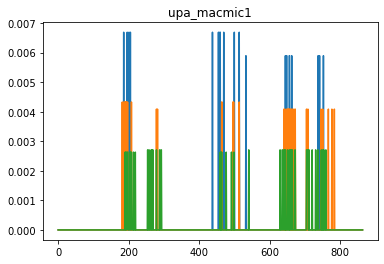

In [22]:
plt.plot(rawDS.isel(ilev=40,lat=0,lon=0).upa_macmic1.isel(nens=0).values)
plt.plot(rawDS.isel(ilev=40,lat=0,lon=0).upa_macmic1.isel(nens=1).values)
plt.plot(rawDS.isel(ilev=40,lat=0,lon=0).upa_macmic1.isel(nens=2).values)
plt.title('upa_macmic1')

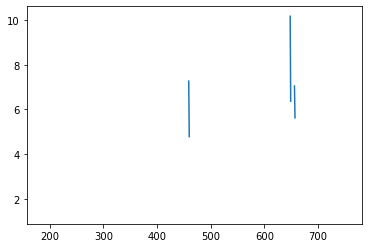

In [27]:
plt.plot(subset_ds1.isel(ilev=40,lat=0,lon=0,nens=0).values)
plt.plot(subset_ds2.isel(ilev=40,lat=0,lon=0,nens=0).values)

Text(0.5, 1.0, 'upa_macmic2')

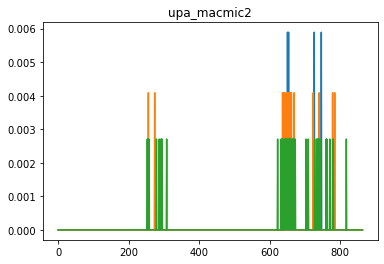

In [23]:
plt.plot(rawDS.isel(ilev=40,lat=0,lon=0).upa_macmic2.isel(nens=0).values)
plt.plot(rawDS.isel(ilev=40,lat=0,lon=0).upa_macmic2.isel(nens=1).values)
plt.plot(rawDS.isel(ilev=40,lat=0,lon=0).upa_macmic2.isel(nens=2).values)
plt.title('upa_macmic2')

## Start dask?

In [8]:
import dask

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="03:00:00",
    project="P93300642",
    #memory="4GB",
    #resource_spec="select=1:ncpus=1:mem=4GB",
    memory="10GB",
    resource_spec="select=1:ncpus=1:mem=10GB",
    cores=1,
    processes=1,
)



In [9]:
from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

<Client: 'tcp://128.117.208.64:43747' processes=0 threads=0, memory=0 B>

In [10]:
cluster.scale(24)


In [11]:
client.wait_for_workers(24)


## Read in data

In [8]:
# case_names  = [
#                # 'clubbMF_L0eq50',
#                # 'claspMF_L0eq50',
    
#                # 'clubbMF_L0eq250',
#                # 'claspMF_L0eq250',
# #                'claspMF_L0eq250_52pct',
# #                'claspMF_L0eq250_rand',
    
#                # 'clubbMF_Lopt6_perPlume_addNewTerm',
#                # 'claspMF_Lopt6_perPlume_addNewTermSmpl',
    
#                # 'clubbMF_L0eq250_addNewTerm',
#                # 'claspMF_L0eq250_addNewTermSmpl',
#                 'clubbMF_L0eq50_addNewTerm',
#                 'claspMF_L0eq50_addNewTermSmpl',
                
    
#               ]


In [8]:
%%time
testDir     = '/glade/derecho/scratch/mdfowler/CLASP+MF_100ens/'
# testDir     = '/glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/'
#testDir     = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/'

case_names  = [
                # 'clubbMF_L0eq250_n100',
                'claspMF_L0eq250_n100',
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
    # 'usePatchDataFALSE_25each_L0eq250_nup100_newHETterm_simplExtraPlume_diffOff_allJJA.',
    'usePatchDataTRUE_25each_L0eq250_nup100_newHETterm_simplExtraPlume_diffOff_allJJA.'
]

countCLMh2 = 0 

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0.201*'))
    listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1.201*'))
    listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2.201*'))
    listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3.201*'))

    listFilesCLM_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h2.201*'))
    listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1.201*'))
    listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0.201*'))        

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')

    case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 files loaded with mfdataset')
    case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 2D data loaded with mfdataset')
    
    case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h3 files loaded with mfdataset')
        
    # Merge cases and load
    caseFull = xr.merge([case_h1, case_h0])
    caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    case_h0.close()
    case_h1.close()
    
    caseH2   = xr.merge([case_h2, case_h2_2d])
    caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    case_h2.close()
    case_h2_2d.close()
    
    caseH3   = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3   = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})
    case_h3.close()
    
    del case_h0,case_h1,case_h2,case_h2_2d,case_h3
    # del case_h0,case_h1

    print('DS merged and loaded')
    
    ## Process data 
    procDS    = process_camData( caseFull )
    del caseFull
    procDS_h2 = process_camData_h2( caseH2, procDS  )
    del caseH2
    
    procDS_h3_combine = combineMacmic_beforeInterp(caseH3)
    del caseH3
    procDS_h3 = process_camData_h3( procDS_h3_combine, procDS  )
    del procDS_h3_combine
    
    procDS_h2 = xr.merge([procDS_h2, procDS_h3])
    # procDS_h2 = combineMacmic(procDS_h3, procDS_h2)
    del procDS_h3
            
    ## Combine all the cases into 
    case_allDays      = procDS.squeeze().assign_coords({"case":  case_names[iCase]})
    h2_allDays        = procDS_h2.squeeze().assign_coords({"case":  case_names[iCase]})
    # h3_allDays        = procDS_h3.squeeze().assign_coords({"case":  case_names[iCase]})
    del procDS_h2, procDS
    
    ## Drop excessive variables to save space
    h2_allDays = h2_allDays.drop_vars(['ntrk','ntrn','ntrm','gw','hyam','hybm',                                  
                                 'P0','hyai','hybi','date','datesec','time_bnds','date_written',
                                 'time_written','ndbase','nsbase','nbdate','nbsec','mdt','ndcur',
                                 'nscur','co2vmr','ch4vmr','n2ovmr','f11vmr','f12vmr','sol_tsi','nsteph',
                                  ## Also remove downdraft data (not active here)
                                 'qtd_macmicAvg_interp','thld_macmicAvg_interp','dna_macmicAvg_interp',
                                  'dn_macmicAvg_interp','qtd_macmicAvg','thld_macmicAvg','dna_macmicAvg',
                                  'dn_macmicAvg','upa_macmic2','upa_macmic1','edmf_dnw_interp',
                                  ## Also drop macmicAvg if not interpolated 
                                  'up_macmicAvg','upa_macmicAvg','thlu_macmicAvg','qtu_macmicAvg',
                                  ## Riskier - but drop the things that are just the last time-step
                                  # 'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                                    ])
    
    ## Save individual, concatted files... 
    # filename_h0 = testDir+'scamDS_h0_radVars_'+case_names[iCase]+'.nc'
    filename_h0 = testDir+'scamDS_h0_'+case_names[iCase]+'.nc'
    filename_h2 = testDir+'scamDS_h2_'+case_names[iCase]+'.nc'

    case_allDays.to_netcdf(filename_h0, mode='w')
    case_allDays.close()
    
    h2_allDays.to_netcdf(filename_h2, mode='w')
    h2_allDays.close()
    
    del case_allDays
    del h2_allDays    
        
    # if iCase==0:
    #     scamDS    = case_allDays
    #     del case_allDays
    #     scamDS_h2 = h2_allDays
    #     del h2_allDays
    #     # scamDS_h3 = h3_allDays
    #     # del h3_allDays
    # else: 
    #     scamDS    = xr.concat([scamDS, case_allDays], "case") 
    #     del case_allDays
    #     scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
    #     del h2_allDays
    #     # scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 
    #     # del h3_allDays

    ## - - - - - - - - - - - - - - - - - - - - - 
    ## Read in CLM datasets too 
    ## - - - - - - - - - - - - - - - - - - - - - 

    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')
    
    clm2_exists = False
    if len(listFilesCLM_h2)>0:
        caseCLM_h2 = xr.open_mfdataset(listFilesCLM_h2,  preprocess=preprocessCLM_h2, concat_dim='time', 
                                    combine='nested', decode_times=True, 
                                    data_vars='minimal')
        caseCLMh2_allDays = caseCLM_h2.assign_coords({"case":  case_names[iCase]})
        clm2_exists = True
        print('CLM_h2 files loaded with mfdataset')

#     caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    
    ## Save individual, concatted files... 
    # filenameCLM_h0 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_clm_h0_'+case_names[iCase]+'.nc'
    filenameCLM_h1 = testDir+'scamDS_clm_h1_'+case_names[iCase]+'.nc'
    filenameCLM_h2 = testDir+'scamDS_clm_h2_'+case_names[iCase]+'.nc'
    
#     caseCLMh0_allDays.to_netcdf(filenameCLM_h0, mode='w')
#     caseCLMh0_allDays.close()
    
    caseCLMh1_allDays.to_netcdf(filenameCLM_h1, mode='w')
    caseCLMh1_allDays.close()
    
    # del caseCLMh0_allDays
    del caseCLMh1_allDays    
    
    if clm2_exists==True:
        caseCLMh2_allDays.to_netcdf(filenameCLM_h2, mode='w')
        caseCLMh2_allDays.close()
        countCLMh2 = countCLMh2+1
        del caseCLMh2_allDays
    
#     if iCase==0:
# #         clmDS_h0 = caseCLMh0_allDays
#         clmDS_h1 = caseCLMh1_allDays
#         # if len(listFilesCLM_h2)>0:
#         #     clmDS_h2 = caseCLMh2_allDays
#         #     del caseCLMh2_allDays
#     else: 
# #         clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
#         clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
#         # if len(listFilesCLM_h2)>0:
#         #     clmDS_h2 = xr.concat([clmDS_h2, caseCLMh2_allDays], "case") 
#         #     del caseCLMh2_allDays
                    
#     if clm2_exists==True: 
#         if countCLMh2==0:
#             clmDS_h2 = caseCLMh2_allDays
#             countCLMh2 = countCLMh2+1
#         else: 
#             clmDS_h2 = xr.concat([clmDS_h2, caseCLMh2_allDays], "case") 
#             countCLMh2 = countCLMh2+1
        
    # del caseCLMh1_allDays
    print('Done with CLM files')
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
        

*** Starting on case claspMF_L0eq250_n100 ***
h0 files loaded
h1 files loaded
h2 files loaded with mfdataset
h2 2D data loaded with mfdataset
h3 files loaded with mfdataset
DS merged and loaded
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
CLM_h0 files loaded with mfdataset
CLM_h1 files loaded with mfdataset
CLM_h2 files loaded with mfdataset
Done with CLM files
Done with case 1 of 1 
CPU times: user 15min 55s, sys: 31min 43s, total: 47min 38s
Wall time: 3h 2min 28s


In [9]:
# %%time
# ## only worry about h0, get FSDS alone 

# testDir     = '/glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/'
# #testDir     = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/'

# case_names  = [
#                 'clubbMF_L0eq50_diffOff',
#                 'claspMF_L0eq50_diffOff',
#               ]

# caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

# caseStrings = [
#     'usePatchDataFALSE_25each_L0eq50_nup25_newHETterm_simplExtraPlume_diffOff_allJJA.',
#     'usePatchDataTRUE_25each_L0eq50_nup25_newHETterm_simplExtraPlume_diffOff_allJJA.'
# ]

# countCLMh2 = 0 

# for iCase in range(len(case_names)):
#     print('*** Starting on case %s ***' % (case_names[iCase]))

#     ## Get list of files 
#     listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0.201*'))

#     case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
#                                 combine='nested', decode_times=False, 
#                                 data_vars='minimal')
#     print('h0 files loaded')

#     # Merge cases and load
#     caseFSDS = case_h0.FSDS
#     case_h0.close()
    
#     del case_h0
             
#     ## Combine all the cases into 
#     case_allDays      = caseFSDS.squeeze().assign_coords({"case":  case_names[iCase]})
        
#     ## Save individual, concatted files... 
#     filename_h0 = testDir+'scamDS_h0_FSDS_'+case_names[iCase]+'.nc'
    
#     case_allDays.to_netcdf(filename_h0, mode='w')
#     case_allDays.close()
    
#     del case_allDays
        
            
#     print('Done with case %i of %i ' % (iCase+1, len(case_names)))
        

*** Starting on case clubbMF_L0eq50_diffOff ***
h0 files loaded
Done with case 1 of 2 
*** Starting on case claspMF_L0eq50_diffOff ***
h0 files loaded
Done with case 2 of 2 
CPU times: user 2min 55s, sys: 8min 34s, total: 11min 30s
Wall time: 13min 1s


In [10]:
testDir     = '/glade/derecho/scratch/mdfowler/CLASP+MF_100ens/'

case_names  = [
                'clubbMF_L0eq250_n100',
                'claspMF_L0eq250_n100',
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
    'usePatchDataFALSE_25each_L0eq250_nup100_newHETterm_simplExtraPlume_diffOff_allJJA.',
    'usePatchDataTRUE_25each_L0eq250_nup100_newHETterm_simplExtraPlume_diffOff_allJJA.'
]


In [11]:
%%time 
for iCase in range(len(case_names)):
    print('*** Loading files from case %s ***' % (case_names[iCase]))
    
    filename_h0 = testDir+'scamDS_h0_'+case_names[iCase]+'.nc'
    # filenameFSDS_h0 = testDir+'scamDS_h0_FSDS_'+case_names[iCase]+'.nc'
    # filenameRHO_h0 = testDir+'scamDS_h0_rho_'+case_names[iCase]+'.nc'
    # filenameRAD_h0 = testDir+'scamDS_h0_radVars_'+case_names[iCase]+'.nc'
    filename_h2 = testDir+'scamDS_h2_'+case_names[iCase]+'.nc'

    filenameCLM_h0 = testDir+'scamDS_clm_h0_'+case_names[iCase]+'.nc'
    filenameCLM_h1 = testDir+'scamDS_clm_h1_'+case_names[iCase]+'.nc'
    filenameCLM_h2 = testDir+'scamDS_clm_h2_'+case_names[iCase]+'.nc'

    # ## Read in those files 
    scamDS_case    = xr.open_dataset(filename_h0)
    # scamDS_FSDS_case    = xr.open_dataset(filenameFSDS_h0)
    # scamDS_rho_case    = xr.open_dataset(filenameRHO_h0)
    # scamDS_rad_case    = xr.open_dataset(filenameRAD_h0)
    scamDS_h2_case = xr.open_dataset(filename_h2)
    
    # scamDSclm_h0_case = xr.open_dataset(filenameCLM_h0)
    scamDSclm_case    = xr.open_dataset(filenameCLM_h1)
    scamDSclm_h2_case = xr.open_dataset(filenameCLM_h2)  

    if iCase==0: 
        scamDS    = scamDS_case
        del scamDS_case
        scamDS_h2 = scamDS_h2_case
        del scamDS_h2_case  
        # scamDS_FSDS = scamDS_FSDS_case
        # scamDS_rho = scamDS_rho_case
        # scamDS_rad = scamDS_rad_case
        # del scamDS_rad_case
        
        # clmDS_h0  = scamDSclm_h0_case
        # del scamDSclm_h0_case
        clmDS_h1  = scamDSclm_case
        del scamDSclm_case
        clmDS_h2  = scamDSclm_h2_case
        del scamDSclm_h2_case
        
    else: 
        scamDS    = xr.concat([scamDS, scamDS_case], "case") 
        del scamDS_case
        scamDS_h2 = xr.concat([scamDS_h2, scamDS_h2_case], "case") 
        del scamDS_h2_case        
        # scamDS_FSDS    = xr.concat([scamDS_FSDS, scamDS_FSDS_case], "case") 
        # scamDS_rho    = xr.concat([scamDS_rho, scamDS_rho_case], "case") 
        # scamDS_rad    = xr.concat([scamDS_rad, scamDS_rad_case], "case") 
        # del scamDS_rad_case
    
        # clmDS_h0    = xr.concat([clmDS_h0, scamDSclm_h0_case], "case") 
        # del scamDSclm_h0_case
        clmDS_h1    = xr.concat([clmDS_h1, scamDSclm_case], "case") 
        del scamDSclm_case
        clmDS_h2 = xr.concat([clmDS_h2, scamDSclm_h2_case], "case") 
        del scamDSclm_h2_case    
    
print('*~*~* All Done *~*~*')

*** Loading files from case clubbMF_L0eq250_n100 ***
*** Loading files from case claspMF_L0eq250_n100 ***
*~*~* All Done *~*~*
CPU times: user 1min 57s, sys: 1h 9min 54s, total: 1h 11min 51s
Wall time: 1h 46min 5s


In [84]:
# scamDS_h2['edmf_L0'] = scamDS_h2_2d.edmf_L0

In [86]:
# file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq50_L0eq250_LoptEq6_20230801.nc'

# scamDS_h2.to_netcdf(file_name_h2, mode='w')
# scamDS_h2.close()

In [12]:
%%time 
plumeLabel = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values), len(scamDS_h2.nens.values)], 'SurfaceAvg')

sigDig     = 9

for iCase in range(len(clmDS_h2.case.values)):

    for iT in range(len(clmDS_h1.time.values)-1):

        # Sel time QFLX and edmf_uplh 
        this_uplh    = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_uplh.values
        this_qflx    = clmDS_h1.isel(case=(iCase)).isel(time=iT).QFLX 
        this_qflx_LU = clmDS_h2.isel(case=iCase).isel(time=iT).QFLX 
        this_upa     = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values

        iGrass = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[0],sigDig))[0]
        iCrop  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[1],sigDig))[0]

        # Land-unit means...
        iUrban = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[2],sigDig))[0]
        iLake  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[3],sigDig))[0]
        
        ## TODO: For safety, since using a round off digit, should confirm that things aren't being marked as two PFTs 

        ## Also fill in if the plume is not active...
        this_upa  = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values
        iMiss     = np.where(this_upa==0.0)[0]

        plumeLabel[iCase, iT, iGrass] = 'C3grass'
        plumeLabel[iCase, iT, iCrop]  = 'IrrigCrop'
        plumeLabel[iCase, iT, iLake]  = 'Lake'
        plumeLabel[iCase, iT, iUrban] = 'Urban'
        plumeLabel[iCase, iT, iMiss]  = 'Off'

scamDS_h2['plumeLabel'] = (('case','time','nens'), plumeLabel)


CPU times: user 11min 27s, sys: 26.1 s, total: 11min 53s
Wall time: 15min 23s


In [13]:
a= 10

In [14]:
print(a)

10


In [ ]:
# selHrs = np.where(scamDS_h2['time.hour'].values==14)[0]
# thisHrDS = scamDS_h2.plumeLabel.isel(time=selHrs, case=1)

# np.where(thisHrDS=='Off')[0]


In [24]:
# iT = np.where(scamDS_h2.time.values==thisHrDS.isel(time=422).time.values)[0] 

# print(scamDS_h2['plumeLabel'].isel(time=iT,case=1).values)

# # Sel time QFLX and edmf_uplh 
# this_uplh    = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_uplh.values
# this_qflx    = clmDS_h1.isel(case=(iCase)).isel(time=iT).QFLX 
# this_qflx_LU = clmDS_h2.isel(case=iCase).isel(time=iT).QFLX 
# this_upa     = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values



[['C3grass' 'C3grass' 'C3grass' 'C3grass' 'C3grass' 'C3grass' 'C3grass'
  'IrrigCrop' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop'
  'Urban' 'Urban' 'Urban' 'Urban' 'Urban' 'Urban' 'Off' 'Off' 'Off' 'Off'
  'Off' 'Off']]


In [36]:
# print('Plume Labels: ', scamDS_h2['plumeLabel'].isel(time=iT,case=1).values)
# print()
# print('this_LH (per plume)\n', this_uplh)
# print()

# print('this_qflx (per pft)\n', this_qflx.values)
# print('PFT @ ind0 = grass ..... PFT @ ind1 = irrigCrop')
# print()

# print('this_qflx_LU (per LU)\n', this_qflx_LU.values)
# print('LU @ ind2 = urban ..... LU @ ind3 = Lake')
# print()

# print('this_upa (per plume)\n', this_upa)
# print()

# print('TG (per LU)\n', clmDS_h2.isel(case=1,time=iT).TG.values)
# print('LU @ ind2 = urban ..... LU @ ind3 = Lake')
# print()


Plume Labels:  [['C3grass' 'C3grass' 'C3grass' 'C3grass' 'C3grass' 'C3grass' 'C3grass'
  'IrrigCrop' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop' 'IrrigCrop'
  'Urban' 'Urban' 'Urban' 'Urban' 'Urban' 'Urban' 'Off' 'Off' 'Off' 'Off'
  'Off' 'Off']]

this_LH (per plume)
 [[9.8622841e-05 9.8622841e-05 9.8622841e-05 9.8622841e-05 9.8622841e-05
  9.8622841e-05 9.8622841e-05 1.9716712e-04 1.9716712e-04 1.9716712e-04
  1.9716712e-04 1.9716712e-04 1.9716712e-04 5.2899759e-05 5.2899759e-05
  5.2899759e-05 5.2899759e-05 5.2899759e-05 5.2899759e-05 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]

this_qflx (per pft)
 [[9.8622841e-05 1.9716712e-04 1.7121315e-11 0.0000000e+00 0.0000000e+00
  1.7121315e-11 3.5266494e-04 1.4055852e-04]]
PFT @ ind0 = grass ..... PFT @ ind1 = irrigCrop

this_qflx_LU (per LU)
 [[9.8622841e-05 1.9716712e-04 5.2899759e-05 1.4055852e-04]]
LU @ ind2 = urban ..... LU @ ind3 = Lake

this_upa (per plume)
 [[0.00589227 0.00408652 0.002

In [ ]:
## Dig in a bit more (11/20/23) 

np.unique(scamDS_h2['plumeLabel'].isel(nens=0))

plume0 = scamDS_h2['plumeLabel'].isel(nens=0, case=1)

iC3grass = np.where(plume0=='C3grass')[0]
iIrrig   = np.where(plume0=='IrrigCrop')[0]
iLake    = np.where(plume0=='Lake')[0]
iAvg     = np.where(plume0=='SurfaceAvg')[0]

print(len(iC3grass), len(iIrrig), len(iLake), len(iAvg))


In [23]:
print(scamDS_h2.isel(case=(1)).isel(time=8284, ilev=-1, nens=0).edmf_uplh.values)

0.00015336792


In [19]:
print(clmDS_h1.isel(case=1).isel(time=8284).QFLX )

<xarray.DataArray 'QFLX' (pft: 8)>
array([1.5265559e-04, 1.5336793e-04, 7.9522477e-09, 0.0000000e+00,
       0.0000000e+00, 7.9522477e-09, 2.0717694e-04, 1.8756240e-04],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-06-30T18:20:59.995422
    case     <U29 'claspMF_L0eq50_addNewTermSmpl'
Dimensions without coordinates: pft


In [25]:
print(clmDS_h2.isel(case=1).isel(time=8284).QFLX.values )

[1.5265559e-04 1.5336793e-04 3.1083302e-05 1.8756240e-04]


In [14]:
iC3grass

array([  109,   110,   111, ..., 26435, 26436, 26437])

In [15]:
iIrrig

array([ 8284,  8285,  8286,  8287,  8288,  8289,  8290,  8451,  8452,
        8453,  8454,  8455,  8456,  8457,  8458,  8459,  8460,  8788,
        8790,  8791,  8792,  8794,  8819,  8834,  8840,  9166, 10033,
       10610, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320,
       12321, 12322, 12323, 12324, 12606, 12607, 14177, 14185, 14187,
       14189, 14191, 14193, 14354, 14355, 14356, 14357, 14358, 14359,
       14485, 14486, 14487, 14488, 14489, 14490, 14491, 14492, 15649,
       18843, 19789, 19791, 19806, 19808, 19809, 21413, 21414, 21415,
       21416, 21417, 21418, 21419, 21420, 21701, 21702, 24293, 24295])

In [24]:
print(scamDS_h2.isel(case=(1)).isel(time=109, ilev=-1, nens=0).edmf_uplh.values)

6.903331e-05


In [26]:
print(clmDS_h2.isel(case=1).isel(time=109).QFLX.values )

[6.9033311e-05 8.7398592e-05 1.0311236e-05 1.5772980e-04]


In [15]:
## Get number of plumes at each time/level
nPlumesActive = scamDS_h2.edmf_upa_interp.count(dim='nens')
print(np.shape(nPlumesActive))

scamDS['nPlumesActive'] = (('case','time','levInterp'), nPlumesActive.values)

# grassDS = scamDS_h2.where(scamDS_h2.plumeLabel == 'C3grass')
# cropDS  = scamDS_h2.where(scamDS_h2.plumeLabel == 'IrrigCrop')
# lakeDS  = scamDS_h2.where(scamDS_h2.plumeLabel == 'Lake')
# urbanDS = scamDS_h2.where(scamDS_h2.plumeLabel == 'Urban')

scamDS['nPlumesActive_grass'] = (('case','time','levInterp'), scamDS_h2.edmf_upa_interp.where(scamDS_h2.plumeLabel == 'C3grass').count(dim='nens').values)
scamDS['nPlumesActive_crop']  = (('case','time','levInterp'), scamDS_h2.edmf_upa_interp.where(scamDS_h2.plumeLabel == 'IrrigCrop').count(dim='nens').values)
scamDS['nPlumesActive_urban'] = (('case','time','levInterp'), scamDS_h2.edmf_upa_interp.where(scamDS_h2.plumeLabel == 'Urban').count(dim='nens').values)
scamDS['nPlumesActive_lake']  = (('case','time','levInterp'), scamDS_h2.edmf_upa_interp.where(scamDS_h2.plumeLabel == 'Lake').count(dim='nens').values)


(2, 52992, 78)


In [17]:
scamDS

<xarray.Dataset>
Dimensions:              (case: 2, time: 52992, ilev: 59, lev: 58, nens: 100,
                          levInterp: 78)
Coordinates:
    lat                  float64 36.6
    lon                  float64 262.5
  * ilev                 (ilev) float64 2.055 3.98 6.909 ... 987.4 995.1 1e+03
  * time                 (time) datetime64[ns] 2015-06-02T00:03:30 ... 2016-0...
  * lev                  (lev) float64 3.018 5.445 9.087 ... 983.2 991.2 997.5
  * nens                 (nens) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * levInterp            (levInterp) float64 200.0 210.0 220.0 ... 960.0 970.0
  * case                 (case) <U20 'clubbMF_L0eq250_n100' 'claspMF_L0eq250_...
Data variables: (12/17)
    radht_LW             (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    radht_SW             (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Frad                 (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    P0                   (case) float64 1e+05 1e+05
    hyam                 (case, lev) float64 0.003018 0.005445 ... 0.0003615 0.0
    hybm                 (case, lev) float64 0.0 0.0 0.0 ... 0.9908 0.9975
    ...                   ...
    Frad_interp          (case, time, levInterp) float64 0.0 0.0 0.0 ... 0.0 0.0
    nPlumesActive        (case, time, levInterp) int64 0 0 0 0 0 ... 24 25 25 25
    nPlumesActive_grass  (case, time, levInterp) int64 0 0 0 0 0 0 ... 0 0 0 0 0
    nPlumesActive_crop   (case, time, levInterp) int64 0 0 0 0 0 0 ... 0 0 0 0 0
    nPlumesActive_urban  (case, time, levInterp) int64 0 0 0 0 0 0 ... 0 0 0 0 0
    nPlumesActive_lake   (case, time, levInterp) int64 0 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FSCAM.T42_T42.arm97.CLASP_CLUBBMF_usePatchDataFALSE_25...
    logname:           mdfowler
    host:              izumi.cgd.ucar.e
    initial_file:      /project/amp/rneale/scam/ncar_pbl/ncdata/FWsc_T42_58L_...
    topography_file:   /fs/cgd/csm/inputdata/atm/cam/topo/T42_nc3000_Co060_Fi...
    model_doi_url:     not_set
    time_period_freq:  minute_5

In [16]:
tot_wp2 = scamDS_h2.edmf_S_AWW_interp.values + scamDS.WP2_CLUBB_interp.values
scamDS_h2['total_wp2']  = (('case','time','levInterp'), tot_wp2)

tot_thlp2 = scamDS_h2.edmf_S_ATHLTHL_interp.values + scamDS.THLP2_CLUBB_interp.values
scamDS_h2['total_thlp2']  = (('case','time','levInterp'), tot_thlp2)

tot_rtp2 = scamDS_h2.edmf_S_AQTQT_interp.values + (1e-6 * scamDS.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
scamDS_h2['total_rtp2']  = (('case','time','levInterp'), tot_rtp2)

tot_wpthlp = scamDS_h2.edmf_thlflxup_interp.values + (scamDS.wpthlp_interp.values)
scamDS_h2['total_wpthlp']  = (('case','time','levInterp'), tot_wpthlp)

tot_wprtp = scamDS_h2.edmf_qtflxup_interp.values + (scamDS.wprtp_interp.values)
scamDS_h2['total_wprtp']  = (('case','time','levInterp'), tot_wprtp)



AttributeError: 'Dataset' object has no attribute 'WP2_CLUBB_interp'

In [ ]:
# Save the new "added term" dataset out
# file_name_h0 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_L0eq250addedTerm_20231012.nc'
# file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq250addedTerm_20231012.nc'
# file_name_h0 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_Lopt6PP_addedTermSmpl_20231117.nc'
# file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_Lopt6PP_addedTermSmpl_20231117.nc'

# file_name_h0 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_L0eq50_addedTermSmpl_20231117.nc'
# file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq50_addedTermSmpl_20231117.nc'

file_name_h0 = testDir+'scamDS_h0_L0eq250_addedTermSmpl_noDiffusion_100nens_20240924.nc'
file_name_h2 = testDir+'scamDS_h2_L0eq250_addedTermSmpl_noDiffusion_100nens_20240924.nc'


scamDS.to_netcdf(file_name_h0, mode='w')
scamDS.close()

scamDS_h2.to_netcdf(file_name_h2, mode='w')
scamDS_h2.close()


In [22]:
testDir     = '/glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/'

file_name_h0 = '~/scamDS_h0_radiation_L0eq250_addedTermSmpl_noDiffusion_2015&16_20240626.nc'
scamDS_rad.to_netcdf(file_name_h0, mode='w')
scamDS_rad.close()


In [12]:
file_name_h0

'/glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/scamDS_h0_FSDS_L0eq50_addedTermSmpl_noDiffusion_2015&16_20240501.nc'

In [10]:
file_name_clmh0 = testDir+'clmDS_h0_L0eq250_addedTermSmpl_noDiffusion_2015&16_20240501.nc'
clmDS_h0.to_netcdf(file_name_clmh0, mode='w')
clmDS_h0.close()


In [18]:
# file_name_clmh1 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_L0eq250addedTerm_20231012.nc'
# file_name_clmh1 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_Lopt6PP_addedTermSmpl_20231117.nc'
#file_name_clmh1 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_L0eq50_addedTermSmpl_20231117.nc'
file_name_clmh1 = testDir+'clmDS_h1_L0eq50_addedTermSmpl_noDiffusion_2015_20240501.nc'
clmDS_h1.to_netcdf(file_name_clmh1, mode='w')
clmDS_h1.close()

# file_name_clmh2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_L0eq250addedTerm_20231012.nc'
# file_name_clmh2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_Lopt6PP_addedTermSmpl_20231117.nc'
# file_name_clmh2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_L0eq50_addedTermSmpl_20231117.nc'
file_name_clmh2 = testDir+'clmDS_h2_L0eq50_addedTermSmpl_noDiffusion_2015_20240501.nc'
clmDS_h2.to_netcdf(file_name_clmh2, mode='w')
clmDS_h2.close()


In [15]:
! ls -l /glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/clmDS_h?_L0eq250_*

-rw-r--r-- 1 mdfowler ncar 46463636 Apr  2 09:11 /glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/clmDS_h1_L0eq250_addedTermSmpl_noDiffusion_2015_20240228.nc
-rw-r--r-- 1 mdfowler ncar 46463636 May  1 14:43 /glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/clmDS_h1_L0eq250_addedTermSmpl_noDiffusion_2015_20240501.nc
-rw-r--r-- 1 mdfowler ncar 46463636 Apr  2 09:07 /glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/clmDS_h1_L0eq250_addedTermSmpl_noDiffusion_2016_20240228.nc
-rw-r--r-- 1 mdfowler ncar 37985163 Apr  2 09:11 /glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/clmDS_h2_L0eq250_addedTermSmpl_noDiffusion_2015_20240228.nc
-rw-r--r-- 1 mdfowler ncar 37985163 May  1 14:43 /glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/clmDS_h2_L0eq250_addedTermSmpl_noDiffusion_2015_20240501.nc
-rw-r--r-- 1 mdfowler ncar 37985163 Apr  2 09:07 /glade/derecho/scratch/mdfowler/CLASP+MF_diffusionOff/clmDS_h2_L0eq250_addedTermSmpl_noDiffusion_2016_20240228.nc
-rw-r--r-- 1 mdfowler 

In [15]:
# ## Can I just save the data out?? Would save a lot of time reading everything in and processing it. 
# # file_name_h0 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_L0eq50_L0eq250_LoptEq6.nc'
# file_name_h0 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_L0eq50_L0eq250_LoptEq6_20230831.nc'

# # file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq50_L0eq250_LoptEq6.nc'
# # file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq50_L0eq250_LoptEq6_20230801.nc'
# file_name_h2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h2_L0eq50_L0eq250_LoptEq6_20230831.nc'

# scamDS.to_netcdf(file_name_h0, mode='w')
# scamDS.close()

# scamDS_h2.to_netcdf(file_name_h2, mode='w')
# scamDS_h2.close()

# # ## Read in those files 
# # scamDS = xr.open_dataset(file_name_h0).load()
# # scamDS_h2 = xr.open_dataset(file_name_h2).load()


PermissionError: [Errno 13] Permission denied: '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/scamDS_h0_L0eq50_L0eq250_LoptEq6_20230831.nc'

In [10]:
# file_name_clmh1 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_L0eq50_L0eq250_LoptEq6.nc'
file_name_clmh1 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h1_L0eq50_L0eq250_LoptEq6_20230831.nc'
# clmDS_h1.to_netcdf(file_name_clmh1, mode='w')
# clmDS_h1.close()

# file_name_clmh2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_L0eq50_L0eq250_LoptEq6.nc'
file_name_clmh2 = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/allJJA/clmDS_h2_L0eq50_L0eq250_LoptEq6_20230831.nc'
# clmDS_h2.to_netcdf(file_name_clmh2, mode='w')
# clmDS_h2.close()

## Read in those files 
# clmDS_h1 = xr.open_dataset(file_name_clmh1).load()
# clmDS_h2 = xr.open_dataset(file_name_clmh2).load()


In [12]:
# Simplistic definition of LTS: theta_700 - theta_sfc 
#
theta = mpc.potential_temperature(scamDS.levInterp.values * units.mbar, scamDS.T_interp.values * units.kelvin)
scamDS['THETA_interp'] = (('case','time','levInterp'), theta)

theta700 = scamDS['THETA_interp'].isel(levInterp=np.where(scamDS.levInterp.values==700.)[0])

# Ideally, use 2m theta... 
theta2m = mpc.potential_temperature(scamDS.PS.values * units.Pa, scamDS.TREFHT.values * units.kelvin)
scamDS['THETA_sfc'] = (('case','time'), theta2m)

LTS = theta700-scamDS['THETA_sfc']
scamDS['LTS'] = (('case','time'), np.squeeze(LTS))



## Plotting 

In [15]:
scamDS_h2['edmf_L0'].sel(case='claspMF_L0eq50').values[0:55]

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50.], dtype=float32)

In [16]:
scamDS_h2['edmf_L0'].sel(case='clubbMF_L0eq50').values[0:55]

array([   50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    ,    50.    ,
          50.    ,    50.    ,    50.    ,    50.    , 10000.    ,
       10000.    , 10000.    , 10000.    , 10000.    ,  5001.8394,
       10000.    , 10000.    , 10000.    , 10000.    , 10000.    ],
      dtype=float32)

In [17]:
scamDS['nPlumesActive'].isel(levInterp=-1).sel(case='clubbMF_L0eq50').values[0:55]

array([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 23,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

In [100]:
scamDS_h2['time'].values[0:55]

array(['2015-06-02T00:03:30.000000000', '2015-06-02T00:08:30.000000000',
       '2015-06-02T00:13:30.000000000', '2015-06-02T00:18:30.000000000',
       '2015-06-02T00:23:30.000000000', '2015-06-02T00:28:30.000000000',
       '2015-06-02T00:33:30.000000000', '2015-06-02T00:38:30.000000000',
       '2015-06-02T00:43:30.000000000', '2015-06-02T00:48:30.000000000',
       '2015-06-02T00:53:30.000000000', '2015-06-02T00:58:30.000000000',
       '2015-06-02T01:03:30.000000000', '2015-06-02T01:08:30.000000000',
       '2015-06-02T01:13:30.000000000', '2015-06-02T01:18:30.000000000',
       '2015-06-02T01:23:30.000000000', '2015-06-02T01:28:30.000000000',
       '2015-06-02T01:33:30.000000000', '2015-06-02T01:38:30.000000000',
       '2015-06-02T01:43:30.000000000', '2015-06-02T01:48:30.000000000',
       '2015-06-02T01:53:30.000000000', '2015-06-02T01:58:30.000000000',
       '2015-06-02T02:03:30.000000000', '2015-06-02T02:08:30.000000000',
       '2015-06-02T02:13:30.000000000', '2015-06-02

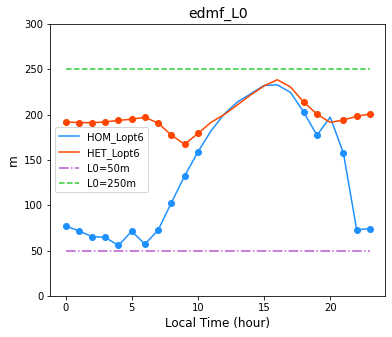

In [18]:
# - - - - - - - - - - - - - - - - - - - - - -
#  Plot mean diurnal cycle with error bars
# - - - - - - - - - - - - - - - - - - - - - - 

scamDS['edmf_L0'] = scamDS_h2['edmf_L0']

varPlot = 'edmf_L0'
yMax    = 300
yMin    = 0
unitsString = scamDS[varPlot].units
# unitsString = 'mm/hr'
setYlims = True 

# valueMultiplier = (3600*1e3)
valueMultiplier =  1
# CIlevel = 1.960   ## 95% CI 

plotTests250 = False

# - - - - - - - - - - - - - - - - - 
fig,axs = plt.subplots(1,1, figsize=(6,5))

DS_mean  = (valueMultiplier*scamDS[varPlot]).groupby('time.hour').mean(dim='time')
DS_std   = (valueMultiplier*scamDS[varPlot]).groupby('time.hour').std(dim='time')
DS_count = (valueMultiplier*scamDS[varPlot]).groupby('time.hour').count(dim='time')
DS_SE    = DS_std/np.sqrt(DS_count)

## Paired T-test for significance
pVal_50   = np.full([24], np.nan)
pVal_250  = np.full([24], np.nan)
pVal_Lopt = np.full([24], np.nan)
for iHr in range(24): 
    t,p50 = stats.ttest_rel(scamDS[varPlot].sel(case='clubbMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                            scamDS[varPlot].sel(case='claspMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                            nan_policy = 'omit')
    if p50<0.05: 
        pVal_50[iHr]=1
        
    t,p250 = stats.ttest_rel(scamDS[varPlot].sel(case='clubbMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                             scamDS[varPlot].sel(case='claspMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                             nan_policy = 'omit')
    if p250<0.05: 
        pVal_250[iHr]=1
        
    t,pLopt = stats.ttest_rel(scamDS[varPlot].sel(case='clubbMF_Lopt6_perPlume').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              scamDS[varPlot].sel(case='claspMF_Lopt6_perPlume').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              nan_policy = 'omit')
    if pLopt<0.05: 
        pVal_Lopt[iHr]=1
            
# - - - - - - - - - - - - - - - - - 

axs.plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_Lopt6_perPlume').values, color='dodgerblue', label='HOM_Lopt6_pp') 
axs.plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_Lopt6_perPlume').values, color='orangered', label='HET_Lopt6_pp') 
axs.plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq50').values,'-.', color='mediumorchid', label='L0=50m') 
axs.plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250').values,'--', color='limegreen', label='L0=250m') 
axs.legend()

axs.plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_Lopt6_perPlume').values*pVal_Lopt, 'o', color='dodgerblue')
axs.plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_Lopt6_perPlume').values*pVal_Lopt, 'o', color='orangered')

axs.set_title(varPlot,fontsize=14)
axs.set_ylabel(unitsString, fontsize=12)
axs.set_xlabel('Local Time (hour)', fontsize=12)
if setYlims==True: 
    axs.set_ylim([yMin, yMax])


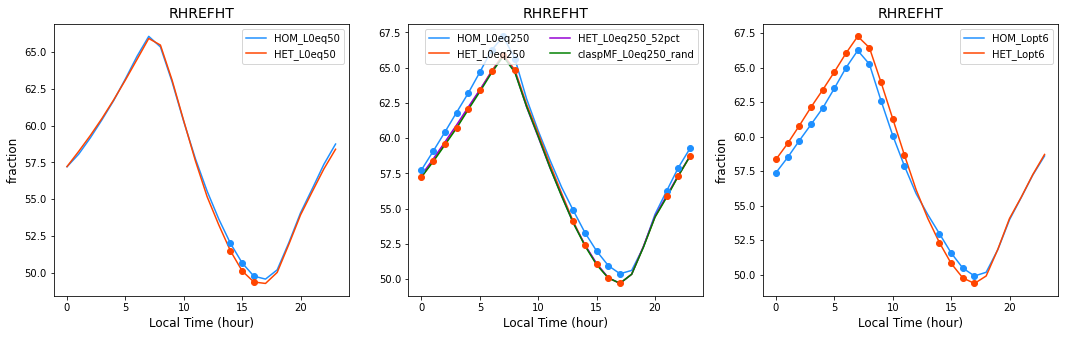

In [19]:
# - - - - - - - - - - - - - - - - - - - - - -
#  Plot mean diurnal cycle with error bars
# - - - - - - - - - - - - - - - - - - - - - - 

varPlot = 'RHREFHT'
yMax    = 300
yMin    = 0
unitsString = scamDS[varPlot].units
# unitsString = 'mm/hr'
setYlims = False

# valueMultiplier = (3600*1e3)
valueMultiplier =  1
# CIlevel = 1.960   ## 95% CI 

plotTests250 = True

# - - - - - - - - - - - - - - - - - 
fig,axs = plt.subplots(1,3, figsize=(18,5))
axs     = axs.ravel()

DS_mean  = (valueMultiplier*scamDS[varPlot]).groupby('time.hour').mean(dim='time')
DS_std   = (valueMultiplier*scamDS[varPlot]).groupby('time.hour').std(dim='time')
DS_count = (valueMultiplier*scamDS[varPlot]).groupby('time.hour').count(dim='time')
DS_SE    = DS_std/np.sqrt(DS_count)

## Paired T-test for significance
pVal_50   = np.full([24], np.nan)
pVal_250  = np.full([24], np.nan)
pVal_Lopt = np.full([24], np.nan)
for iHr in range(24): 
    t,p50 = stats.ttest_rel(scamDS[varPlot].sel(case='clubbMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                            scamDS[varPlot].sel(case='claspMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                            nan_policy = 'omit')
    if p50<0.05: 
        pVal_50[iHr]=1
        
    t,p250 = stats.ttest_rel(scamDS[varPlot].sel(case='clubbMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                             scamDS[varPlot].sel(case='claspMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                             nan_policy = 'omit')
    if p250<0.05: 
        pVal_250[iHr]=1
        
    t,pLopt = stats.ttest_rel(scamDS[varPlot].sel(case='clubbMF_Lopt6_perPlume').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              scamDS[varPlot].sel(case='claspMF_Lopt6_perPlume').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                              nan_policy = 'omit')
    if pLopt<0.05: 
        pVal_Lopt[iHr]=1
        
# - - - - - - - - - - - - - - - - - 
# Plot L0=50 in first panel 
axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq50').values, color='dodgerblue', label='HOM_L0eq50') 
axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq50').values, color='orangered', label='HET_L0eq50') 
axs[0].legend()

axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq50').values*pVal_50, 'o', color='dodgerblue')
axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq50').values*pVal_50, 'o', color='orangered')

# axs[0].fill_between(DS_mean.hour.values, 
#    np.squeeze(DS_mean.sel(case='clubbMF_L0eq50').values-(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq50').values))),
#    np.squeeze(DS_mean.sel(case='clubbMF_L0eq50').values+(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq50').values))),
#    alpha = 0.2, facecolor='dodgerblue',edgecolor='blue')

# axs[0].fill_between(DS_mean.hour.values, 
#    np.squeeze(DS_mean.sel(case='claspMF_L0eq50').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq50').values))),
#    np.squeeze(DS_mean.sel(case='claspMF_L0eq50').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq50').values))),
#    alpha = 0.2, facecolor='orangered',edgecolor='red')

axs[0].set_title(varPlot,fontsize=14)
axs[0].set_ylabel(unitsString, fontsize=12)
axs[0].set_xlabel('Local Time (hour)', fontsize=12)
if setYlims==True: 
    axs[0].set_ylim([yMin, yMax])

# - - - - - - - - - - - - - - - - - 
# Plot L0=250 in second panel 
axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq250').values, color='dodgerblue', label='HOM_L0eq250') 
axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250').values, color='orangered', label='HET_L0eq250') 
if plotTests250==True:
    axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250_52pct').values, color='darkviolet', label='HET_L0eq250_52pct') 
    axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250_rand').values, color='green', label='claspMF_L0eq250_rand') 
    axs[1].legend(ncol=2)
else: 
    axs[1].legend()
    
axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq250').values*pVal_250, 'o', color='dodgerblue')
axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250').values*pVal_250, 'o', color='orangered')

    
# axs[1].fill_between(DS_mean.hour.values, 
#    np.squeeze(DS_mean.sel(case='clubbMF_L0eq250').values-(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq250').values))),
#    np.squeeze(DS_mean.sel(case='clubbMF_L0eq250').values+(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq250').values))),
#    alpha = 0.2, facecolor='dodgerblue',edgecolor='blue')

# axs[1].fill_between(DS_mean.hour.values, 
#    np.squeeze(DS_mean.sel(case='claspMF_L0eq250').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
#    np.squeeze(DS_mean.sel(case='claspMF_L0eq250').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
#    alpha = 0.2, facecolor='orangered',edgecolor='red')

# if plotTests250==True:
#     axs[1].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_52pct').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_52pct').values))),
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_52pct').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
#        alpha = 0.2, facecolor='darkviolet',edgecolor='purple')

#     axs[1].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_rand').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_rand').values))),
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_rand').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_rand').values))),
#        alpha = 0.2, facecolor='green',edgecolor='darkgreen')

axs[1].set_title(varPlot,fontsize=14)
# axs[1].set_ylabel(scamDS[varPlot].units, fontsize=12)
axs[1].set_xlabel('Local Time (hour)', fontsize=12) 
if setYlims==True: 
    axs[1].set_ylim([yMin, yMax])
    
    
# - - - - - - - - - - - - - - - - - 
# Plot Lopt=6 in third panel 
axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_Lopt6_perPlume').values, color='dodgerblue', label='HOM_Lopt6') 
axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_Lopt6_perPlume').values, color='orangered', label='HET_Lopt6') 
axs[2].legend()

axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_Lopt6_perPlume').values*pVal_Lopt, 'o', color='dodgerblue')
axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_Lopt6_perPlume').values*pVal_Lopt, 'o', color='orangered')

# axs[2].fill_between(DS_mean.hour.values, 
#    np.squeeze(DS_mean.sel(case='clubbMF_Lopt6_perPlume').values-(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_Lopt6_perPlume').values))),
#    np.squeeze(DS_mean.sel(case='clubbMF_Lopt6_perPlume').values+(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_Lopt6_perPlume').values))),
#    alpha = 0.2, facecolor='dodgerblue',edgecolor='blue')

# axs[2].fill_between(DS_mean.hour.values, 
#    np.squeeze(DS_mean.sel(case='claspMF_Lopt6_perPlume').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_Lopt6_perPlume').values))),
#    np.squeeze(DS_mean.sel(case='claspMF_Lopt6_perPlume').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_Lopt6_perPlume').values))),
#    alpha = 0.2, facecolor='orangered',edgecolor='red')

axs[2].set_title(varPlot,fontsize=14)
axs[2].set_ylabel(unitsString, fontsize=12)
axs[2].set_xlabel('Local Time (hour)', fontsize=12)
if setYlims==True: 
    axs[2].set_ylim([yMin, yMax])


In [ ]:
hourlyMeanCLM_h2 = clmDS_h2.resample(time='1H').mean().groupby('time.hour').mean(dim='time')


Text(0.5, 0, 'Local Hour')

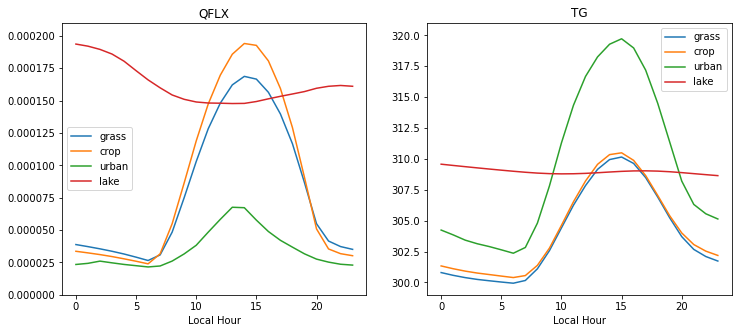

In [22]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs= axs.ravel()

for iLU in range(4):
    axs[0].plot(hourlyMeanCLM_h2.sel(case='clubbMF_Lopt6_perPlume').hour.values, hourlyMeanCLM_h2.sel(case='clubbMF_Lopt6_perPlume').sel(landunit=iLU).QFLX.values)
    axs[1].plot(hourlyMeanCLM_h2.sel(case='clubbMF_Lopt6_perPlume').hour.values, hourlyMeanCLM_h2.sel(case='clubbMF_Lopt6_perPlume').sel(landunit=iLU).TG.values)

axs[0].legend(['grass','crop','urban','lake'])   
axs[1].legend(['grass','crop','urban','lake'])   

axs[0].set_title('QFLX')
axs[1].set_title('TG')

axs[0].set_ylim([0.0, 0.00021])
axs[1].set_ylim([299, 321])

axs[0].set_xlabel('Local Hour')
axs[1].set_xlabel('Local Hour')


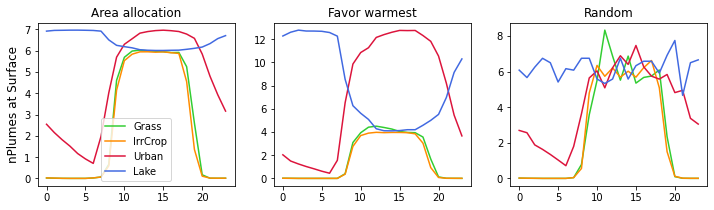

In [37]:
fig,axs = plt.subplots(1,3, figsize=(12,3))
axs     = axs.ravel()

hourlyGrass  = scamDS['nPlumesActive_grass'].isel(levInterp=-1).resample(time='1H').mean().groupby('time.hour').mean(dim='time')
hourlyCrop   = scamDS['nPlumesActive_crop'].isel(levInterp=-1).resample(time='1H').mean().groupby('time.hour').mean(dim='time')
hourlyUrban  = scamDS['nPlumesActive_urban'].isel(levInterp=-1).resample(time='1H').mean().groupby('time.hour').mean(dim='time')
hourlyLake   = scamDS['nPlumesActive_lake'].isel(levInterp=-1).resample(time='1H').mean().groupby('time.hour').mean(dim='time')

axs[0].plot(hourlyGrass.hour.values, hourlyGrass.sel(case='claspMF_L0eq250').values,color='limegreen', label='Grass')
axs[0].plot(hourlyCrop.hour.values,  hourlyCrop.sel(case='claspMF_L0eq250').values,color='darkorange', label='IrrCrop')
axs[0].plot(hourlyUrban.hour.values, hourlyUrban.sel(case='claspMF_L0eq250').values,color='crimson', label='Urban')
axs[0].plot(hourlyLake.hour.values,  hourlyLake.sel(case='claspMF_L0eq250').values,color='royalblue', label='Lake')

axs[1].plot(hourlyGrass.hour.values, hourlyGrass.sel(case='claspMF_L0eq250_52pct').values,color='limegreen', label='Grass')
axs[1].plot(hourlyCrop.hour.values,  hourlyCrop.sel(case='claspMF_L0eq250_52pct').values,color='darkorange', label='IrrCrop')
axs[1].plot(hourlyUrban.hour.values, hourlyUrban.sel(case='claspMF_L0eq250_52pct').values,color='crimson', label='Urban')
axs[1].plot(hourlyLake.hour.values,  hourlyLake.sel(case='claspMF_L0eq250_52pct').values,color='royalblue', label='Lake')

axs[2].plot(hourlyGrass.hour.values, hourlyGrass.sel(case='claspMF_L0eq250_rand').values,color='limegreen', label='Grass')
axs[2].plot(hourlyCrop.hour.values,  hourlyCrop.sel(case='claspMF_L0eq250_rand').values,color='darkorange', label='IrrCrop')
axs[2].plot(hourlyUrban.hour.values, hourlyUrban.sel(case='claspMF_L0eq250_rand').values,color='crimson', label='Urban')
axs[2].plot(hourlyLake.hour.values,  hourlyLake.sel(case='claspMF_L0eq250_rand').values,color='royalblue', label='Lake')

axs[0].set_title('Area allocation', fontsize=12)
axs[1].set_title('Favor warmest', fontsize=12)
axs[2].set_title('Random', fontsize=12)

axs[0].set_ylabel('nPlumes at Surface', fontsize=12)

axs[0].legend()


In [24]:
scamDS

<xarray.Dataset>
Dimensions:                 (case: 8, ilev: 59, lev: 58, levInterp: 78, time: 26496)
Coordinates:
    lat                     float64 36.6
    lon                     float64 262.5
  * ilev                    (ilev) float64 2.055 3.98 6.909 ... 995.1 1e+03
  * time                    (time) datetime64[ns] 2015-06-02T00:03:30 ... 201...
  * lev                     (lev) float64 3.018 5.445 9.087 ... 991.2 997.5
  * levInterp               (levInterp) float64 200.0 210.0 ... 960.0 970.0
  * case                    (case) object 'clubbMF_L0eq50' ... 'claspMF_Lopt6...
Data variables:
    wpthlp                  (case, time, ilev) float32 0.0 ... -0.02764
    wprtp                   (case, time, ilev) float32 0.0 ... 5.742e-05
    rtp2                    (case, time, ilev) float32 1e-16 1e-16 ... 4.773e-09
    thlm                    (case, time, ilev) float32 1.304e+03 ... 308.8
    rtm                     (case, time, ilev) float32 3.75e-06 ... 0.01376
    wm_zm                   (case, time, ilev) float32 0.0 0.0 ... 1.559e-05
    rtm_zm                  (case, time, ilev) float32 3.8e-06 ... 0.01374
    thlm_zm                 (case, time, ilev) float32 1.448e+03 ... 308.8
    SWCF                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LWCF                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TS                      (case, time) float32 299.4 299.4 ... 304.8 304.7
    CLOUD                   (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    FSNS                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FLNS                    (case, time) float32 66.65 0.0 0.0 ... 0.0 0.0 0.0
    PS                      (case, time) float32 9.728e+04 ... 9.716e+04
    QREFHT                  (case, time) float32 0.01464 0.01463 ... 0.01441
    U10                     (case, time) float32 4.585 4.631 ... 7.444 7.438
    CLDHGH                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDLIQ                  (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    CONCLD                  (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    TMQ                     (case, time) float32 41.06 41.07 ... 46.84 46.88
    P0                      (case) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyam                    (case, lev) float64 0.003018 0.005445 ... 0.0
    hybm                    (case, lev) float64 0.0 0.0 0.0 ... 0.9908 0.9975
    hyai                    (case, ilev) float64 0.002055 0.00398 ... 0.0 0.0
    hybi                    (case, ilev) float64 0.0 0.0 0.0 ... 0.9951 1.0
    PHIS                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    USTAR                   (case, time) float32 0.4364 0.4409 ... 0.7022 0.7016
    QT                      (case, time, lev) float32 3.75e-06 ... 0.01376
    GCLDLWP                 (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    THETAL                  (case, time, lev) float32 1.294e+03 ... 306.3
    CDNUMC                  (case, time) float32 4.46 4.221 ... 9.887e-09 0.1001
    CLDBOT                  (case, time) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDLOW                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDMED                  (case, time) float32 0.0 0.0 0.0 ... 0.0 0.0006845
    CLDTOP                  (case, time) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDTOT                  (case, time) float32 0.0 0.0 0.0 ... 0.0 0.0006845
    THLP2_CLUBB             (case, time, ilev) float32 0.0001 ... 0.001106
    CLOUDCOVER_CLUBB        (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    CLOUDFRAC_CLUBB         (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RCM_CLUBB               (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RTP2_CLUBB              (case, time, ilev) float32 1e-10 1e-10 ... 0.004773
    RTPTHLP_CLUBB           (case, time, ilev) float32 0.0 ... -0.001149
    RVMTEND_CLUBB           (case, time, lev) float32 0.0 0.0 

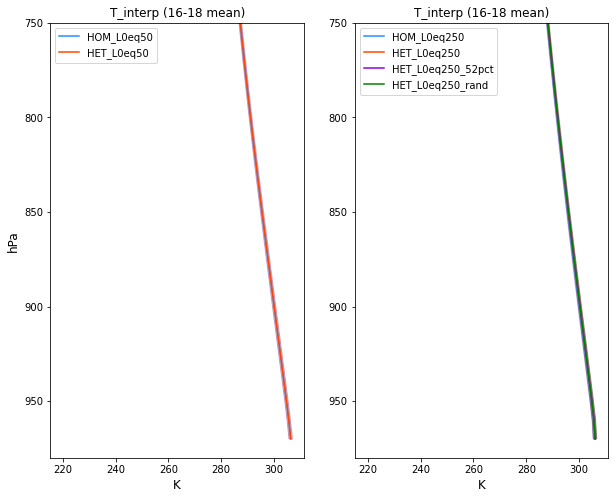

In [208]:
# - - - - - - - - - - - - - - - - - - - - - -
#  Plot mean vertical profiles with error bars
# - - - - - - - - - - - - - - - - - - - - - - 

hrStart = 16
hrEnd   = 18

varPlot = 'T_interp'
use_h2  = False
unitsString = scamDS['T'].units
# unitsString = 'mm/hr'

xMax    = 0.14
xMin    = -0.1
setXlims = False


levMax  = 750.0


# valueMultiplier = (3600*1e3)
valueMultiplier =  1

CIlevel = 1.960   ## 95% CI 

# - - - - - - - - - - - - - - - - - 
## Make the plot - shouldn't need to modify below here 
# - - - - - - - - - - - - - - - - - 
fig,axs = plt.subplots(1,2, figsize=(10,8))
axs     = axs.ravel()

if use_h2==True:
     DS_var = scamDS_h2[varPlot].isel(time=np.where( (scamDS['time.hour'].values>=hrStart) & 
                                                  (scamDS['time.hour'].values<=hrEnd) ) [0]).resample(time='1D').mean()     
else: 
    DS_var = scamDS[varPlot].isel(time=np.where( (scamDS['time.hour'].values>=hrStart) & 
                                                  (scamDS['time.hour'].values<=hrEnd) ) [0]).resample(time='1D').mean()

DS_mean  = (valueMultiplier*DS_var).groupby('time.hour').mean(dim='time')
DS_std   = (valueMultiplier*DS_var).groupby('time.hour').std(dim='time')
DS_count = (valueMultiplier*DS_var).groupby('time.hour').count(dim='time')
DS_SE    = DS_std/np.sqrt(DS_count)

# - - - - - - - - - - - - - - - - - 
# Plot L0=50 in first panel
# - - - - - - - - - - - - - - - - - 
axs[0].plot(np.squeeze(DS_mean.sel(case='clubbMF_L0eq50').values), DS_mean.levInterp.values, color = 'dodgerblue', label='HOM_L0eq50')
axs[0].plot(np.squeeze(DS_mean.sel(case='claspMF_L0eq50').values), DS_mean.levInterp.values, color = 'orangered', label='HET_L0eq50')
axs[0].legend()

axs[0].fill_betweenx(DS_mean.levInterp.values, 
   np.squeeze(DS_mean.sel(case='clubbMF_L0eq50').values-(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq50').values))),
   np.squeeze(DS_mean.sel(case='clubbMF_L0eq50').values+(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq50').values))),
   alpha = 0.2, facecolor='dodgerblue',edgecolor='blue')

axs[0].fill_betweenx(DS_mean.levInterp.values, 
   np.squeeze(DS_mean.sel(case='claspMF_L0eq50').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq50').values))),
   np.squeeze(DS_mean.sel(case='claspMF_L0eq50').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq50').values))),
   alpha = 0.2, facecolor='orangered',edgecolor='red')

axs[0].invert_yaxis()
axs[0].set_title(varPlot+' ('+str(hrStart)+'-'+str(hrEnd)+' mean)')
axs[0].set_ylabel('hPa', fontsize=12)
axs[0].set_xlabel(unitsString,fontsize=12)
axs[0].set_ylim([980,levMax])
if setXlims==True:
    axs[0].set_xlim([xMin, xMax])
    
    
# - - - - - - - - - - - - - - - - - 
# Plot L0=250 in first panel
# - - - - - - - - - - - - - - - - - 
axs[1].plot(np.squeeze(DS_mean.sel(case='clubbMF_L0eq250').values), DS_mean.levInterp.values, color = 'dodgerblue', label='HOM_L0eq250')
axs[1].plot(np.squeeze(DS_mean.sel(case='claspMF_L0eq250').values), DS_mean.levInterp.values, color = 'orangered', label='HET_L0eq250')
axs[1].plot(np.squeeze(DS_mean.sel(case='claspMF_L0eq250_52pct').values), DS_mean.levInterp.values, color = 'darkviolet', label='HET_L0eq250_52pct')
axs[1].plot(np.squeeze(DS_mean.sel(case='claspMF_L0eq250_rand').values), DS_mean.levInterp.values, color = 'green', label='HET_L0eq250_rand')
axs[1].legend()

axs[1].fill_betweenx(DS_mean.levInterp.values, 
   np.squeeze(DS_mean.sel(case='clubbMF_L0eq250').values-(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq250').values))),
   np.squeeze(DS_mean.sel(case='clubbMF_L0eq250').values+(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq250').values))),
   alpha = 0.2, facecolor='dodgerblue',edgecolor='blue')

axs[1].fill_betweenx(DS_mean.levInterp.values, 
   np.squeeze(DS_mean.sel(case='claspMF_L0eq250').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
   np.squeeze(DS_mean.sel(case='claspMF_L0eq250').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
   alpha = 0.2, facecolor='orangered',edgecolor='red')

axs[1].fill_betweenx(DS_mean.levInterp.values, 
   np.squeeze(DS_mean.sel(case='claspMF_L0eq250_52pct').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_52pct').values))),
   np.squeeze(DS_mean.sel(case='claspMF_L0eq250_52pct').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_52pct').values))),
   alpha = 0.2, facecolor='darkviolet',edgecolor='purple')

axs[1].fill_betweenx(DS_mean.levInterp.values, 
   np.squeeze(DS_mean.sel(case='claspMF_L0eq250_rand').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_rand').values))),
   np.squeeze(DS_mean.sel(case='claspMF_L0eq250_rand').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_rand').values))),
   alpha = 0.2, facecolor='green',edgecolor='darkgreen')


axs[1].invert_yaxis()
axs[1].set_title(varPlot+' ('+str(hrStart)+'-'+str(hrEnd)+' mean)')
axs[1].set_xlabel(unitsString,fontsize=12)
axs[1].set_ylim([980,levMax])
if setXlims==True:
    axs[1].set_xlim([xMin, xMax])
    pVal_Lopt

In [116]:
scamDS['wpthlp'].units

'(m K)/s'

**Not totally sure how to work through the time-height plot stuff yet...**

In [32]:
scamDS.case.values

array(['clubbMF_L0eq50', 'claspMF_L0eq50', 'clubbMF_L0eq250',
       'claspMF_L0eq250', 'claspMF_L0eq250_52pct', 'claspMF_L0eq250_rand',
       'clubbMF_Lopt6_perPlume', 'claspMF_Lopt6_perPlume'], dtype=object)

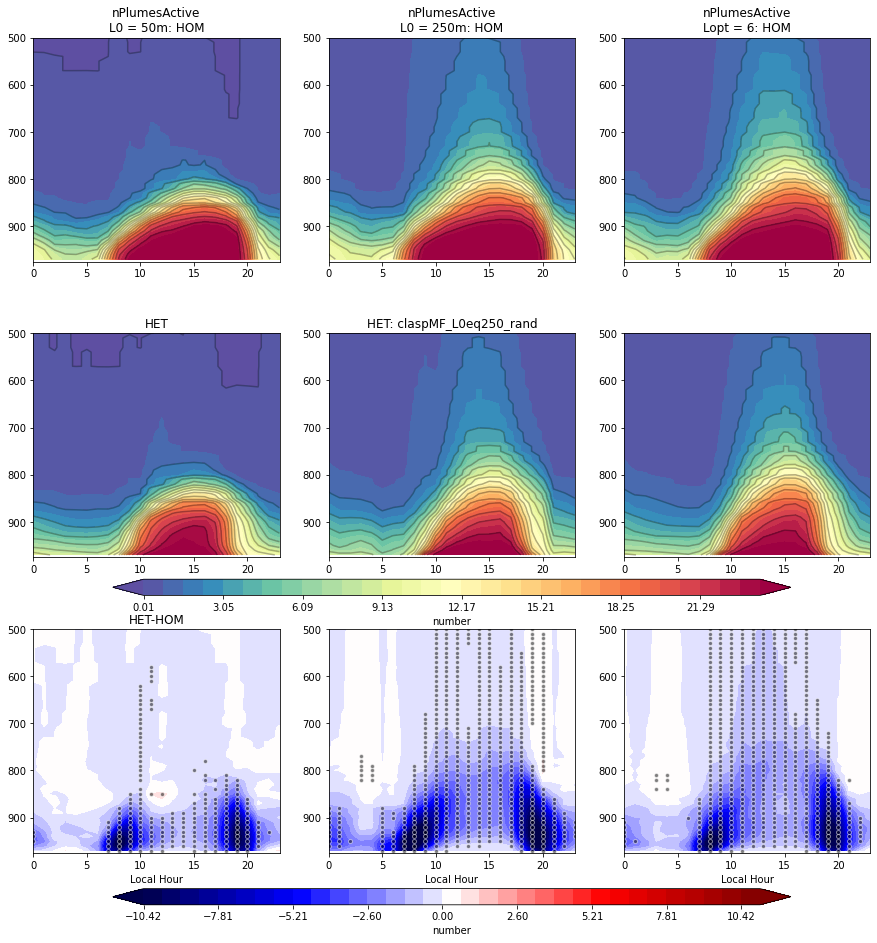

In [34]:
pltVar = 'nPlumesActive'
maxLev = 500.0
# unitsStr = scamDS['WP2_CLUBB'].units
unitsStr = 'number'

clasp25_caseName = 'claspMF_L0eq250_rand'

# unitsStr = 'm/s'
DStoUse = scamDS

# --- Get variables isolated 
homMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
hetMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diff_L0eq50 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean() - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean()).groupby('time.hour').mean(dim='time')

homMean_L0eq250 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
hetMean_L0eq250 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case=clasp25_caseName).resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diff_L0eq250 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case=clasp25_caseName).resample(time='1H').mean() - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean()).groupby('time.hour').mean(dim='time')

homMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
hetMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
diff_Lopt6= (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean() - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean()).groupby('time.hour').mean(dim='time')

# - - - - - - - - - - - - - - - -  
## Paired T-test for significance
# - - - - - - - - - - - - - - - -  
pVal_50   = np.full([24, len(scamDS.levInterp.values)], np.nan)
pVal_250  = np.full([24, len(scamDS.levInterp.values)], np.nan)
pVal_Lopt = np.full([24, len(scamDS.levInterp.values)], np.nan)
for iHr in range(24): 
    # for iLev in range(len(scamDS.levInterp.values)):
        t,p50 = stats.ttest_rel(DStoUse[pltVar].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[pltVar].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                nan_policy = 'omit')
        # if p50<0.05:
        #     pVal_50[iHr,iLev]=1
        iVal50 = np.where(p50<0.05)[0]
        pVal_50[iHr,iVal50]=1

        t,p250 = stats.ttest_rel(DStoUse[pltVar].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 DStoUse[pltVar].sel(case=clasp25_caseName).where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 nan_policy = 'omit')
        # if p250<0.05:
        #     pVal_250[iHr,iLev]=1
        iVal250 = np.where(p250<0.05)[0]
        pVal_250[iHr,iVal250]=1

        t,pLopt = stats.ttest_rel(DStoUse[pltVar].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                  DStoUse[pltVar].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                  nan_policy = 'omit')
        # if pLopt<0.05:
        #     pVal_Lopt[iHr,iLev]=1 
        iValLopt = np.where(pLopt<0.05)[0]
        pVal_Lopt[iHr,iValLopt]=1


# --- Figure out cbar limits? 
minLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).groupby('time.hour').mean(dim='time').values, 2)
maxLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).groupby('time.hour').mean(dim='time').values, 98)
cbarLims_rawVals = np.arange(minLim, maxLim, (maxLim-minLim)/32)

minLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values],  1)
maxLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values], 99)
diffLimAbs = np.nanmax([np.abs(minLimDiff), np.abs(maxLimDiff)])
nstep = (2*diffLimAbs)/32
cbarLims_diffs = np.arange(-diffLimAbs, diffLimAbs+nstep, nstep)

# ---- What about the actual plots? 
fig,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.ravel()


# - - - - - - - - - - - - - - - -  
#  L0 = 50 m 
# - - - - - - - - - - - - - - - -  
axs[0].contourf(homMean_L0eq50.hour.values, homMean_L0eq50.levInterp.values, 
                np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[0].contour(homMean_L0eq50.hour.values, homMean_L0eq50.levInterp.values, 
               np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[3].contourf(hetMean_L0eq50.hour.values, hetMean_L0eq50.levInterp.values, 
                np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[3].contour(hetMean_L0eq50.hour.values, hetMean_L0eq50.levInterp.values, 
               np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[6].contourf(diff_L0eq50.hour.values, diff_L0eq50.levInterp.values, 
                np.squeeze(diff_L0eq50.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_50[iHr,iLev]==1:
            axs[6].plot(diff_L0eq50.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


            
# - - - - - - - - - - - - - - - -  
#  L0 = 250 m 
# - - - - - - - - - - - - - - - -  
axs[1].contourf(homMean_L0eq250.hour.values, homMean_L0eq250.levInterp.values, 
                np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[1].contour(homMean_L0eq250.hour.values, homMean_L0eq250.levInterp.values, 
               np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

cplt=axs[4].contourf(hetMean_L0eq250.hour.values, hetMean_L0eq250.levInterp.values, 
                np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.028, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)
# Add contour lines
axs[4].contour(hetMean_L0eq250.hour.values, hetMean_L0eq250.levInterp.values, 
               np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )


cplt=axs[7].contourf(diff_L0eq250.hour.values, diff_L0eq250.levInterp.values, 
                np.squeeze(diff_L0eq250.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')
# Add colorbar
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.048, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_250[iHr,iLev]==1:
            axs[7].plot(diff_L0eq250.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')            
            

            
# - - - - - - - - - - - - - - - -  
#  Lopt = 6 (per plume)
# - - - - - - - - - - - - - - - -  
axs[2].contourf(homMean_Lopt6.hour.values, homMean_Lopt6.levInterp.values, 
                np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[2].contour(homMean_Lopt6.hour.values, homMean_Lopt6.levInterp.values, 
               np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[5].contourf(hetMean_Lopt6.hour.values, hetMean_Lopt6.levInterp.values, 
                np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[5].contour(hetMean_Lopt6.hour.values, hetMean_Lopt6.levInterp.values, 
               np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[8].contourf(diff_Lopt6.hour.values, diff_Lopt6.levInterp.values, 
                np.squeeze(diff_Lopt6.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_Lopt[iHr,iLev]==1:
            axs[8].plot(diff_Lopt6.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


axs[0].set_title(pltVar+'\nL0 = 50m: HOM')
axs[3].set_title('HET')
axs[6].set_title('HET-HOM')
axs[1].set_title(pltVar+'\nL0 = 250m: HOM')
axs[2].set_title(pltVar+'\nLopt = 6: HOM')
axs[4].set_title('HET: '+clasp25_caseName)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()
axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()

axs[0].set_ylim([975,maxLev])
axs[1].set_ylim([975,maxLev])
axs[2].set_ylim([975,maxLev])
axs[3].set_ylim([975,maxLev])
axs[4].set_ylim([975,maxLev])
axs[5].set_ylim([975,maxLev])
axs[6].set_ylim([975,maxLev])
axs[7].set_ylim([975,maxLev])
axs[8].set_ylim([975,maxLev])

axs[6].set_xlabel('Local Hour')
axs[7].set_xlabel('Local Hour')
axs[8].set_xlabel('Local Hour')

fig.subplots_adjust(hspace=0.32)


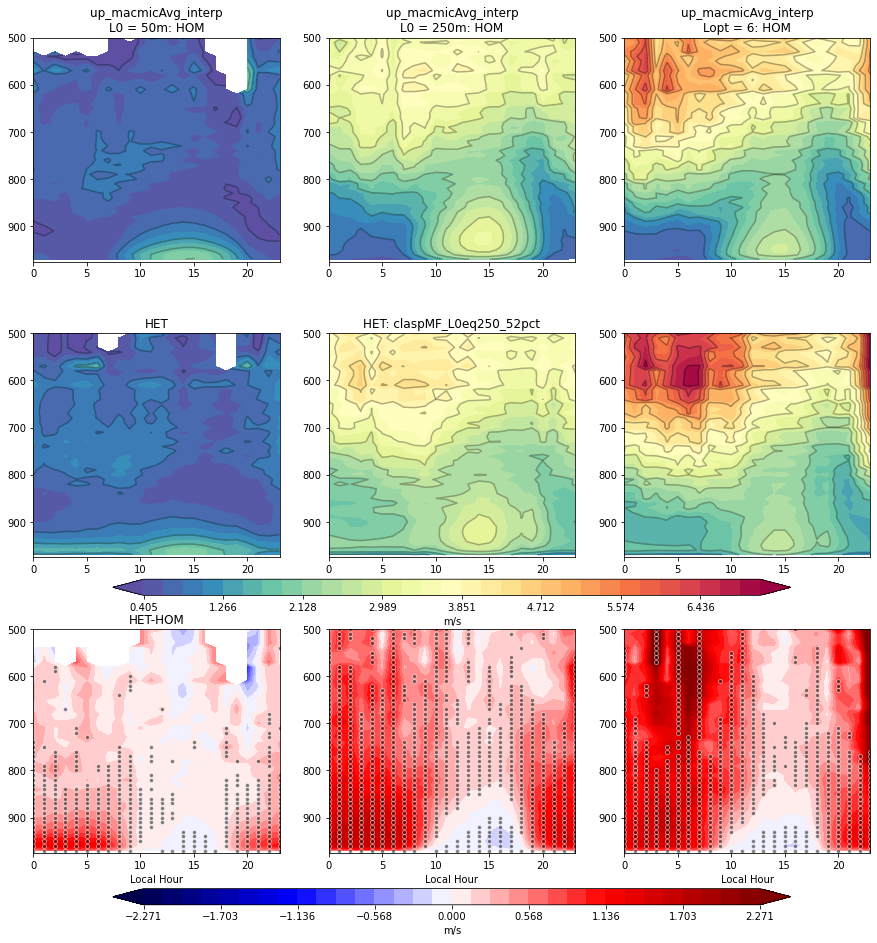

In [36]:
# - - - - - - - - - - - - - - - -  
## This is for when we need to weight the plumes
# - - - - - - - - - - - - - - - -  

pltVar = 'up_macmicAvg_interp'
maxLev = 500.0
# unitsStr = scamDS_h2['edmf_upent'].units
unitsStr = 'm/s'
DStoUse = scamDS_h2

clasp25_caseName = 'claspMF_L0eq250_52pct'
# clasp25_caseName = 'claspMF_L0eq250_rand'


# --- Get variables isolated 
HOMwgts50 = DStoUse.upa_macmicAvg_interp.sel(case='clubbMF_L0eq50').resample(time='1H').mean().fillna(0)
HETwgts50 = DStoUse.upa_macmicAvg_interp.sel(case='claspMF_L0eq50').resample(time='1H').mean().fillna(0)
homMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_L0eq50 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens')).groupby('time.hour').mean(dim='time')

HOMwgts250 = DStoUse.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').resample(time='1H').mean().fillna(0)
HETwgts250 = DStoUse.upa_macmicAvg_interp.sel(case=clasp25_caseName).resample(time='1H').mean().fillna(0)
homMean_L0eq250 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_L0eq250 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case=clasp25_caseName).resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_L0eq250 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case=clasp25_caseName).resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens')).groupby('time.hour').mean(dim='time')

HOMwgtsLopt6 = DStoUse.upa_macmicAvg_interp.sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().fillna(0)
HETwgtsLopt6 = DStoUse.upa_macmicAvg_interp.sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().fillna(0)
homMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_Lopt6 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens')).groupby('time.hour').mean(dim='time')

# homMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').groupby('time.hour').mean(dim='time')
# hetMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').groupby('time.hour').mean(dim='time')
# diff_Lopt6= (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume')).groupby('time.hour').mean(dim='time')

# - - - - - - - - - - - - - - - -  
## Paired T-test for significance
# - - - - - - - - - - - - - - - -  
pVal_50   = np.full([24, len(DStoUse.levInterp.values)], np.nan)
pVal_250  = np.full([24, len(DStoUse.levInterp.values)], np.nan)
pVal_Lopt = np.full([24, len(DStoUse.levInterp.values)], np.nan)
for iHr in range(24): 
    # for iLev in range(len(scamDS.levInterp.values)):
        HOMwgts50 = DStoUse.upa_macmicAvg_interp.sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgts50 = DStoUse.upa_macmicAvg_interp.sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,p50 = stats.ttest_rel(
                              # DStoUse[pltVar].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[pltVar].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens'),
                                DStoUse[pltVar].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens'),
                                # DStoUse[pltVar].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                nan_policy = 'omit')
        # if p50<0.05:
        #     pVal_50[iHr,iLev]=1
        iVal50 = np.where(p50<0.05)[0]
        pVal_50[iHr,iVal50]=1

        
        HOMwgts250 = DStoUse.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgts250 = DStoUse.upa_macmicAvg_interp.sel(case=clasp25_caseName).where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,p250 = stats.ttest_rel(
                                 # DStoUse[pltVar].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[pltVar].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens'),
                                DStoUse[pltVar].sel(case=clasp25_caseName).where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens'),

                                # DStoUse[pltVar].sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 nan_policy = 'omit')
        # if p250<0.05:
        #     pVal_250[iHr,iLev]=1
        iVal250 = np.where(p250<0.05)[0]
        pVal_250[iHr,iVal250]=1

        
        HOMwgtsLopt6 = DStoUse.upa_macmicAvg_interp.sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgtsLopt6 = DStoUse.upa_macmicAvg_interp.sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,pLopt = stats.ttest_rel(
                                 #DStoUse[pltVar].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 DStoUse[pltVar].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens'),
                                 DStoUse[pltVar].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens'),
                                 # DStoUse[pltVar].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                  nan_policy = 'omit')
        # if pLopt<0.05:
        #     pVal_Lopt[iHr,iLev]=1 
        iValLopt = np.where(pLopt<0.05)[0]
        pVal_Lopt[iHr,iValLopt]=1


# --- Figure out cbar limits? 
minLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).groupby('time.hour').mean(dim='time').values, 2)
maxLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).groupby('time.hour').mean(dim='time').values, 98)
cbarLims_rawVals = np.arange(minLim, maxLim, (maxLim-minLim)/32)

minLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values],  1)
maxLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values], 99)
diffLimAbs = np.nanmax([np.abs(minLimDiff), np.abs(maxLimDiff)])
nstep = (2*diffLimAbs)/32
cbarLims_diffs = np.arange(-diffLimAbs, diffLimAbs+nstep, nstep)

# ---- What about the actual plots? 
fig,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.ravel()


# - - - - - - - - - - - - - - - -  
#  L0 = 50 m 
# - - - - - - - - - - - - - - - -  
axs[0].contourf(homMean_L0eq50.hour.values, homMean_L0eq50.levInterp.values, 
                np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[0].contour(homMean_L0eq50.hour.values, homMean_L0eq50.levInterp.values, 
               np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[3].contourf(hetMean_L0eq50.hour.values, hetMean_L0eq50.levInterp.values, 
                np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[3].contour(hetMean_L0eq50.hour.values, hetMean_L0eq50.levInterp.values, 
               np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[6].contourf(diff_L0eq50.hour.values, diff_L0eq50.levInterp.values, 
                np.squeeze(diff_L0eq50.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_50[iHr,iLev]==1:
            axs[6].plot(diff_L0eq50.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


            
# - - - - - - - - - - - - - - - -  
#  L0 = 250 m 
# - - - - - - - - - - - - - - - -  
axs[1].contourf(homMean_L0eq250.hour.values, homMean_L0eq250.levInterp.values, 
                np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[1].contour(homMean_L0eq250.hour.values, homMean_L0eq250.levInterp.values, 
               np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

cplt=axs[4].contourf(hetMean_L0eq250.hour.values, hetMean_L0eq250.levInterp.values, 
                np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.028, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)
# Add contour lines
axs[4].contour(hetMean_L0eq250.hour.values, hetMean_L0eq250.levInterp.values, 
               np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )


cplt=axs[7].contourf(diff_L0eq250.hour.values, diff_L0eq250.levInterp.values, 
                np.squeeze(diff_L0eq250.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')
# Add colorbar
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.048, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_250[iHr,iLev]==1:
            axs[7].plot(diff_L0eq250.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')            
            

            
# - - - - - - - - - - - - - - - -  
#  Lopt = 6 (per plume)
# - - - - - - - - - - - - - - - -  
axs[2].contourf(homMean_Lopt6.hour.values, homMean_Lopt6.levInterp.values, 
                np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[2].contour(homMean_Lopt6.hour.values, homMean_Lopt6.levInterp.values, 
               np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[5].contourf(hetMean_Lopt6.hour.values, hetMean_Lopt6.levInterp.values, 
                np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[5].contour(hetMean_Lopt6.hour.values, hetMean_Lopt6.levInterp.values, 
               np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[8].contourf(diff_Lopt6.hour.values, diff_Lopt6.levInterp.values, 
                np.squeeze(diff_Lopt6.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_Lopt[iHr,iLev]==1:
            axs[8].plot(diff_Lopt6.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


axs[0].set_title(pltVar+'\nL0 = 50m: HOM')
axs[3].set_title('HET')
axs[6].set_title('HET-HOM')
axs[1].set_title(pltVar+'\nL0 = 250m: HOM')
axs[2].set_title(pltVar+'\nLopt = 6: HOM')
axs[4].set_title('HET: '+clasp25_caseName)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()
axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()

axs[0].set_ylim([975,maxLev])
axs[1].set_ylim([975,maxLev])
axs[2].set_ylim([975,maxLev])
axs[3].set_ylim([975,maxLev])
axs[4].set_ylim([975,maxLev])
axs[5].set_ylim([975,maxLev])
axs[6].set_ylim([975,maxLev])
axs[7].set_ylim([975,maxLev])
axs[8].set_ylim([975,maxLev])

axs[6].set_xlabel('Local Hour')
axs[7].set_xlabel('Local Hour')
axs[8].set_xlabel('Local Hour')

fig.subplots_adjust(hspace=0.32)


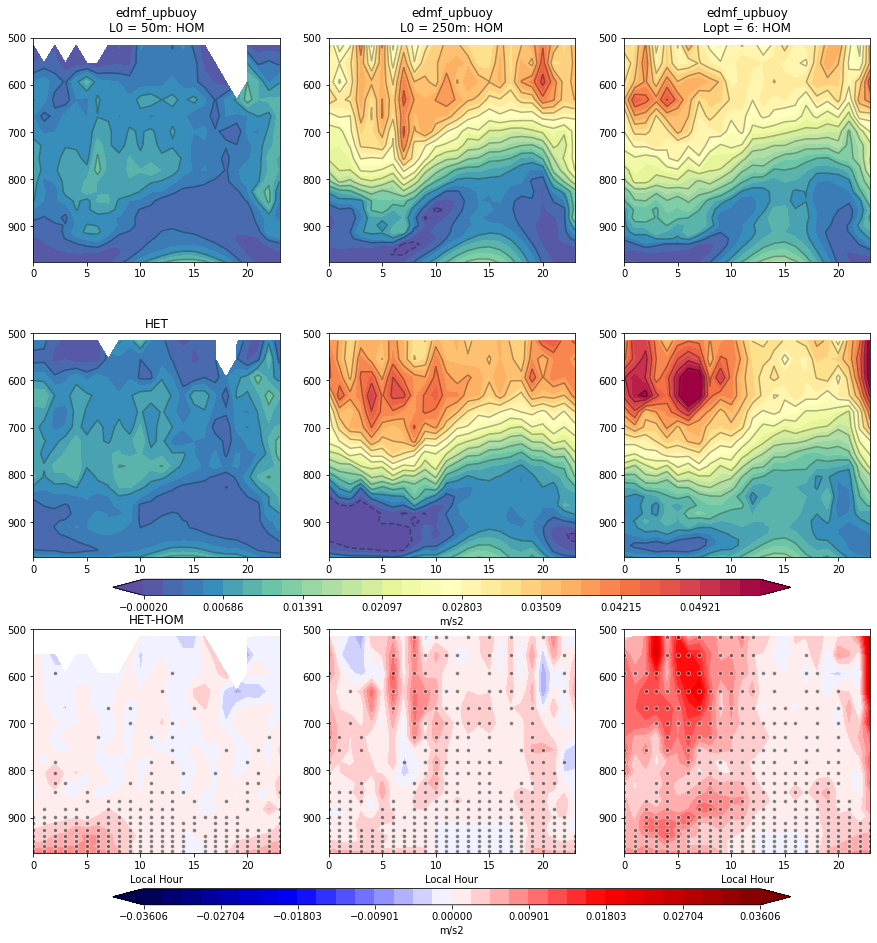

In [26]:
pltVar = 'edmf_upbuoy'
maxLev = 500.0
unitsStr = scamDS_h2['edmf_upbuoy'].units
# unitsStr = 'm/s'
DStoUse = scamDS_h2

# --- Get variables isolated 
HOMwgts50 = DStoUse.edmf_upa.sel(case='clubbMF_L0eq50').resample(time='1H').mean().fillna(0)
HETwgts50 = DStoUse.edmf_upa.sel(case='claspMF_L0eq50').resample(time='1H').mean().fillna(0)
homMean_L0eq50 = DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_L0eq50 = DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_L0eq50 = (DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens')).groupby('time.hour').mean(dim='time')

HOMwgts250 = DStoUse.edmf_upa.sel(case='clubbMF_L0eq250').resample(time='1H').mean().fillna(0)
HETwgts250 = DStoUse.edmf_upa.sel(case='claspMF_L0eq250').resample(time='1H').mean().fillna(0)
homMean_L0eq250 = DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_L0eq250 = DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='claspMF_L0eq250').resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_L0eq250 = (DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='claspMF_L0eq250').resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens')).groupby('time.hour').mean(dim='time')

HOMwgtsLopt6 = DStoUse.edmf_upa.sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().fillna(0)
HETwgtsLopt6 = DStoUse.edmf_upa.sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().fillna(0)
homMean_Lopt6 = DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_Lopt6 = DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_Lopt6 = (DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens')).groupby('time.hour').mean(dim='time')

# homMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').groupby('time.hour').mean(dim='time')
# hetMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').groupby('time.hour').mean(dim='time')
# diff_Lopt6= (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume')).groupby('time.hour').mean(dim='time')

# - - - - - - - - - - - - - - - -  
## Paired T-test for significance
# - - - - - - - - - - - - - - - -  
pVal_50   = np.full([24, len(DStoUse.ilev.values)], np.nan)
pVal_250  = np.full([24, len(DStoUse.ilev.values)], np.nan)
pVal_Lopt = np.full([24, len(DStoUse.ilev.values)], np.nan)
for iHr in range(24): 
    # for iLev in range(len(scamDS.levInterp.values)):
        HOMwgts50 = DStoUse.edmf_upa.sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgts50 = DStoUse.edmf_upa.sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,p50 = stats.ttest_rel(
                              # DStoUse[pltVar].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[pltVar].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens'),
                                DStoUse[pltVar].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens'),
                                # DStoUse[pltVar].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                nan_policy = 'omit')
        # if p50<0.05:
        #     pVal_50[iHr,iLev]=1
        iVal50 = np.where(p50<0.05)[0]
        pVal_50[iHr,iVal50]=1

        
        HOMwgts250 = DStoUse.edmf_upa.sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgts250 = DStoUse.edmf_upa.sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,p250 = stats.ttest_rel(
                                 # DStoUse[pltVar].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[pltVar].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens'),
                                DStoUse[pltVar].sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens'),

                                # DStoUse[pltVar].sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 nan_policy = 'omit')
        # if p250<0.05:
        #     pVal_250[iHr,iLev]=1
        iVal250 = np.where(p250<0.05)[0]
        pVal_250[iHr,iVal250]=1

        
        HOMwgtsLopt6 = DStoUse.edmf_upa.sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgtsLopt6 = DStoUse.edmf_upa.sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,pLopt = stats.ttest_rel(
                                 #DStoUse[pltVar].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 DStoUse[pltVar].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens'),
                                 DStoUse[pltVar].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens'),
                                 # DStoUse[pltVar].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                  nan_policy = 'omit')
        # if pLopt<0.05:
        #     pVal_Lopt[iHr,iLev]=1 
        iValLopt = np.where(pLopt<0.05)[0]
        pVal_Lopt[iHr,iValLopt]=1


# --- Figure out cbar limits? 
minLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).groupby('time.hour').mean(dim='time').values, 2)
maxLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.ilev.values>=maxLev).groupby('time.hour').mean(dim='time').values, 98)
cbarLims_rawVals = np.arange(minLim, maxLim, (maxLim-minLim)/32)

minLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values],  1)
maxLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values], 99)
diffLimAbs = np.nanmax([np.abs(minLimDiff), np.abs(maxLimDiff)])
nstep = (2*diffLimAbs)/32
cbarLims_diffs = np.arange(-diffLimAbs, diffLimAbs+nstep, nstep)

# ---- What about the actual plots? 
fig,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.ravel()


# - - - - - - - - - - - - - - - -  
#  L0 = 50 m 
# - - - - - - - - - - - - - - - -  
axs[0].contourf(homMean_L0eq50.hour.values, homMean_L0eq50.ilev.values, 
                np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[0].contour(homMean_L0eq50.hour.values, homMean_L0eq50.ilev.values, 
               np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[3].contourf(hetMean_L0eq50.hour.values, hetMean_L0eq50.ilev.values, 
                np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[3].contour(hetMean_L0eq50.hour.values, hetMean_L0eq50.ilev.values, 
               np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[6].contourf(diff_L0eq50.hour.values, diff_L0eq50.ilev.values, 
                np.squeeze(diff_L0eq50.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.ilev.values)):
        if pVal_50[iHr,iLev]==1:
            axs[6].plot(diff_L0eq50.hour.values[iHr], scamDS.ilev.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


            
# - - - - - - - - - - - - - - - -  
#  L0 = 250 m 
# - - - - - - - - - - - - - - - -  
axs[1].contourf(homMean_L0eq250.hour.values, homMean_L0eq250.ilev.values, 
                np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[1].contour(homMean_L0eq250.hour.values, homMean_L0eq250.ilev.values, 
               np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

cplt=axs[4].contourf(hetMean_L0eq250.hour.values, hetMean_L0eq250.ilev.values, 
                np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.028, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)
# Add contour lines
axs[4].contour(hetMean_L0eq250.hour.values, hetMean_L0eq250.ilev.values, 
               np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )


cplt=axs[7].contourf(diff_L0eq250.hour.values, diff_L0eq250.ilev.values, 
                np.squeeze(diff_L0eq250.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')
# Add colorbar
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.048, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.ilev.values)):
        if pVal_250[iHr,iLev]==1:
            axs[7].plot(diff_L0eq250.hour.values[iHr], scamDS.ilev.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')            
            

            
# - - - - - - - - - - - - - - - -  
#  Lopt = 6 (per plume)
# - - - - - - - - - - - - - - - -  
axs[2].contourf(homMean_Lopt6.hour.values, homMean_Lopt6.ilev.values, 
                np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[2].contour(homMean_Lopt6.hour.values, homMean_Lopt6.ilev.values, 
               np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[5].contourf(hetMean_Lopt6.hour.values, hetMean_Lopt6.ilev.values, 
                np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[5].contour(hetMean_Lopt6.hour.values, hetMean_Lopt6.ilev.values, 
               np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[8].contourf(diff_Lopt6.hour.values, diff_Lopt6.ilev.values, 
                np.squeeze(diff_Lopt6.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.ilev.values)):
        if pVal_Lopt[iHr,iLev]==1:
            axs[8].plot(diff_Lopt6.hour.values[iHr], scamDS.ilev.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


axs[0].set_title(pltVar+'\nL0 = 50m: HOM')
axs[3].set_title('HET')
axs[6].set_title('HET-HOM')
axs[1].set_title(pltVar+'\nL0 = 250m: HOM')
axs[2].set_title(pltVar+'\nLopt = 6: HOM')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()
axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()

axs[0].set_ylim([975,maxLev])
axs[1].set_ylim([975,maxLev])
axs[2].set_ylim([975,maxLev])
axs[3].set_ylim([975,maxLev])
axs[4].set_ylim([975,maxLev])
axs[5].set_ylim([975,maxLev])
axs[6].set_ylim([975,maxLev])
axs[7].set_ylim([975,maxLev])
axs[8].set_ylim([975,maxLev])

axs[6].set_xlabel('Local Hour')
axs[7].set_xlabel('Local Hour')
axs[8].set_xlabel('Local Hour')

fig.subplots_adjust(hspace=0.32)


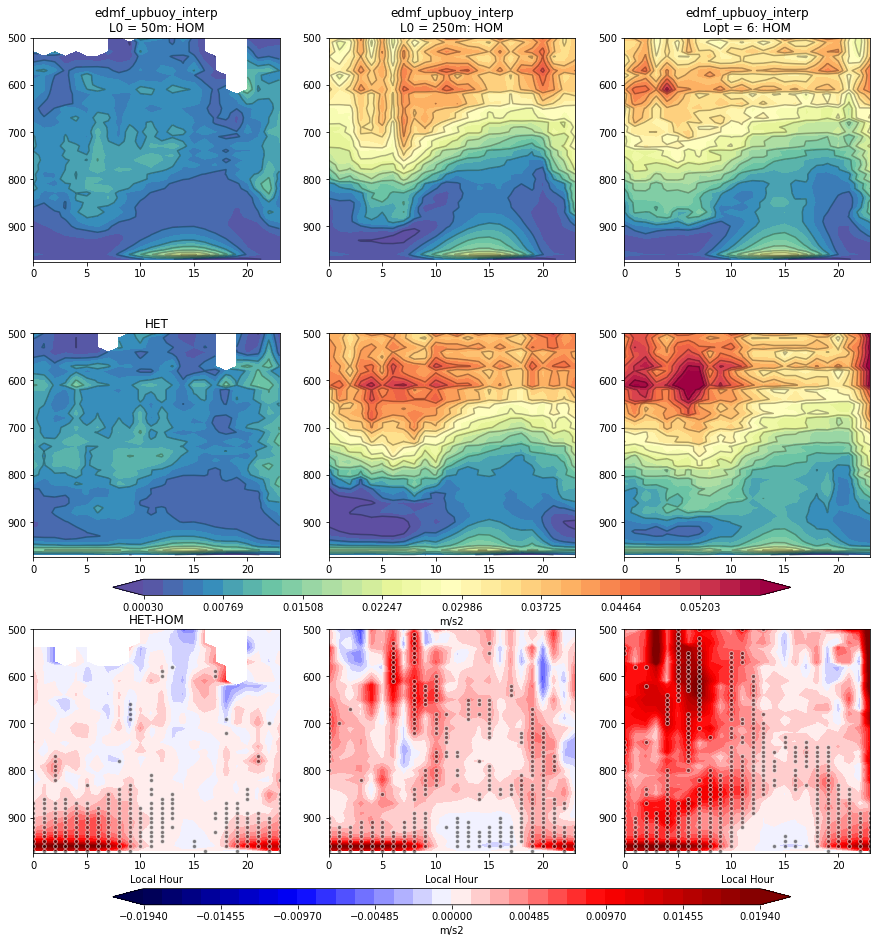

In [30]:
# - - - - - - - - - - - - - - - -  
## This is for when we need to weight the plumes
# - - - - - - - - - - - - - - - -  

pltVar = 'edmf_upbuoy_interp'
maxLev = 500.0
unitsStr = scamDS_h2['edmf_upbuoy'].units
# unitsStr = 'm/s'
DStoUse = scamDS_h2

# --- Get variables isolated 
HOMwgts50 = DStoUse.edmf_upa_interp.sel(case='clubbMF_L0eq50').resample(time='1H').mean().fillna(0)
HETwgts50 = DStoUse.edmf_upa_interp.sel(case='claspMF_L0eq50').resample(time='1H').mean().fillna(0)
homMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_L0eq50 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_L0eq50 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq50').resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq50').resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens')).groupby('time.hour').mean(dim='time')

HOMwgts250 = DStoUse.edmf_upa_interp.sel(case='clubbMF_L0eq250').resample(time='1H').mean().fillna(0)
HETwgts250 = DStoUse.edmf_upa_interp.sel(case='claspMF_L0eq250').resample(time='1H').mean().fillna(0)
homMean_L0eq250 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_L0eq250 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq250').resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_L0eq250 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_L0eq250').resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_L0eq250').resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens')).groupby('time.hour').mean(dim='time')

HOMwgtsLopt6 = DStoUse.edmf_upa_interp.sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().fillna(0)
HETwgtsLopt6 = DStoUse.edmf_upa_interp.sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().fillna(0)
homMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens').groupby('time.hour').mean(dim='time')
hetMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens').groupby('time.hour').mean(dim='time')
diff_Lopt6 = (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens')).groupby('time.hour').mean(dim='time')

# homMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume').groupby('time.hour').mean(dim='time')
# hetMean_Lopt6 = DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume').groupby('time.hour').mean(dim='time')
# diff_Lopt6= (DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='claspMF_Lopt6_perPlume') - DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).sel(case='clubbMF_Lopt6_perPlume')).groupby('time.hour').mean(dim='time')

# - - - - - - - - - - - - - - - -  
## Paired T-test for significance
# - - - - - - - - - - - - - - - -  
pVal_50   = np.full([24, len(DStoUse.levInterp.values)], np.nan)
pVal_250  = np.full([24, len(DStoUse.levInterp.values)], np.nan)
pVal_Lopt = np.full([24, len(DStoUse.levInterp.values)], np.nan)
for iHr in range(24): 
    # for iLev in range(len(scamDS.levInterp.values)):
        HOMwgts50 = DStoUse.edmf_upa_interp.sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgts50 = DStoUse.edmf_upa_interp.sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,p50 = stats.ttest_rel(
                              # DStoUse[pltVar].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[pltVar].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgts50).mean(dim='nens'),
                                DStoUse[pltVar].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgts50).mean(dim='nens'),
                                # DStoUse[pltVar].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                nan_policy = 'omit')
        # if p50<0.05:
        #     pVal_50[iHr,iLev]=1
        iVal50 = np.where(p50<0.05)[0]
        pVal_50[iHr,iVal50]=1

        
        HOMwgts250 = DStoUse.edmf_upa_interp.sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgts250 = DStoUse.edmf_upa_interp.sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,p250 = stats.ttest_rel(
                                 # DStoUse[pltVar].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[pltVar].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgts250).mean(dim='nens'),
                                DStoUse[pltVar].sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgts250).mean(dim='nens'),

                                # DStoUse[pltVar].sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 nan_policy = 'omit')
        # if p250<0.05:
        #     pVal_250[iHr,iLev]=1
        iVal250 = np.where(p250<0.05)[0]
        pVal_250[iHr,iVal250]=1

        
        HOMwgtsLopt6 = DStoUse.edmf_upa_interp.sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)
        HETwgtsLopt6 = DStoUse.edmf_upa_interp.sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().fillna(0)

        t,pLopt = stats.ttest_rel(
                                 #DStoUse[pltVar].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 DStoUse[pltVar].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HOMwgtsLopt6).mean(dim='nens'),
                                 DStoUse[pltVar].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().weighted(HETwgtsLopt6).mean(dim='nens'),
                                 # DStoUse[pltVar].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                  nan_policy = 'omit')
        # if pLopt<0.05:
        #     pVal_Lopt[iHr,iLev]=1 
        iValLopt = np.where(pLopt<0.05)[0]
        pVal_Lopt[iHr,iValLopt]=1


# --- Figure out cbar limits? 
minLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).groupby('time.hour').mean(dim='time').values, 2)
maxLim = np.nanpercentile(DStoUse[pltVar].where(DStoUse.levInterp.values>=maxLev).groupby('time.hour').mean(dim='time').values, 98)
cbarLims_rawVals = np.arange(minLim, maxLim, (maxLim-minLim)/32)

minLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values],  1)
maxLimDiff = np.nanpercentile([diff_L0eq50.values, diff_L0eq250.values, diff_Lopt6.values], 99)
diffLimAbs = np.nanmax([np.abs(minLimDiff), np.abs(maxLimDiff)])
nstep = (2*diffLimAbs)/32
cbarLims_diffs = np.arange(-diffLimAbs, diffLimAbs+nstep, nstep)

# ---- What about the actual plots? 
fig,axs = plt.subplots(3,3, figsize=(15,15))
axs = axs.ravel()


# - - - - - - - - - - - - - - - -  
#  L0 = 50 m 
# - - - - - - - - - - - - - - - -  
axs[0].contourf(homMean_L0eq50.hour.values, homMean_L0eq50.levInterp.values, 
                np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[0].contour(homMean_L0eq50.hour.values, homMean_L0eq50.levInterp.values, 
               np.squeeze(homMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[3].contourf(hetMean_L0eq50.hour.values, hetMean_L0eq50.levInterp.values, 
                np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[3].contour(hetMean_L0eq50.hour.values, hetMean_L0eq50.levInterp.values, 
               np.squeeze(hetMean_L0eq50.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[6].contourf(diff_L0eq50.hour.values, diff_L0eq50.levInterp.values, 
                np.squeeze(diff_L0eq50.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_50[iHr,iLev]==1:
            axs[6].plot(diff_L0eq50.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


            
# - - - - - - - - - - - - - - - -  
#  L0 = 250 m 
# - - - - - - - - - - - - - - - -  
axs[1].contourf(homMean_L0eq250.hour.values, homMean_L0eq250.levInterp.values, 
                np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[1].contour(homMean_L0eq250.hour.values, homMean_L0eq250.levInterp.values, 
               np.squeeze(homMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

cplt=axs[4].contourf(hetMean_L0eq250.hour.values, hetMean_L0eq250.levInterp.values, 
                np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.028, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)
# Add contour lines
axs[4].contour(hetMean_L0eq250.hour.values, hetMean_L0eq250.levInterp.values, 
               np.squeeze(hetMean_L0eq250.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )


cplt=axs[7].contourf(diff_L0eq250.hour.values, diff_L0eq250.levInterp.values, 
                np.squeeze(diff_L0eq250.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')
# Add colorbar
ax_position = axs[7].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.048, ax_position.width+0.4, 0.015])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsStr)

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_250[iHr,iLev]==1:
            axs[7].plot(diff_L0eq250.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')            
            

            
# - - - - - - - - - - - - - - - -  
#  Lopt = 6 (per plume)
# - - - - - - - - - - - - - - - -  
axs[2].contourf(homMean_Lopt6.hour.values, homMean_Lopt6.levInterp.values, 
                np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[2].contour(homMean_Lopt6.hour.values, homMean_Lopt6.levInterp.values, 
               np.squeeze(homMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[5].contourf(hetMean_Lopt6.hour.values, hetMean_Lopt6.levInterp.values, 
                np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals, 
                cmap='Spectral_r',extend='both')
# Add contour lines
axs[5].contour(hetMean_Lopt6.hour.values, hetMean_Lopt6.levInterp.values, 
               np.squeeze(hetMean_Lopt6.values).transpose(), cbarLims_rawVals[::2], colors='k', alpha=0.3 )

axs[8].contourf(diff_Lopt6.hour.values, diff_Lopt6.levInterp.values, 
                np.squeeze(diff_Lopt6.values).transpose(), cbarLims_diffs, 
                cmap='seismic',extend='both')

## Add significance test?
for iHr in range(24): 
    for iLev in range(len(scamDS.levInterp.values)):
        if pVal_Lopt[iHr,iLev]==1:
            axs[8].plot(diff_Lopt6.hour.values[iHr], scamDS.levInterp.values[iLev],'ko',alpha=0.5,markersize=4,markeredgecolor='white')


axs[0].set_title(pltVar+'\nL0 = 50m: HOM')
axs[3].set_title('HET')
axs[6].set_title('HET-HOM')
axs[1].set_title(pltVar+'\nL0 = 250m: HOM')
axs[2].set_title(pltVar+'\nLopt = 6: HOM')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()
axs[6].invert_yaxis()
axs[7].invert_yaxis()
axs[8].invert_yaxis()

axs[0].set_ylim([975,maxLev])
axs[1].set_ylim([975,maxLev])
axs[2].set_ylim([975,maxLev])
axs[3].set_ylim([975,maxLev])
axs[4].set_ylim([975,maxLev])
axs[5].set_ylim([975,maxLev])
axs[6].set_ylim([975,maxLev])
axs[7].set_ylim([975,maxLev])
axs[8].set_ylim([975,maxLev])

axs[6].set_xlabel('Local Hour')
axs[7].set_xlabel('Local Hour')
axs[8].set_xlabel('Local Hour')

fig.subplots_adjust(hspace=0.32)


## Scatters to understand relationships more?

In [24]:
scamDS

<xarray.Dataset>
Dimensions:                 (case: 2, ilev: 59, lev: 58, levInterp: 78, time: 26496)
Coordinates:
    lat                     float64 36.6
    lon                     float64 262.5
  * ilev                    (ilev) float64 2.055 3.98 6.909 ... 995.1 1e+03
  * time                    (time) datetime64[ns] 2015-06-02T00:03:30 ... 201...
  * lev                     (lev) float64 3.018 5.445 9.087 ... 991.2 997.5
  * levInterp               (levInterp) float64 200.0 210.0 ... 960.0 970.0
  * case                    (case) object 'clubbMF_L0eq250' 'claspMF_L0eq250'
Data variables:
    wpthlp                  (case, time, ilev) float32 0.0 ... -0.02292
    wprtp                   (case, time, ilev) float32 0.0 ... 5.624e-05
    rtp2                    (case, time, ilev) float32 1e-16 1e-16 ... 4.965e-09
    thlm                    (case, time, ilev) float32 1.303e+03 ... 308.5
    rtm                     (case, time, ilev) float32 3.75e-06 ... 0.01409
    wm_zm                   (case, time, ilev) float32 0.0 0.0 ... 1.558e-05
    rtm_zm                  (case, time, ilev) float32 3.8e-06 ... 0.01408
    thlm_zm                 (case, time, ilev) float32 1.446e+03 ... 308.5
    SWCF                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LWCF                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TS                      (case, time) float32 300.1 300.0 ... 304.6 304.6
    CLOUD                   (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    FSNS                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FLNS                    (case, time) float32 67.57 0.0 0.0 ... 0.0 0.0 0.0
    PS                      (case, time) float32 9.728e+04 ... 9.716e+04
    QREFHT                  (case, time) float32 0.01513 0.01513 ... 0.01475
    U10                     (case, time) float32 4.422 4.484 4.457 ... 7.046 7.1
    CLDHGH                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDLIQ                  (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    CONCLD                  (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    TMQ                     (case, time) float32 41.46 41.48 ... 45.95 45.98
    P0                      (case) float64 1e+05 1e+05
    hyam                    (case, lev) float64 0.003018 0.005445 ... 0.0
    hybm                    (case, lev) float64 0.0 0.0 0.0 ... 0.9908 0.9975
    hyai                    (case, ilev) float64 0.002055 0.00398 ... 0.0 0.0
    hybi                    (case, ilev) float64 0.0 0.0 0.0 ... 0.9951 1.0
    PHIS                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    USTAR                   (case, time) float32 0.4207 0.4267 ... 0.6743 0.6796
    QT                      (case, time, lev) float32 3.75e-06 ... 0.0141
    GCLDLWP                 (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    THETAL                  (case, time, lev) float32 1.293e+03 ... 305.9
    CDNUMC                  (case, time) float32 9.899e-09 ... 9.888e-09
    CLDBOT                  (case, time) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDLOW                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDMED                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDTOP                  (case, time) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDTOT                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    THLP2_CLUBB             (case, time, ilev) float32 0.0001 ... 0.0008247
    CLOUDCOVER_CLUBB        (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    CLOUDFRAC_CLUBB         (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RCM_CLUBB               (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RTP2_CLUBB              (case, time, ilev) float32 1e-10 1e-10 ... 0.004965
    RTPTHLP_CLUBB           (case, time, ilev) float32 0.0 ... -0.001012
    RVMTEND_CLUBB           (case, time, lev) float32 0.0 0.0 ... 4.092e-08
    STEND_C

Text(0.05, 0.95, 'claspMF_L0eq250')

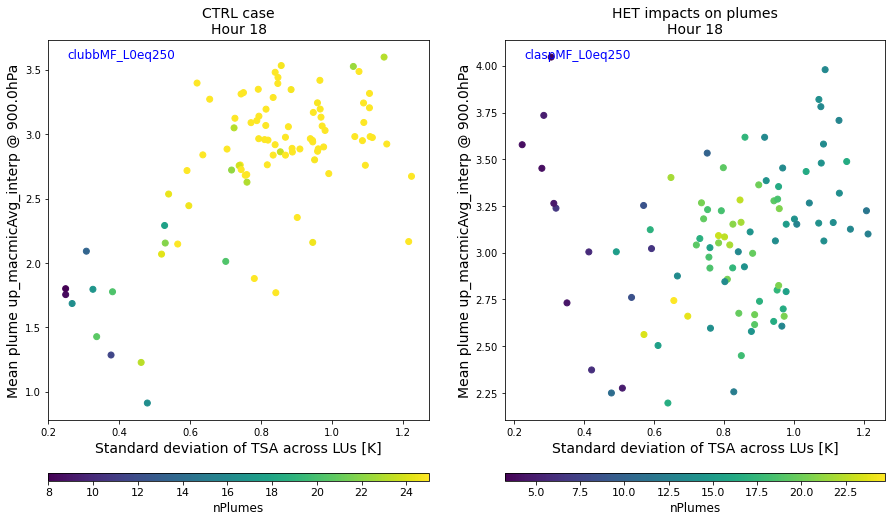

In [25]:
## Choose an hour
hrSel = 18

levInterpSel = 900.0
ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

var_h0 = 'nPlumesActive'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'

hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where(hrMean_h0['time.hour'].values==hrSel)[0])

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where(hrMean_h2['time.hour'].values==hrSel)[0])

hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where(hrMean_clm['time.hour'].values==hrSel)[0])


ctrlSel = 'clubbMF_L0eq250'
caseSel = 'claspMF_L0eq250'

## Set up the plot
fig,axs = plt.subplots(1,2,figsize=(15,7))
axs = axs.ravel()

splot = axs[0].scatter(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         np.nanmean(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         c=thisHr_h0.sel(case=ctrlSel) )

# Add colorbar
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='nPlumes', size=12)

# Other plot options
axs[0].set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs[0].set_ylabel('Mean plume '+var_h2+' @ '+str(levInterpSel)+'hPa',fontsize=14)
axs[0].set_title('CTRL case\nHour '+str(hrSel), fontsize=14)
axs[0].text(0.05, 0.95,ctrlSel, transform=axs[0].transAxes, fontsize=12, color='blue')




splot = axs[1].scatter(thisHr_clm.sel(case=caseSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=caseSel).isel(levInterp=0), axis=1), 
         np.nanmean(thisHr_h2.sel(case=caseSel).isel(levInterp=0), axis=1), 
         c=thisHr_h0.sel(case=caseSel) )

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='nPlumes', size=12)

# Other plot options
axs[1].set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs[1].set_ylabel('Mean plume '+var_h2+' @ '+str(levInterpSel)+'hPa',fontsize=14)
axs[1].set_title('HET impacts on plumes\nHour '+str(hrSel), fontsize=14)
axs[1].text(0.05, 0.95,caseSel, transform=axs[1].transAxes, fontsize=12, color='blue')



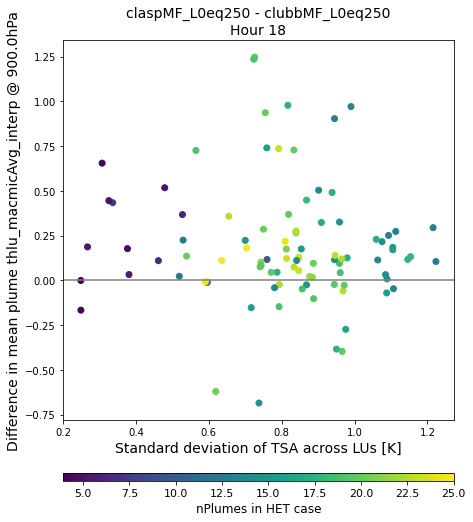

In [95]:
## Choose an hour
hrSel = 18

levInterpSel = 900.0
ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

var_h0 = 'nPlumesActive'
var_h2 = 'thlu_macmicAvg_interp'
# var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'

hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where(hrMean_h0['time.hour'].values==hrSel)[0])

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where(hrMean_h2['time.hour'].values==hrSel)[0])

hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where(hrMean_clm['time.hour'].values==hrSel)[0])


ctrlSel = 'clubbMF_L0eq250'
caseSel = 'claspMF_L0eq250'

HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel).where(scamDS_h2['time.hour']==hrSel).resample(time='1H').mean().fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel).where(scamDS_h2['time.hour']==hrSel).resample(time='1H').mean().fillna(0)


## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

splot = axs.scatter(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         thisHr_h2.sel(case=caseSel).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
         c=thisHr_h0.sel(case=caseSel) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='nPlumes in HET case', size=12)

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2+' @ '+str(levInterpSel)+'hPa',fontsize=14)
axs.set_title(caseSel+' - '+ctrlSel+'\nHour '+str(hrSel), fontsize=14)
# axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')

axs.axhline(0,color='grey')



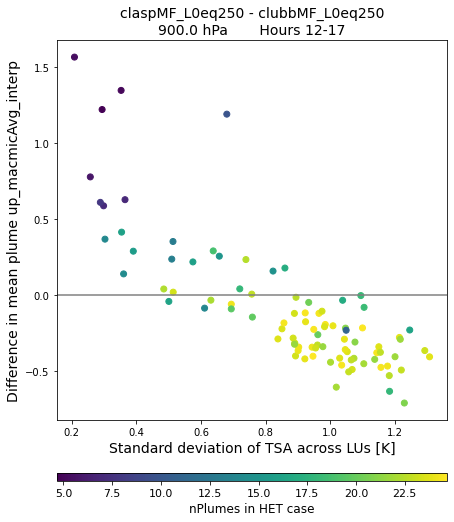

In [26]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

levInterpSel = 900.0
ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

var_h0 = 'nPlumesActive'
# var_h2 = 'thlu_macmicAvg_interp'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'

hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')


hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

## THE UNIQUE PART: 
## USE A SINGLE SET OF CASES, COLOR BY NPLUMES
ctrlSel = 'clubbMF_L0eq250'
caseSel = 'claspMF_L0eq250'

HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)


## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

splot = axs.scatter(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         thisHr_h2.sel(case=caseSel).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
         c=thisHr_h0.sel(case=caseSel) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label='nPlumes in HET case', size=12)

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_title(caseSel+' - '+ctrlSel+'\n'+str(levInterpSel)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
# axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')

axs.axhline(0,color='grey')



          Case       Slope   Pearsons r    R**2
         L0eq50        nan        nan        nan
        L0eq250     -1.062     -0.684      0.468
  L0eq250_52pct     -1.145     -0.750      0.563
   L0eq250_rand     -0.712     -0.567      0.321
          Lopt6     -1.247     -0.680      0.463


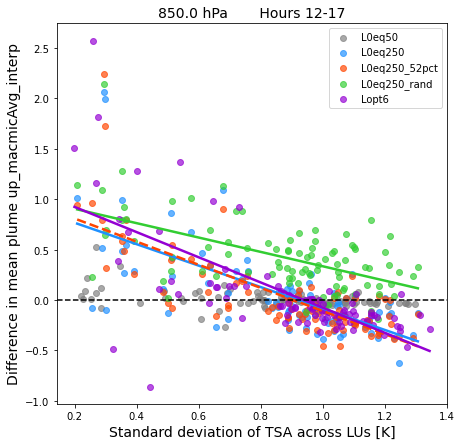

In [71]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

## THE UNIQUE PART: 
## USE A SINGLE LEVEL
levInterpSel = 850.0
ilevSel = np.where(scamDS_h2.levInterp.values==levInterpSel)[0]

var_h0 = 'nPlumesActive'
# var_h2 = 'thlu_macmicAvg_interp'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'

hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')


hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

caseCmpr_HOM = ['clubbMF_L0eq50', 'clubbMF_L0eq250', 'clubbMF_L0eq250',      'clubbMF_L0eq250',      'clubbMF_Lopt6_perPlume']
caseCmpr_HET = ['claspMF_L0eq50', 'claspMF_L0eq250', 'claspMF_L0eq250_52pct','claspMF_L0eq250_rand', 'claspMF_Lopt6_perPlume']
caseCmpr_colors = ['grey',           'dodgerblue',         'orangered',         'limegreen',          'darkviolet']
# caseLine_colors = ['dimgrey',        'royalblue',           'darkorange',        'forestgreen',        'purple']
caseCmpr_labels = ['L0eq50','L0eq250','L0eq250_52pct','L0eq250_rand','Lopt6_pp']
                   
## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

## Set up table 
print('          Case       Slope   Pearsons r    R**2')

for iCase in range(len(caseCmpr_HOM)): 
    

    ctrlSel = caseCmpr_HOM[iCase]
    caseSel = caseCmpr_HET[iCase]

    HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
    HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

    axs.scatter(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
             # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
             thisHr_h2.sel(case=caseSel).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 
             c=caseCmpr_colors[iCase], label=caseCmpr_labels[iCase], alpha=0.68 )
    
    #find line of best fit
    a, b = np.polyfit(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), thisHr_h2.sel(case=caseSel).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens'), 1)
    #add line of best fit to plot
    x = np.linspace(np.min(thisHr_clm.sel(case=ctrlSel).std(dim='landunit')), np.max(thisHr_clm.sel(case=ctrlSel).std(dim='landunit')), 150)
    if caseCmpr_labels[iCase]=='L0eq250_52pct':
        axs.plot(x, a*x+b, '--', color=caseCmpr_colors[iCase], label=None, linewidth=2.5)   
    else:
        axs.plot(x, a*x+b, color=caseCmpr_colors[iCase], label=None, linewidth=2.5)  
        
    ## Correlation
    r = np.corrcoef(np.squeeze(thisHr_clm.sel(case=ctrlSel).std(dim='landunit')), 
                    np.squeeze(thisHr_h2.sel(case=caseSel).isel(levInterp=0).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).isel(levInterp=0).weighted(HOMwgts).mean(dim='nens')) )
    
    print( '%15s %10.3f %10.3f %10.3f' % (caseCmpr_labels[iCase], a, r[0,1], r[0,1]**2))

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_title(str(levInterpSel)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
# axs.text(0.05, 0.95,ctrlSel, transform=axs.transAxes, fontsize=12, color='blue')
axs.legend()
axs.axhline(0,color='k',linestyle='--')



          Case       Slope   Pearsons r    R**2
         L0eq50     -0.006     -0.584      0.341
        L0eq250     -0.005     -0.173      0.030
  L0eq250_52pct     -0.007     -0.224      0.050
   L0eq250_rand     -0.006     -0.185      0.034
       Lopt6_pp     -0.014     -0.467      0.218


(0.15, 1.42)

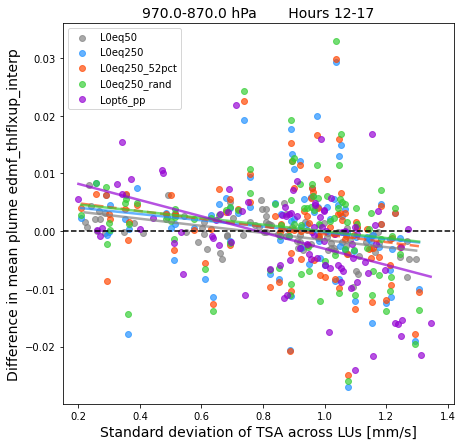

In [15]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

## THE UNIQUE PART: 
## Choose a level range too
levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2.levInterp.values>=levInterpMax) & (scamDS_h2.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)

var_h0 = 'nPlumesActive'
# var_h2 = 'edmf_upbuoy_interp'
# var_h2 = 'up_macmicAvg_interp'
var_h2 = 'edmf_thlflxup_interp'
clmVar = 'TSA'
# clmVar = 'QFLX'

hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')


hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

caseCmpr_HOM = ['clubbMF_L0eq50', 'clubbMF_L0eq250', 'clubbMF_L0eq250',      'clubbMF_L0eq250',      'clubbMF_Lopt6_perPlume']
caseCmpr_HET = ['claspMF_L0eq50', 'claspMF_L0eq250', 'claspMF_L0eq250_52pct','claspMF_L0eq250_rand', 'claspMF_Lopt6_perPlume']
caseCmpr_colors = ['grey',           'dodgerblue',         'orangered',         'limegreen',          'darkviolet']
caseCmpr_labels = ['L0eq50','L0eq250','L0eq250_52pct','L0eq250_rand','Lopt6_pp']
# caseCmpr_alphas = [ 0.2, 0.68]
caseCmpr_alphas = [ 0.68, 0.68, 0.68, 0.68, 0.68]
                   
## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

## Set up table 
print('          Case       Slope   Pearsons r    R**2')

for iCase in range(len(caseCmpr_HOM)): 
# for iCase in range(2): 
    
    ctrlSel = caseCmpr_HOM[iCase]
    caseSel = caseCmpr_HET[iCase]

    HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
    HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

    axs.scatter(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
             # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
             thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens'), 
             c=caseCmpr_colors[iCase], label=caseCmpr_labels[iCase], alpha=caseCmpr_alphas[iCase] )


    #find line of best fit
    xVar = thisHr_clm.sel(case=ctrlSel).std(dim='landunit')
    yVar = thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens')

    a, b = np.polyfit(xVar, yVar, 1)
    #add line of best fit to plot
    x = np.linspace(np.min(xVar), np.max(xVar), 150)
    if caseCmpr_labels[iCase]=='L0eq250_52pct':
        axs.plot(x, a*x+b, '--', color=caseCmpr_colors[iCase], label=None, linewidth=2.5, alpha=caseCmpr_alphas[iCase])   
    else:
        axs.plot(x, a*x+b, color=caseCmpr_colors[iCase], label=None, linewidth=2.5, alpha=caseCmpr_alphas[iCase])  
        
    ## Correlation
    r = np.corrcoef(np.squeeze(xVar), 
                    np.squeeze(yVar) )
    
    print( '%15s %10.3f %10.3f %10.3f' % (caseCmpr_labels[iCase], a, r[0,1], r[0,1]**2))

# Other plot options
# axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [mm/s]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_title(str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.legend()
axs.axhline(0,color='k',linestyle='--')

# axs.set_ylim([-0.65, 0.9])
# axs.set_xlim([0, 9e-5])
axs.set_xlim([0.15, 1.42])

# ## Add markers for case study day (day with high std(TSA) across all cases)
# stdVar = thisHr_clm.std(dim='landunit')
# diffVar = thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens')

# for iTimes in range(len(stdVar.time.values)): 
#     iMatch = np.where( stdVar.isel(time=iTimes)>=1.28 )[0]
    
#     if len(iMatch)==len(stdVar.case.values):
        
#         for iCase in range(len(caseCmpr_HOM)):
#             ctrlSel = caseCmpr_HOM[iCase]
#             caseSel = caseCmpr_HET[iCase]
            
#             HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
#             HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

#             diffVar = thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens')

#             axs.plot(thisHr_clm.sel(case=ctrlSel).isel(time=iTimes).std(dim='landunit').values, diffVar.isel(time=iTimes).values, 'x', 
#                      color=caseCmpr_colors[iCase], markeredgewidth=3, markersize=15)


In [45]:
clmDS_h2.SOILWATER_10CM.isel(case=3).mean(dim='landunit')

<xarray.DataArray 'SOILWATER_10CM' (time: 26496)>
array([54.40898 , 54.40898 , 54.40898 , ..., 36.52394 , 36.528294,
       36.532623], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-06-02T00:01:00 ... 2015-09-01T23:56:0...
    case     <U15 'claspMF_L0eq250'

(0.15, 1.42)

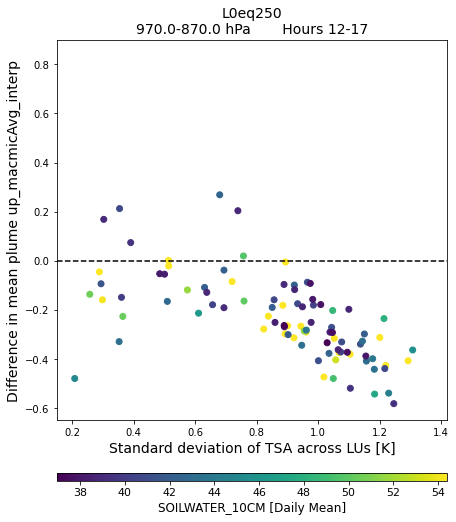

In [27]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

## THE UNIQUE PART: 
## Choose a level range too
levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2.levInterp.values>=levInterpMax) & (scamDS_h2.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)

var_h0 = 'OMEGA_interp'
# var_h2 = 'edmf_upbuoy_interp'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'
clmVar2 = 'SOILWATER_10CM'
# clmVar = 'QFLX'

hrMean_h0 = scamDS[var_h0].isel(levInterp=np.where( (scamDS.levInterp.values>=450) & (scamDS.levInterp.values<=550))[0]).mean(dim='levInterp').resample(time='1H').mean(dim='time')
# hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
# hrMean_h0 = scamDS[var_h0].isel(levInterp=-1).resample(time='1H').mean(dim='time')
# hrMean_h0 = scamDS[var_h0].resample(time='1H').mean(dim='time') 
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')
# thisHr_h0 = hrMean_h0.resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean2_clm = clmDS_h2[clmVar2].mean(dim='landunit').resample(time='1H').mean(dim='time')
thisHr2_clm = hrMean2_clm.resample(time='1D').mean(dim='time')


caseCmpr_HOM = ['clubbMF_L0eq250'      ]
caseCmpr_HET = ['claspMF_L0eq250']
# caseCmpr_HET = ['claspMF_L0eq250_52pct']
# caseCmpr_labels = ['L0eq250_52pct']
caseCmpr_labels = ['L0eq250']
                   
## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

for iCase in range(len(caseCmpr_HOM)): 
    ctrlSel = caseCmpr_HOM[iCase]
    caseSel = caseCmpr_HET[iCase]

    HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
    HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

    splot= axs.scatter(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
             # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
             thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens'), 
             # c=thisHr_h0.sel(case=caseSel) )
             c=thisHr2_clm.sel(case=caseSel) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
# cbar.set_label(label=var_h0+' [Afternoon Mean, 550-450 hPa]', size=12)
cbar.set_label(label=clmVar2+' [Daily Mean]', size=12)


# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
# axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [mm/s]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_title(caseCmpr_labels[0]+'\n'+str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.axhline(0,color='k',linestyle='--')

axs.set_ylim([-0.65, 0.9])
# axs.set_xlim([0, 9e-5])
axs.set_xlim([0.15, 1.42])


(0.15, 1.42)

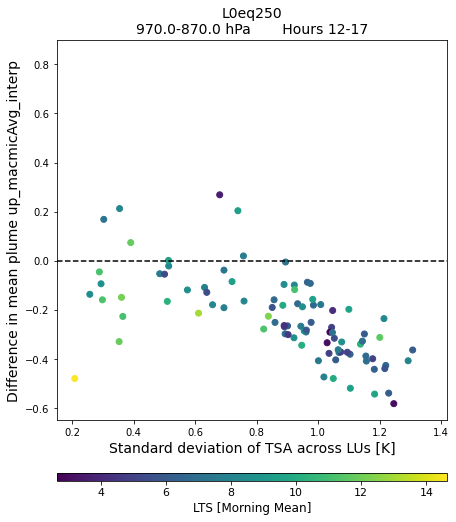

In [30]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

## THE UNIQUE PART: 
## Choose a level range too
levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2.levInterp.values>=levInterpMax) & (scamDS_h2.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)

var_h0 = 'LTS'
# var_h2 = 'edmf_upbuoy_interp'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'
clmVar2 = 'SOILWATER_10CM'
# clmVar = 'QFLX'

# hrMean_h0 = scamDS[var_h0].isel(levInterp=np.where( (scamDS.levInterp.values>=450) & (scamDS.levInterp.values<=550))[0]).mean(dim='levInterp').resample(time='1H').mean(dim='time')
# hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
# hrMean_h0 = scamDS[var_h0].isel(levInterp=-1).resample(time='1H').mean(dim='time')
hrMean_h0 = scamDS[var_h0].resample(time='1H').mean(dim='time') 
# thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=7) & (hrMean_h0['time.hour'].values<=12) )[0]).resample(time='1D').mean(dim='time')

# thisHr_h0 = hrMean_h0.resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean2_clm = clmDS_h2[clmVar2].mean(dim='landunit').resample(time='1H').mean(dim='time')
thisHr2_clm = hrMean2_clm.resample(time='1D').mean(dim='time')


caseCmpr_HOM = ['clubbMF_L0eq250'      ]

caseCmpr_HET = ['claspMF_L0eq250']
caseCmpr_labels = ['L0eq250']

# caseCmpr_HET = ['claspMF_L0eq250_52pct']
# caseCmpr_labels = ['L0eq250_52pct']

                   
## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

for iCase in range(len(caseCmpr_HOM)): 
    ctrlSel = caseCmpr_HOM[iCase]
    caseSel = caseCmpr_HET[iCase]

    HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
    HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

    splot= axs.scatter(thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
             # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
             thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens'), 
             c=thisHr_h0.sel(case=caseSel) )

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.12, ax_position.width, 0.015])
cbar = plt.colorbar(splot, orientation='horizontal', cax=cbar_ax)
cbar.ax.tick_params(labelsize=11)
cbar.set_label(label=var_h0+' [Morning Mean]', size=12)

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
# axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [mm/s]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_title(caseCmpr_labels[0]+'\n'+str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.axhline(0,color='k',linestyle='--')

axs.set_ylim([-0.65, 0.9])
# axs.set_xlim([0, 9e-5])
axs.set_xlim([0.15, 1.42])


          Case       Slope   Pearsons r    R**2
         L0eq50     -0.100     -0.149      0.022
        L0eq250     -0.029     -0.055      0.003
  L0eq250_52pct     -0.074     -0.179      0.032
   L0eq250_rand     -0.049     -0.114      0.013
          Lopt6     -0.076     -0.185      0.034


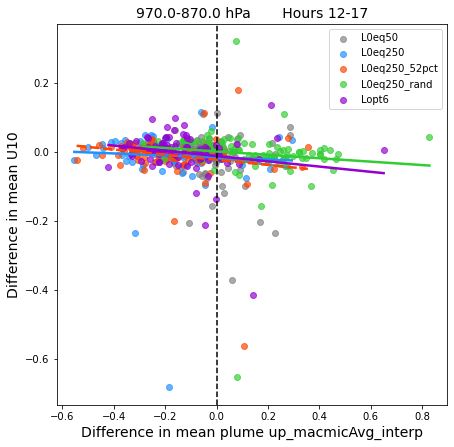

In [150]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

## THE UNIQUE PART: 
## Choose a level range too
levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2.levInterp.values>=levInterpMax) & (scamDS_h2.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)

var_h0 = 'U10'
# var_h2 = 'edmf_upbuoy_interp'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'
# clmVar = 'QFLX'

# hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
hrMean_h0 = scamDS[var_h0].resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')


hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

caseCmpr_HOM = ['clubbMF_L0eq50', 'clubbMF_L0eq250', 'clubbMF_L0eq250',      'clubbMF_L0eq250',      'clubbMF_Lopt6_perPlume']
caseCmpr_HET = ['claspMF_L0eq50', 'claspMF_L0eq250', 'claspMF_L0eq250_52pct','claspMF_L0eq250_rand', 'claspMF_Lopt6_perPlume']
caseCmpr_colors = ['grey',           'dodgerblue',         'orangered',         'limegreen',          'darkviolet']
# caseLine_colors = ['dimgrey',        'royalblue',           'darkorange',        'forestgreen',        'purple']
caseCmpr_labels = ['L0eq50','L0eq250','L0eq250_52pct','L0eq250_rand','Lopt6']
                   
## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

## Set up table 
print('          Case       Slope   Pearsons r    R**2')

for iCase in range(len(caseCmpr_HOM)): 
    
    ctrlSel = caseCmpr_HOM[iCase]
    caseSel = caseCmpr_HET[iCase]

    HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
    HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

    axs.scatter(
             # thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
             # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
             thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens'), 
             thisHr_h0.sel(case=caseSel) - thisHr_h0.sel(case=ctrlSel), 
            c=caseCmpr_colors[iCase], label=caseCmpr_labels[iCase], alpha=0.68 )
    
    #find line of best fit
    xVar = thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens') 
    yVar = thisHr_h0.sel(case=caseSel) - thisHr_h0.sel(case=ctrlSel)

    a, b = np.polyfit(xVar, yVar, 1)
    #add line of best fit to plot
    x = np.linspace(np.min(xVar), np.max(xVar), 150)
    if caseCmpr_labels[iCase]=='L0eq250_52pct':
        axs.plot(x, a*x+b, '--', color=caseCmpr_colors[iCase], label=None, linewidth=2.5)   
    else:
        axs.plot(x, a*x+b, color=caseCmpr_colors[iCase], label=None, linewidth=2.5)  
        
    ## Correlation
    r = np.corrcoef(np.squeeze(xVar), 
                    np.squeeze(yVar) )
    
    print( '%15s %10.3f %10.3f %10.3f' % (caseCmpr_labels[iCase], a, r[0,1], r[0,1]**2))

# Other plot options
axs.set_xlabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_ylabel('Difference in mean '+var_h0,fontsize=14)
axs.set_title(str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.legend()
axs.axvline(0,color='k',linestyle='--')


          Case       Slope   Pearsons r    R**2
         L0eq50     -0.143     -0.056      0.003
        L0eq250      0.515      0.224      0.050
  L0eq250_52pct      0.501      0.246      0.060
   L0eq250_rand      0.024      0.011      0.000
          Lopt6      0.258      0.138      0.019


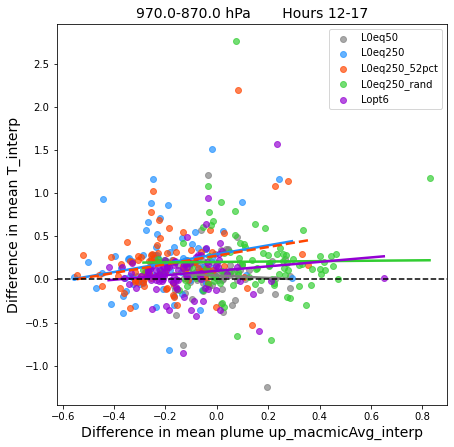

In [159]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

## Choose a level range too
levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2.levInterp.values>=levInterpMax) & (scamDS_h2.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)

var_h0 = 'T_interp'
# var_h2 = 'edmf_upbuoy_interp'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'
# clmVar = 'QFLX'

hrMean_h0 = scamDS[var_h0].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h0 = hrMean_h0.isel(time=np.where( (hrMean_h0['time.hour'].values>=hrStart) & (hrMean_h0['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMean_h2 = scamDS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHr_h2 = hrMean_h2.isel(time=np.where( (hrMean_h2['time.hour'].values>=hrStart) & (hrMean_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')


hrMean_clm = clmDS_h2[clmVar].resample(time='1H').mean(dim='time')
thisHr_clm = hrMean_clm.isel(time=np.where( (hrMean_clm['time.hour'].values>=hrStart) & (hrMean_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

caseCmpr_HOM = ['clubbMF_L0eq50', 'clubbMF_L0eq250', 'clubbMF_L0eq250',      'clubbMF_L0eq250',      'clubbMF_Lopt6_perPlume']
caseCmpr_HET = ['claspMF_L0eq50', 'claspMF_L0eq250', 'claspMF_L0eq250_52pct','claspMF_L0eq250_rand', 'claspMF_Lopt6_perPlume']
caseCmpr_colors = ['grey',           'dodgerblue',         'orangered',         'limegreen',          'darkviolet']
# caseLine_colors = ['dimgrey',        'royalblue',           'darkorange',        'forestgreen',        'purple']
caseCmpr_labels = ['L0eq50','L0eq250','L0eq250_52pct','L0eq250_rand','Lopt6']
                   
## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))

## Set up table 
print('          Case       Slope   Pearsons r    R**2')

for iCase in range(len(caseCmpr_HOM)): 
    
    ctrlSel = caseCmpr_HOM[iCase]
    caseSel = caseCmpr_HET[iCase]

    HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
    HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((scamDS_h2['time.hour'].values>=hrStart) & (scamDS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

    axs.scatter(
             # thisHr_clm.sel(case=ctrlSel).std(dim='landunit'), 
             # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
             thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens'), 
             thisHr_h0.sel(case=caseSel)- thisHr_h0.sel(case=ctrlSel), 
             c=caseCmpr_colors[iCase], label=caseCmpr_labels[iCase], alpha=0.68 )
    
    #find line of best fit
    xVar = thisHr_h2.sel(case=caseSel).weighted(HETwgts).mean(dim='nens') - thisHr_h2.sel(case=ctrlSel).weighted(HOMwgts).mean(dim='nens') 
    yVar = thisHr_h0.sel(case=caseSel) - thisHr_h0.sel(case=ctrlSel)

    a, b = np.polyfit(xVar, yVar, 1)
    #add line of best fit to plot
    x = np.linspace(np.min(xVar), np.max(xVar), 150)
    if caseCmpr_labels[iCase]=='L0eq250_52pct':
        axs.plot(x, a*x+b, '--', color=caseCmpr_colors[iCase], label=None, linewidth=2.5)   
    else:
        axs.plot(x, a*x+b, color=caseCmpr_colors[iCase], label=None, linewidth=2.5)  
        
    ## Correlation
    r = np.corrcoef(np.squeeze(xVar), 
                    np.squeeze(yVar) )
    
    print( '%15s %10.3f %10.3f %10.3f' % (caseCmpr_labels[iCase], a, r[0,1], r[0,1]**2))

# Other plot options
axs.set_xlabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_ylabel('Difference in mean '+var_h0,fontsize=14)
axs.set_title(str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.legend()
axs.axhline(0,color='k',linestyle='--')


In [125]:
scamDS

<xarray.Dataset>
Dimensions:                 (case: 8, ilev: 59, lev: 58, levInterp: 78, time: 26496)
Coordinates:
    lat                     float64 36.6
    lon                     float64 262.5
  * ilev                    (ilev) float64 2.055 3.98 6.909 ... 995.1 1e+03
  * time                    (time) datetime64[ns] 2015-06-02T00:03:30 ... 201...
  * lev                     (lev) float64 3.018 5.445 9.087 ... 991.2 997.5
  * levInterp               (levInterp) float64 200.0 210.0 ... 960.0 970.0
  * case                    (case) object 'clubbMF_L0eq50' ... 'claspMF_Lopt6...
Data variables:
    wpthlp                  (case, time, ilev) float32 0.0 ... -0.02764
    wprtp                   (case, time, ilev) float32 0.0 ... 5.742e-05
    rtp2                    (case, time, ilev) float32 1e-16 1e-16 ... 4.773e-09
    thlm                    (case, time, ilev) float32 1.304e+03 ... 308.8
    rtm                     (case, time, ilev) float32 3.75e-06 ... 0.01376
    wm_zm                   (case, time, ilev) float32 0.0 0.0 ... 1.559e-05
    rtm_zm                  (case, time, ilev) float32 3.8e-06 ... 0.01374
    thlm_zm                 (case, time, ilev) float32 1.448e+03 ... 308.8
    SWCF                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LWCF                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TS                      (case, time) float32 299.4 299.4 ... 304.8 304.7
    CLOUD                   (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    FSNS                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FLNS                    (case, time) float32 66.65 0.0 0.0 ... 0.0 0.0 0.0
    PS                      (case, time) float32 9.728e+04 ... 9.716e+04
    QREFHT                  (case, time) float32 0.01464 0.01463 ... 0.01441
    U10                     (case, time) float32 4.585 4.631 ... 7.444 7.438
    CLDHGH                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDLIQ                  (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    CONCLD                  (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    TMQ                     (case, time) float32 41.06 41.07 ... 46.84 46.88
    P0                      (case) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyam                    (case, lev) float64 0.003018 0.005445 ... 0.0
    hybm                    (case, lev) float64 0.0 0.0 0.0 ... 0.9908 0.9975
    hyai                    (case, ilev) float64 0.002055 0.00398 ... 0.0 0.0
    hybi                    (case, ilev) float64 0.0 0.0 0.0 ... 0.9951 1.0
    PHIS                    (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    USTAR                   (case, time) float32 0.4364 0.4409 ... 0.7022 0.7016
    QT                      (case, time, lev) float32 3.75e-06 ... 0.01376
    GCLDLWP                 (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    THETAL                  (case, time, lev) float32 1.294e+03 ... 306.3
    CDNUMC                  (case, time) float32 4.46 4.221 ... 9.887e-09 0.1001
    CLDBOT                  (case, time) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDLOW                  (case, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CLDMED                  (case, time) float32 0.0 0.0 0.0 ... 0.0 0.0006845
    CLDTOP                  (case, time) float32 58.0 58.0 58.0 ... 58.0 58.0
    CLDTOT                  (case, time) float32 0.0 0.0 0.0 ... 0.0 0.0006845
    THLP2_CLUBB             (case, time, ilev) float32 0.0001 ... 0.001106
    CLOUDCOVER_CLUBB        (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    CLOUDFRAC_CLUBB         (case, time, lev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RCM_CLUBB               (case, time, ilev) float32 0.0 0.0 0.0 ... 0.0 0.0
    RTP2_CLUBB              (case, time, ilev) float32 1e-10 1e-10 ... 0.004773
    RTPTHLP_CLUBB           (case, time, ilev) float32 0.0 ... -0.001149
    RVMTEND_CLUBB           (case, time, lev) float32 0.0 0.0 

## Case study days

These are the dates that WRF-LES was run for, in 2015:<br>
20150606 <br>
20150609 <br>
20150627 <br>
20150801 <br>
20150829 <br>


In [105]:
from metpy.calc import cape_cin, dewpoint_from_specific_humidity, parcel_profile
import metpy.calc as mpcalc

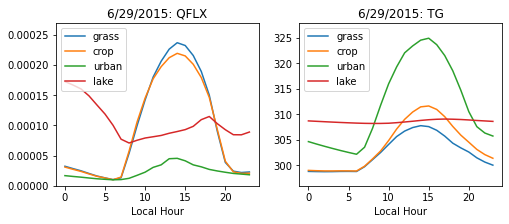

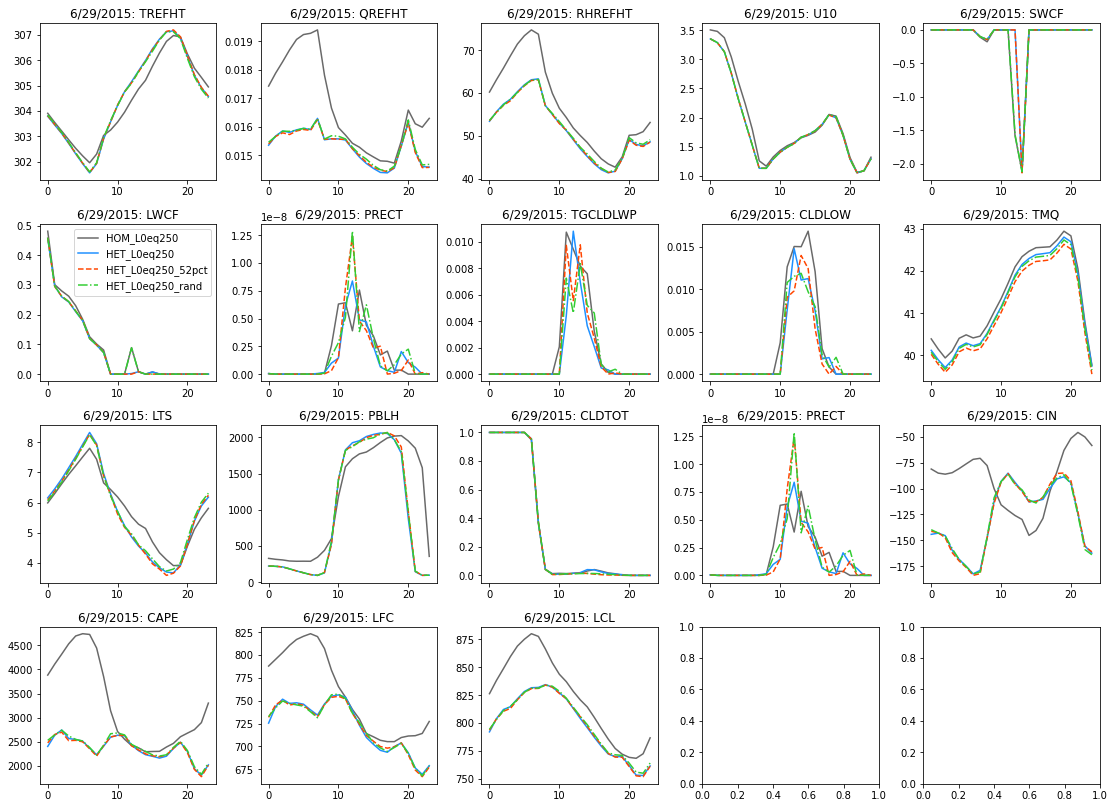

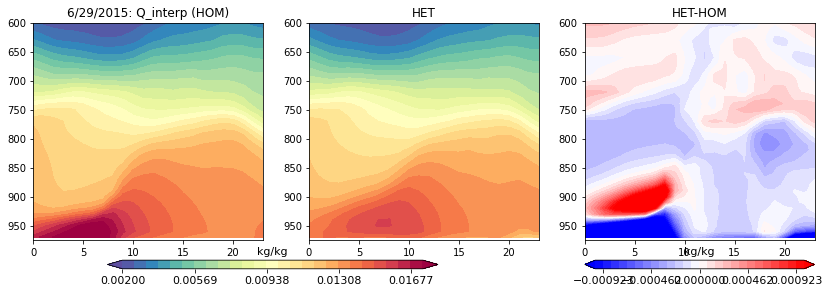

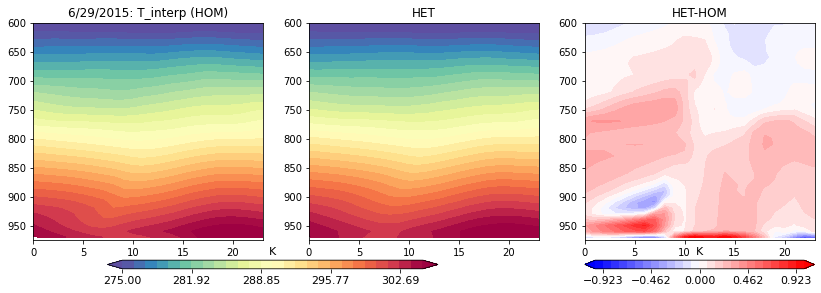

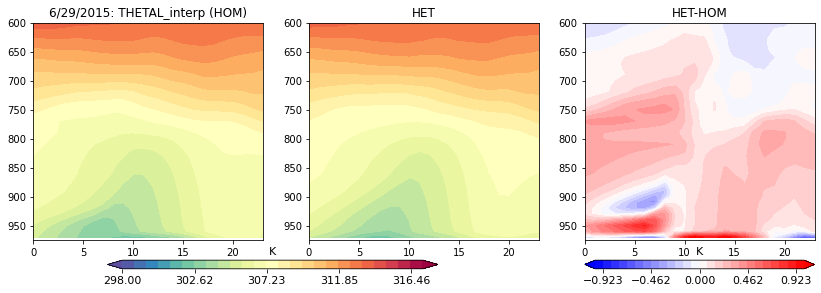

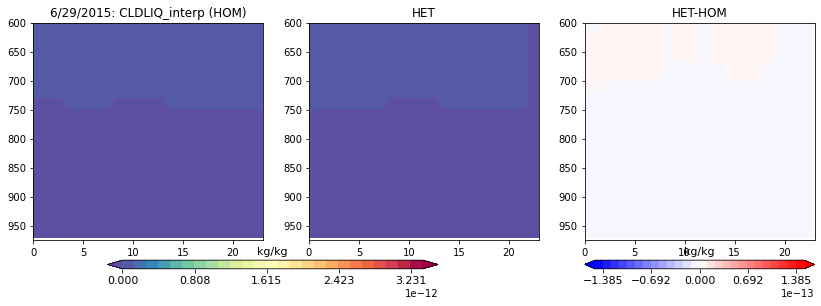

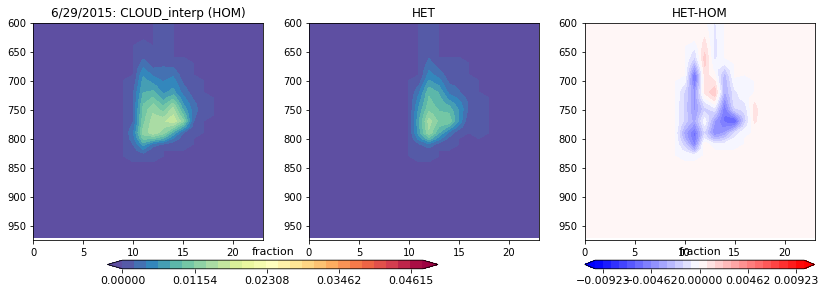

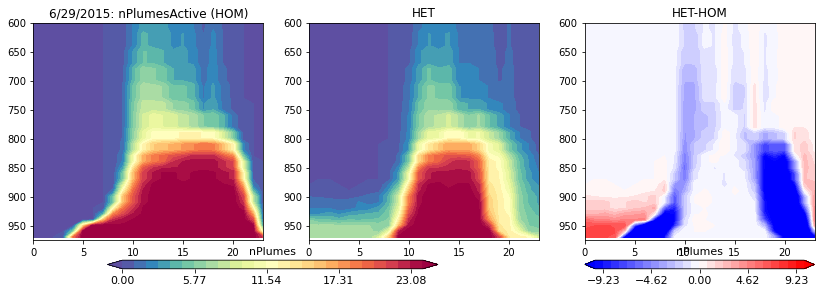

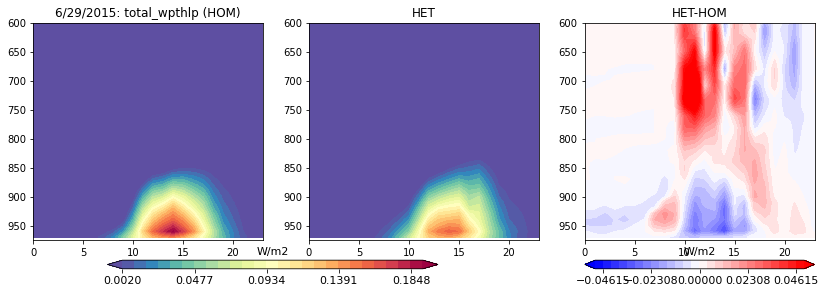

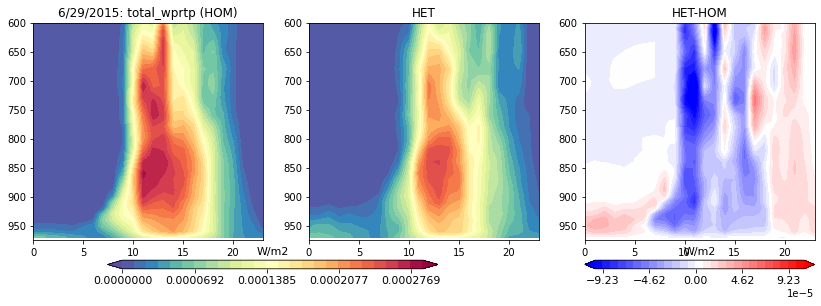

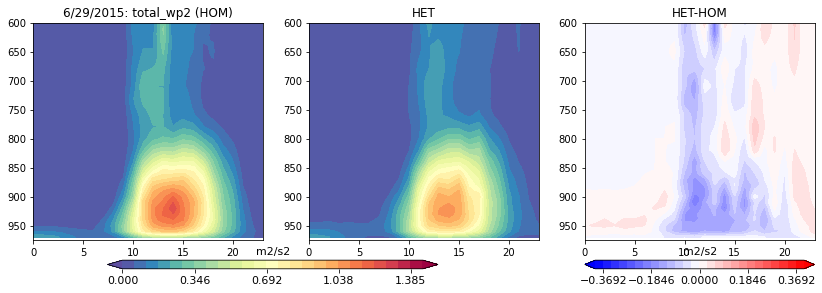

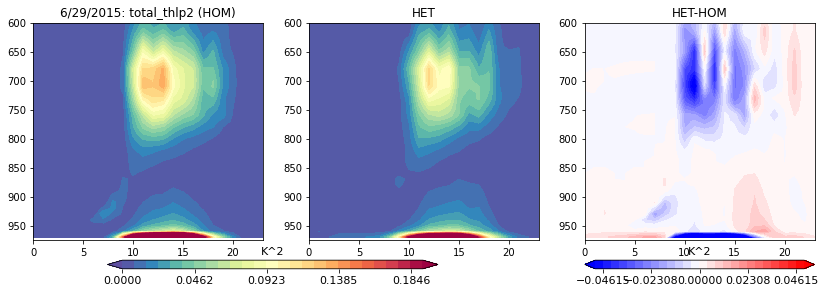

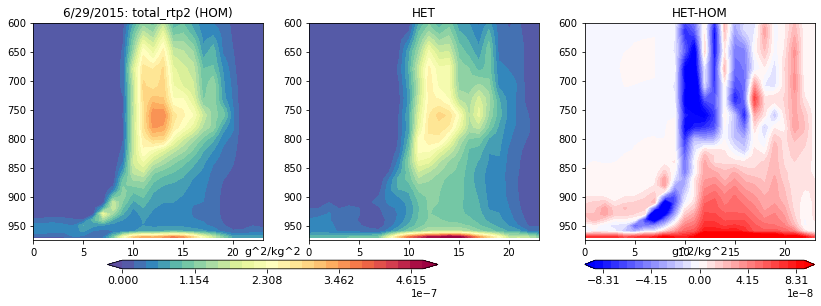

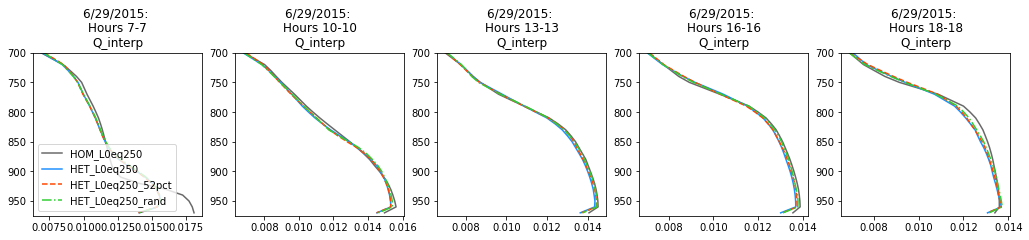

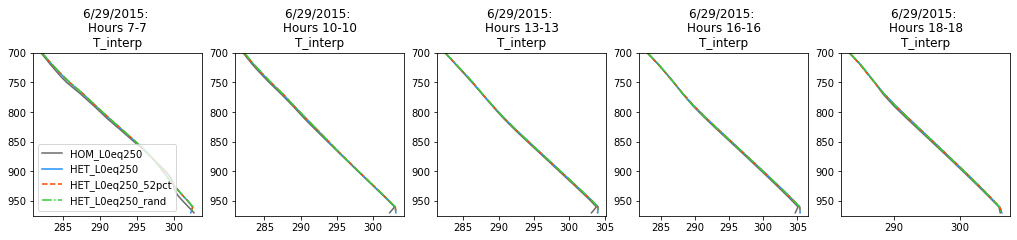

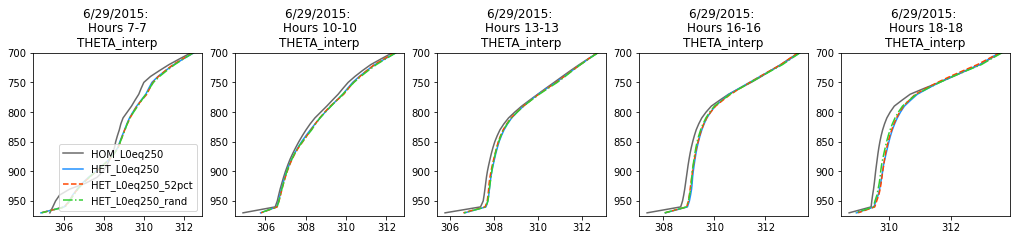

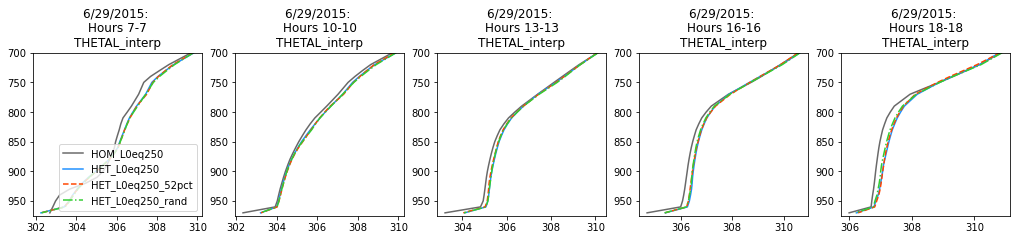

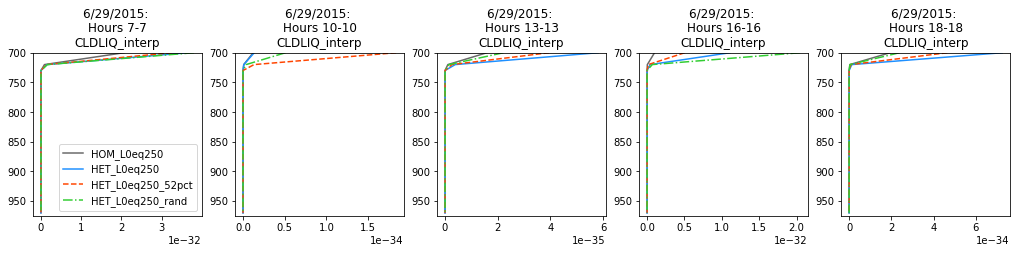

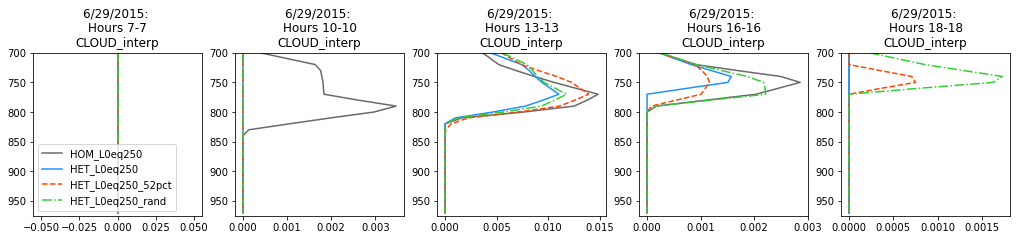

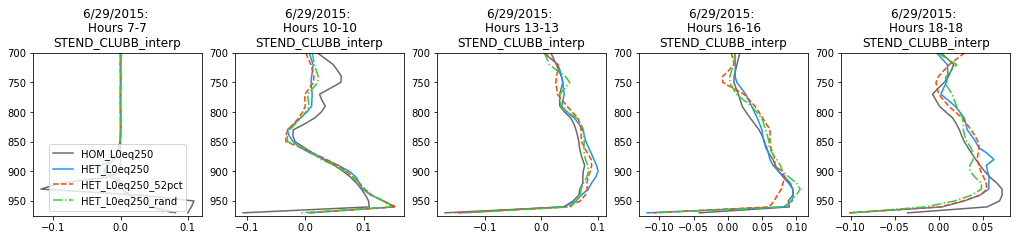

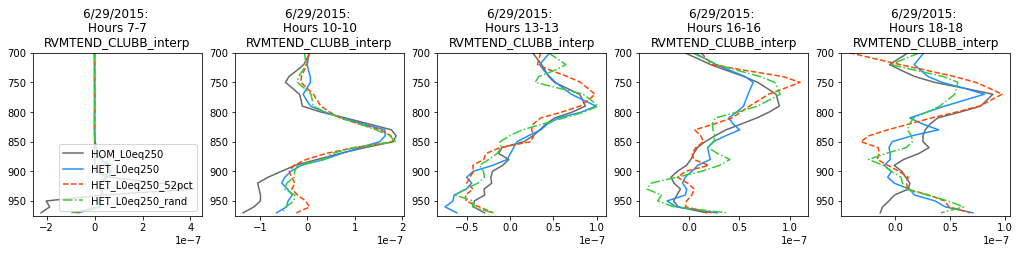

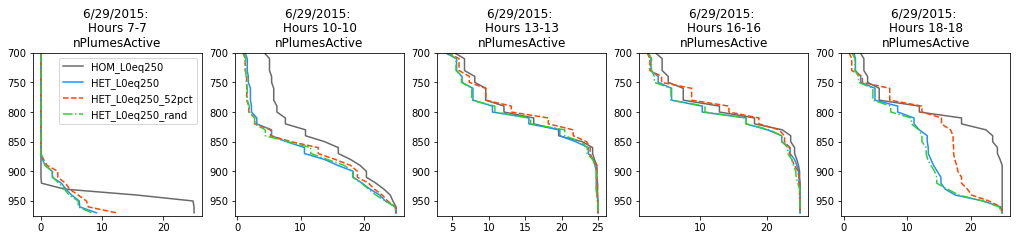

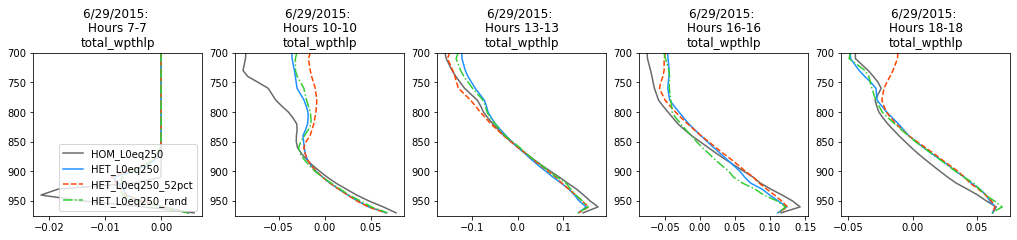

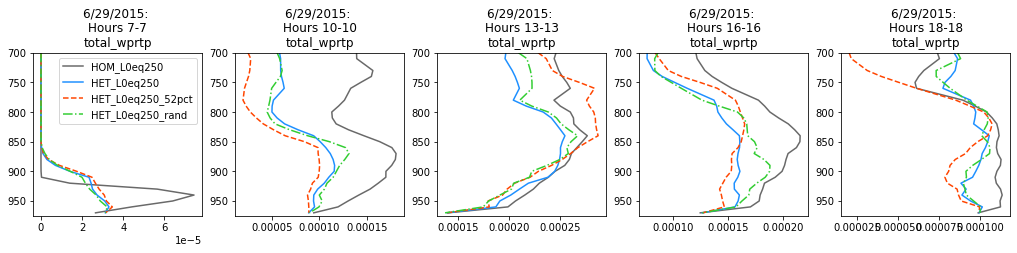

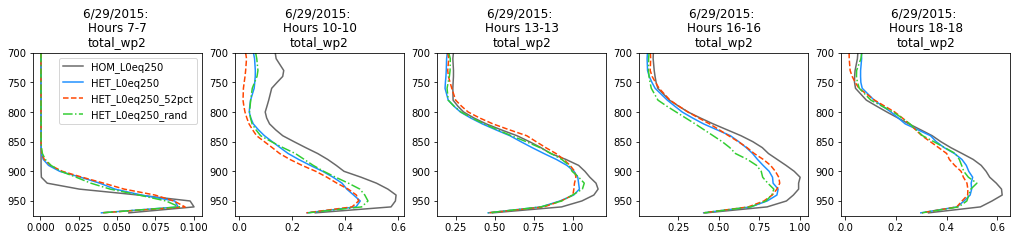

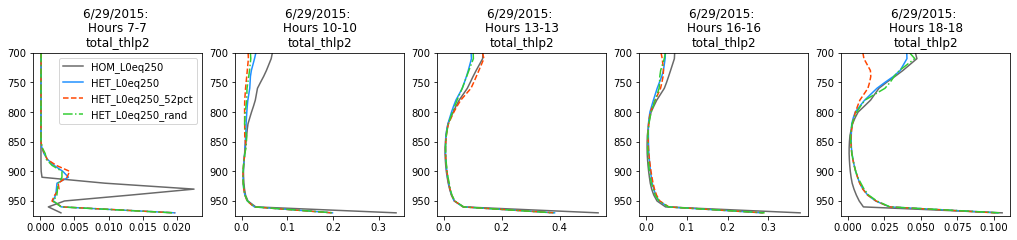

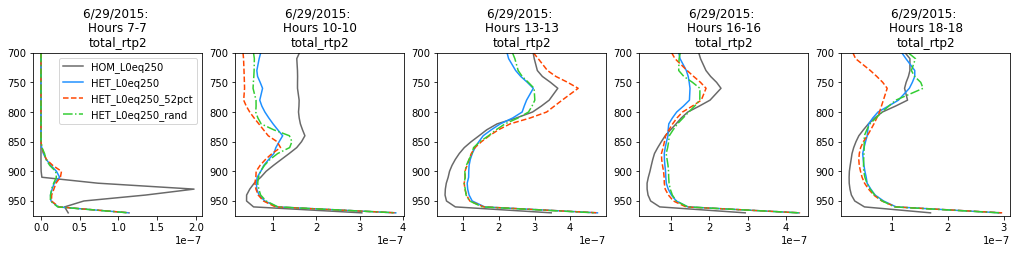

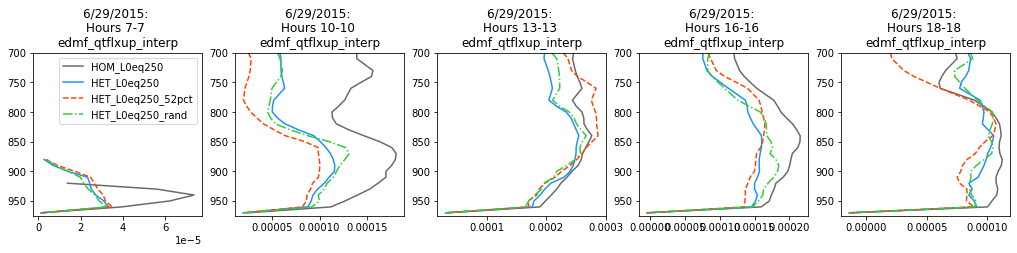

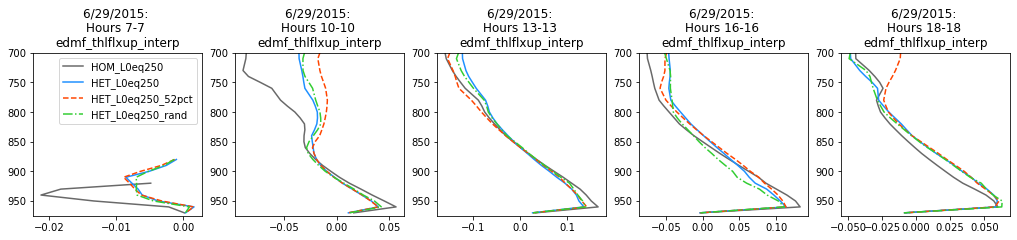

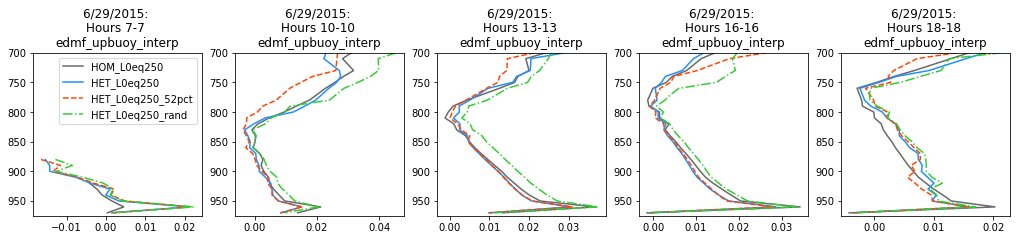

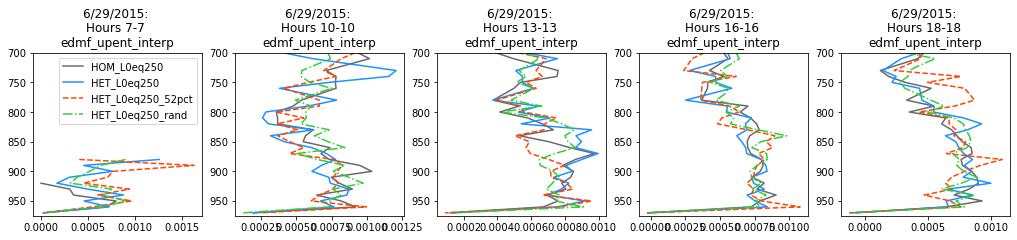

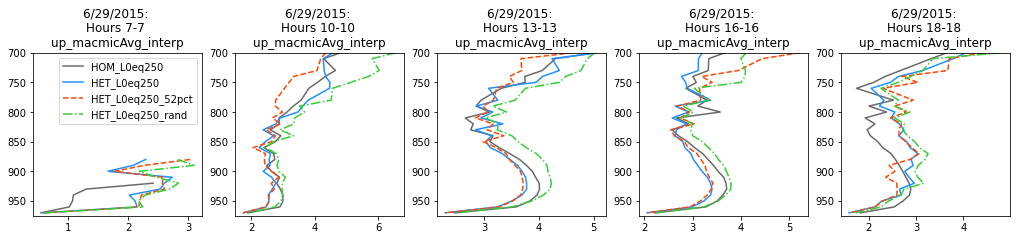

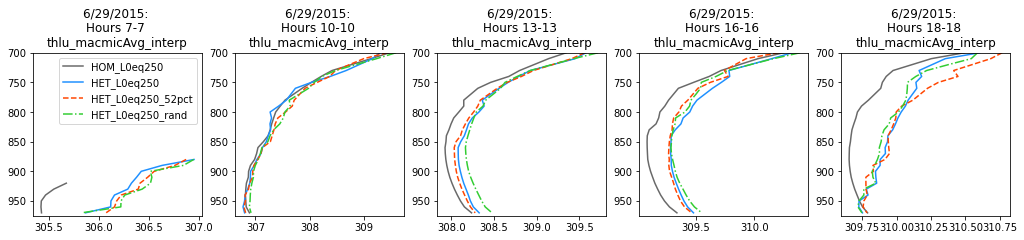

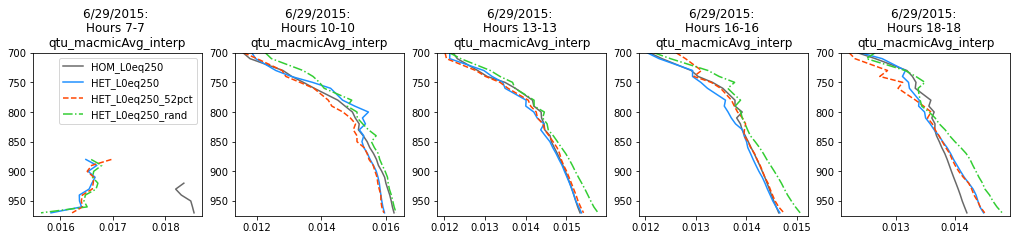

In [108]:
# monSel = [6,6, 6,8, 8]
# daySel = [6,9,27,1,29]

monSel = [6]
daySel = [29]

for iDate in range(len(monSel)): 
    dateString = str(monSel[iDate])+'/'+str(daySel[iDate])+'/2015'
    
    iSelTimes = np.where( (scamDS['time.month']==monSel[iDate]) & 
                          (scamDS['time.day']==daySel[iDate]) )[0]
    
    thisDay    = scamDS.isel(time=iSelTimes).resample(time='1H').mean()
    thisDay_h2 = scamDS_h2.isel(time=iSelTimes).resample(time='1H').mean()
    
    thisDayCLM_h2 = clmDS_h2.isel(time=iSelTimes).resample(time='1H').mean()
    
    ## Compute CAPE and CIN
    cape = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    cin  = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    lcl  = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    lfc  = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    
    for iCase in range(len(thisDay.case.values)):
        for iHr in range(len(thisDay.time.values)):
            ## Calculate CAPE? 
            p = np.flip(thisDay.levInterp.values) * units.hPa
            T = np.flip(thisDay.isel(case=iCase, time=iHr).T_interp.values) * units.K 
            Q = np.flip(thisDay.isel(case=iCase, time=iHr).Q_interp.values) * units('kg/kg')
            Td = dewpoint_from_specific_humidity(p, T, Q)
            # compture parcel temperature
            prof = parcel_profile(p, T[0], Td[0]).to('K')
            cape1,cin1 = cape_cin(p, T, Td, prof)
            cape[iCase,iHr] = cape1.magnitude
            cin[iCase,iHr] = cin1.magnitude
            
            lclp, lclt = mpcalc.lcl(p[0], T[0], Td[0])
            lfcp, _ = mpcalc.lfc(p, T, Td)
            lcl[iCase,iHr] = lclp.magnitude
            lfc[iCase,iHr] = lfcp.magnitude
            
    thisDay['CAPE']  = (('case','time'), cape)
    thisDay['CIN']  = (('case','time'), cin)
    thisDay['LCL'] = (('case','time'), lcl)
    thisDay['LFC'] = (('case','time'), lfc)
    
    
    # ----- CLM plots ----- #
    fig,axs = plt.subplots(1,2,figsize=(8,3))
    axs     = axs.ravel()
    
    for iLU in range(4):
        axs[0].plot(thisDayCLM_h2['time.hour'].values, thisDayCLM_h2.sel(case='clubbMF_L0eq250').isel(landunit=iLU).QFLX.values)
        axs[1].plot(thisDayCLM_h2['time.hour'].values, thisDayCLM_h2.sel(case='clubbMF_L0eq250').isel(landunit=iLU).TG.values)

    axs[0].legend(['grass','crop','urban','lake'])   
    axs[1].legend(['grass','crop','urban','lake'])   

    axs[0].set_title(dateString+': QFLX')
    axs[1].set_title(dateString+': TG')

    axs[0].set_ylim([0.0, 0.00027])
    axs[1].set_ylim([296, 328])

    axs[0].set_xlabel('Local Hour')
    axs[1].set_xlabel('Local Hour')
    
    
    # ----- 2D CAM plots ----- #
    pltVars = ['TREFHT','QREFHT','RHREFHT',
               'U10','SWCF','LWCF','PRECT',
               'TGCLDLWP','CLDLOW','TMQ', 
               'LTS','PBLH','CLDTOT','PRECT',
               'CIN','CAPE','LFC','LCL']  
    
    fig,axs = plt.subplots(4,5, figsize=(19,14))
    axs = axs.ravel()
    
    for iVar in range(len(pltVars)): 
        axs[iVar].plot(thisDay['time.hour'].values, thisDay[pltVars[iVar]].sel(case='clubbMF_L0eq250'), 
                       color='dimgrey', label='HOM_L0eq250' )
        
        axs[iVar].plot(thisDay['time.hour'].values, thisDay[pltVars[iVar]].sel(case='claspMF_L0eq250'), 
                       color='dodgerblue', label='HET_L0eq250' )
        
        axs[iVar].plot(thisDay['time.hour'].values, thisDay[pltVars[iVar]].sel(case='claspMF_L0eq250_52pct'), 
                       '--', color='orangered', label='HET_L0eq250_52pct' )
        
        axs[iVar].plot(thisDay['time.hour'].values, thisDay[pltVars[iVar]].sel(case='claspMF_L0eq250_rand'), 
                       '-.', color='limegreen', label='HET_L0eq250_rand' )
        if pltVars[iVar]=='LWCF':    
            axs[iVar].legend()
        axs[iVar].set_title(dateString+': '+pltVars[iVar])
        
    fig.subplots_adjust(hspace=0.28, wspace = 0.25)
    
    
    
    # ----- 3D CAM plots ----- #
    pltVars = ['Q_interp','T_interp','THETAL_interp','CLDLIQ_interp','CLOUD_interp','nPlumesActive']
    cMin    = [0.002, 275, 298,    0.0,   0.0,   0]
    cMax    = [0.018, 305, 318, 3.5e-12,  0.05, 25]
    diffMax = [0.001, 1.0,   1, 1.5e-13,  0.01, 10]
    unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['THETAL'].units, scamDS['CLDLIQ'].units, 
               scamDS['CLOUD'].units, 'nPlumes']
    maxLev  = 600.0
    
    for iVar in range(len(pltVars)): 
        fig,axs = plt.subplots(1,3,figsize=(14,4))
        axs     = axs.ravel()
    
        axs[0].contourf(thisDay['time.hour'].values, thisDay['levInterp'].values, 
                           np.squeeze(thisDay[pltVars[iVar]].sel(case='clubbMF_L0eq250')).transpose(),
                           np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                           cmap='Spectral_r', extend='both')
        cplt = axs[1].contourf(thisDay['time.hour'].values, thisDay['levInterp'].values, 
                           np.squeeze(thisDay[pltVars[iVar]].sel(case='claspMF_L0eq250')).transpose(),
                           np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                           cmap='Spectral_r', extend='both')
        # Add colorbar
        ax_position = axs[1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
        cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
        cbar.ax.locator_params(nbins=6)
        cbar.ax.set_title(unitsStr[iVar], fontsize=11)
        cbar.ax.tick_params(labelsize=11) 
        
        diffVar = np.squeeze(thisDay[pltVars[iVar]].sel(case='claspMF_L0eq250')) - np.squeeze(thisDay[pltVars[iVar]].sel(case='clubbMF_L0eq250'))
        nstep = (2*diffMax[iVar])/26
        cplt = axs[2].contourf(thisDay['time.hour'].values, thisDay['levInterp'].values, 
                   diffVar.transpose(),
                   np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                   cmap='bwr', extend='both')
        # Add colorbar
        ax_position = axs[2].get_position()
        cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
        cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
        cbar.ax.locator_params(nbins=6)
        cbar.ax.set_title(unitsStr[iVar], fontsize=11)
        cbar.ax.tick_params(labelsize=11) 
        
        axs[0].set_title(dateString+': '+pltVars[iVar]+' (HOM)')
        axs[1].set_title('HET')
        axs[2].set_title('HET-HOM')
                               
        axs[0].invert_yaxis()
        axs[1].invert_yaxis()
        axs[2].invert_yaxis()
        
        axs[0].set_ylim([975,maxLev])
        axs[1].set_ylim([975,maxLev])
        axs[2].set_ylim([975,maxLev])
        
        
    # ----- 3D EMDF plots ----- #
    pltVars = ['total_wpthlp', 'total_wprtp', 'total_wp2', 'total_thlp2', 'total_rtp2']
    cMin    = [0.002,   0,  0.0,   0.0,  0.0]
    cMax    = [0.2,  3e-4,  1.5,   0.2,  5e-7]
    diffMax = [0.05, 1e-4,  0.4,   0.05, 9e-8]
    
    unitsStr = [scamDS['WPTHLP_CLUBB'].units, scamDS['WPRTP_CLUBB'].units, scamDS['WP2_CLUBB'].units,
                scamDS['THLP2_CLUBB'].units, scamDS['RTP2_CLUBB'].units]
    maxLev  = 600.0
    
    for iVar in range(len(pltVars)): 
        fig,axs = plt.subplots(1,3,figsize=(14,4))
        axs     = axs.ravel()
    
        axs[0].contourf(thisDay_h2['time.hour'].values, thisDay_h2['levInterp'].values, 
                           np.squeeze(thisDay_h2[pltVars[iVar]].sel(case='clubbMF_L0eq250')).transpose(),
                           np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                           cmap='Spectral_r', extend='both')
        cplt = axs[1].contourf(thisDay_h2['time.hour'].values, thisDay_h2['levInterp'].values, 
                           np.squeeze(thisDay_h2[pltVars[iVar]].sel(case='claspMF_L0eq250')).transpose(),
                           np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                           cmap='Spectral_r', extend='both')
        # Add colorbar
        ax_position = axs[1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
        cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
        cbar.ax.locator_params(nbins=6)
        cbar.ax.set_title(unitsStr[iVar], fontsize=11)
        cbar.ax.tick_params(labelsize=11) 
        
        diffVar = np.squeeze(thisDay_h2[pltVars[iVar]].sel(case='claspMF_L0eq250')) - np.squeeze(thisDay_h2[pltVars[iVar]].sel(case='clubbMF_L0eq250'))
        nstep = (2*diffMax[iVar])/26
        cplt = axs[2].contourf(thisDay_h2['time.hour'].values, thisDay_h2['levInterp'].values, 
                   diffVar.transpose(),
                   np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                   cmap='bwr', extend='both')
        # Add colorbar
        ax_position = axs[2].get_position()
        cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
        cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
        cbar.ax.locator_params(nbins=6)
        cbar.ax.set_title(unitsStr[iVar], fontsize=11)
        cbar.ax.tick_params(labelsize=11) 
        
        axs[0].set_title(dateString+': '+pltVars[iVar]+' (HOM)')
        axs[1].set_title('HET')
        axs[2].set_title('HET-HOM')
                               
        axs[0].invert_yaxis()
        axs[1].invert_yaxis()
        axs[2].invert_yaxis()
        
        axs[0].set_ylim([975,maxLev])
        axs[1].set_ylim([975,maxLev])
        axs[2].set_ylim([975,maxLev])

        
    # ----- 2D CAM plots: profiles? ----- #
    # hrStarts = [5,11,15,19]
    # hrEnds   = [7,13,17,21]
    hrStarts = [7,10,13,16,18]
    hrEnds   = [7,10,13,16,18]
    
    pltVars = ['Q_interp','T_interp','THETA_interp','THETAL_interp','CLDLIQ_interp','CLOUD_interp',
               'STEND_CLUBB_interp','RVMTEND_CLUBB_interp','nPlumesActive']
    # cMin    = [0.002, 265,    0.0, 0.0, 0.0]
    # cMax    = [0.016, 305, 3.5e-8, 0.7, 25]
    # unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['CLDLIQ'].units, scamDS['CLOUD'].units]
    maxLev  = 700.0
    
    for iVar in range(len(pltVars)):
        fig,axs = plt.subplots(1,len(hrStarts), figsize = (3.5*len(hrStarts), 3))
        axs = axs.ravel()
        
        for ihrs in range(len(hrStarts)): 
            iHours = np.where((thisDay['time.hour'].values>=hrStarts[ihrs]) & 
                              (thisDay['time.hour'].values<=hrEnds[ihrs]) )[0]

            theseHours = thisDay[pltVars[iVar]].isel(time=iHours).mean(dim='time').where(thisDay.levInterp.values>=maxLev)
        
            axs[ihrs].plot(theseHours.sel(case='clubbMF_L0eq250').values, 
                           theseHours.levInterp.values, color='dimgrey', label='HOM_L0eq250')

            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250').values, 
                           theseHours.levInterp.values, color='dodgerblue', label='HET_L0eq250')
            
            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_52pct').values, 
                           theseHours.levInterp.values, '--', color='orangered', label='HET_L0eq250_52pct')
            
            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_rand').values, 
                           theseHours.levInterp.values, '-.', color='limegreen', label='HET_L0eq250_rand')
            if ihrs==0:
                axs[ihrs].legend()
            axs[ihrs].set_title(dateString+': \nHours '+str(hrStarts[ihrs])+'-'+str(hrEnds[ihrs])+'\n'+pltVars[iVar])
            
            axs[ihrs].invert_yaxis()
            axs[ihrs].set_ylim([975,maxLev])
            
        
    # ----- 2D CAM plots (EDMF vars): profiles? ----- #
    # hrStarts = [5,11,15,19]
    # hrEnds   = [7,13,17,21]
    hrStarts = [7,10,13,16,18]
    hrEnds   = [7,10,13,16,18]
    
    pltVars = ['total_wpthlp', 'total_wprtp', 'total_wp2', 'total_thlp2', 'total_rtp2']
    cMin    = [ -0.025,  0.0, 0.0,  0.0, 0.0]
    cMax    = [    0.0, 7e-5, 1.0, 0.03, 9e-8]
    # unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['CLDLIQ'].units, scamDS['CLOUD'].units]
    maxLev  = 700.0
    
    for iVar in range(len(pltVars)):
        fig,axs = plt.subplots(1,len(hrStarts), figsize = (3.5*len(hrStarts), 3))
        axs = axs.ravel()
        
        for ihrs in range(len(hrStarts)): 
            iHours = np.where((thisDay_h2['time.hour'].values>=hrStarts[ihrs]) & 
                              (thisDay_h2['time.hour'].values<=hrEnds[ihrs]) )[0]

            theseHours = thisDay_h2[pltVars[iVar]].isel(time=iHours).mean(dim='time').where(thisDay_h2.levInterp.values>=maxLev)
        
            axs[ihrs].plot(theseHours.sel(case='clubbMF_L0eq250').values, 
                           theseHours.levInterp.values, color='dimgrey', label='HOM_L0eq250')

            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250').values, 
                           theseHours.levInterp.values, color='dodgerblue', label='HET_L0eq250')
            
            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_52pct').values, 
                           theseHours.levInterp.values, '--', color='orangered', label='HET_L0eq250_52pct')
            
            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_rand').values, 
                           theseHours.levInterp.values, '-.', color='limegreen', label='HET_L0eq250_rand')
            if ihrs==0:
                axs[ihrs].legend()
            axs[ihrs].set_title(dateString+': \nHours '+str(hrStarts[ihrs])+'-'+str(hrEnds[ihrs])+'\n'+pltVars[iVar])
            
            axs[ihrs].invert_yaxis()
            axs[ihrs].set_ylim([975,maxLev])
            
            
            
            
            
    # ----- 2D CAM plots (EDMF plume means): profiles? ----- #
    # hrStarts = [5,11,15,19]
    # hrEnds   = [7,13,17,21]
    hrStarts = [7,10,13,16,18]
    hrEnds   = [7,10,13,16,18]
        
    pltVars = ['edmf_qtflxup_interp', 'edmf_thlflxup_interp','edmf_upbuoy_interp','edmf_upent_interp',
               'up_macmicAvg_interp', 'thlu_macmicAvg_interp','qtu_macmicAvg_interp']
    # cMin    = [ -0.025,  0.0, 0.0,  0.0, 0.0]
    # cMax    = [    0.0, 7e-5, 1.0, 0.03, 9e-8]
    # unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['CLDLIQ'].units, scamDS['CLOUD'].units]
    maxLev  = 700.0
        
    for iVar in range(len(pltVars)):
        fig,axs = plt.subplots(1,len(hrStarts), figsize = (3.5*len(hrStarts), 3))
        axs = axs.ravel()
        
        for ihrs in range(len(hrStarts)): 
            iHours = np.where((thisDay_h2['time.hour'].values>=hrStarts[ihrs]) & 
                              (thisDay_h2['time.hour'].values<=hrEnds[ihrs]) )[0]

            theseHours = thisDay_h2[pltVars[iVar]].isel(time=iHours).mean(dim='time').where(thisDay_h2.levInterp.values>=maxLev)
        
            theseHoursWgts = thisDay_h2['upa_macmicAvg_interp'].isel(time=iHours).mean(dim='time').where(thisDay_h2.levInterp.values>=maxLev).fillna(0)

            HOMwgts = theseHoursWgts.sel(case='clubbMF_L0eq250')
            HETwgts = theseHoursWgts.sel(case='claspMF_L0eq250')
            HETwgts_52pct = theseHoursWgts.sel(case='claspMF_L0eq250_52pct')
            HETwgts_rand  = theseHoursWgts.sel(case='claspMF_L0eq250_rand')

        
            axs[ihrs].plot(theseHours.sel(case='clubbMF_L0eq250').weighted(HOMwgts).mean(dim='nens'), 
                           theseHours.levInterp.values, color='dimgrey', label='HOM_L0eq250')

            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250').weighted(HETwgts).mean(dim='nens'), 
                           theseHours.levInterp.values, color='dodgerblue', label='HET_L0eq250')
            
            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_52pct').weighted(HETwgts_52pct).mean(dim='nens'), 
                           theseHours.levInterp.values, '--', color='orangered', label='HET_L0eq250_52pct')
            
            axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_rand').weighted(HETwgts_rand).mean(dim='nens'), 
                           theseHours.levInterp.values, '-.', color='limegreen', label='HET_L0eq250_rand')
            if ihrs==0:
                axs[ihrs].legend()
            axs[ihrs].set_title(dateString+': \nHours '+str(hrStarts[ihrs])+'-'+str(hrEnds[ihrs])+' \n'+pltVars[iVar])
            
            axs[ihrs].invert_yaxis()
            axs[ihrs].set_ylim([975,maxLev])
                               

In [110]:
plumeLabel = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values), len(scamDS_h2.nens.values)], 'SurfaceAvg')

sigDig     = 9

for iCase in range(len(clmDS_h2.case.values)):

    for iT in range(len(clmDS_h1.time.values)-1):

        # Sel time QFLX and edmf_uplh 
        this_uplh    = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_uplh.values
        this_qflx    = clmDS_h1.isel(case=(iCase)).isel(time=iT).QFLX 
        this_qflx_LU = clmDS_h2.isel(case=iCase).isel(time=iT).QFLX 
        this_upa     = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values

        iGrass = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[0],sigDig))[0]
        iCrop  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[1],sigDig))[0]

        # Land-unit means...
        iUrban = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[2],sigDig))[0]
        iLake  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[3],sigDig))[0]
        
        ## TODO: For safety, since using a round off digit, should confirm that things aren't being marked as two PFTs 

        ## Also fill in if the plume is not active...
        this_upa  = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values
        iMiss     = np.where(this_upa==0.0)[0]

        plumeLabel[iCase, iT, iGrass] = 'C3grass'
        plumeLabel[iCase, iT, iCrop]  = 'IrrigCrop'
        plumeLabel[iCase, iT, iLake]  = 'Lake'
        plumeLabel[iCase, iT, iUrban] = 'Urban'
        plumeLabel[iCase, iT, iMiss]  = 'Off'

scamDS_h2['plumeLabel'] = (('case','time','nens'), plumeLabel)


KeyboardInterrupt: 

Hour   LCL (HOM / HET)    LFC (HOM / HET)   nPlumes>LCL (HOM / HET)   nPlumes>LFC (HOM / HET) 
  7     877 / 831          819 / 734             0 /  0                  0 /  0
 10     843 / 827          765 / 756            17 / 14                 16 / 11
 13     820 / 804          729 / 723            24 / 22                 21 / 20
 16     795 / 779          706 / 695            23 / 19                 20 / 16
 18     777 / 769          705 / 699            18 / 13                 17 / 10


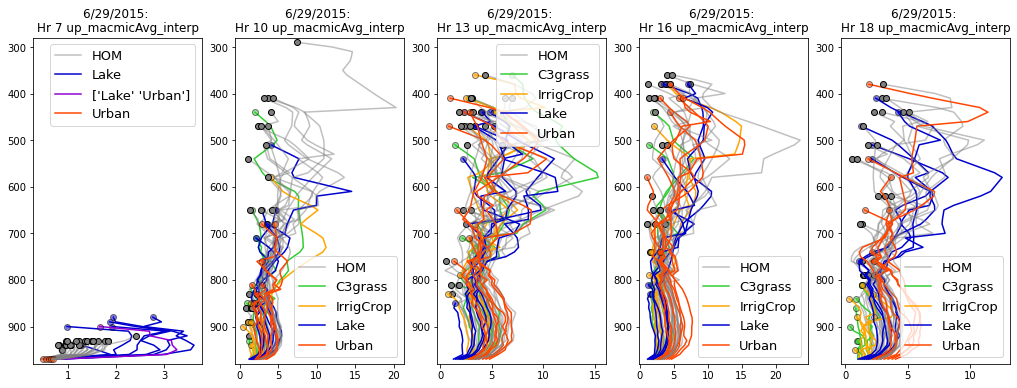

In [116]:
# ----- Plume speed by surface type ----- #
hrSel = [7,10,13,16,18]

# monSel = [6,6, 6,8, 8]
# daySel = [6,9,27,1,29]
monSel = [6]
daySel = [29]

ctrlCase = 'clubbMF_L0eq250'
testCase = 'claspMF_L0eq250'
levVar = 'levInterp'

# varSel = 'edmf_upthl_interp'
varSel = 'up_macmicAvg_interp'


for iDate in range(len(monSel)): 
    dateString = str(monSel[iDate])+'/'+str(daySel[iDate])+'/2015'
    
    iSelTimes = np.where( (scamDS['time.month']==monSel[iDate]) & 
                          (scamDS['time.day']==daySel[iDate]) )[0]
    
    thisDay      = scamDS.isel(time=iSelTimes)
    thisDay_h2   = scamDS_h2.isel(time=iSelTimes)

    ## Compute CAPE and CIN
    cape = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    cin  = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    lcl  = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    lfc  = np.full([len(thisDay.case.values), len(thisDay.time.values)], np.nan)
    
    for iCase in range(len(thisDay.case.values)):
        for iHr in range(len(thisDay.time.values)):
            ## Calculate CAPE? 
            p = np.flip(thisDay.levInterp.values) * units.hPa
            T = np.flip(thisDay.isel(case=iCase, time=iHr).T_interp.values) * units.K 
            Q = np.flip(thisDay.isel(case=iCase, time=iHr).Q_interp.values) * units('kg/kg')
            Td = dewpoint_from_specific_humidity(p, T, Q)
            # compture parcel temperature
            prof = parcel_profile(p, T[0], Td[0]).to('K')
            cape1,cin1 = cape_cin(p, T, Td, prof)
            cape[iCase,iHr] = cape1.magnitude
            cin[iCase,iHr] = cin1.magnitude
            
            lclp, lclt = mpcalc.lcl(p[0], T[0], Td[0])
            lfcp, _ = mpcalc.lfc(p, T, Td)
            lcl[iCase,iHr] = lclp.magnitude
            lfc[iCase,iHr] = lfcp.magnitude
            
    thisDay['CAPE']  = (('case','time'), cape)
    thisDay['CIN']  = (('case','time'), cin)
    thisDay['LCL'] = (('case','time'), lcl)
    thisDay['LFC'] = (('case','time'), lfc)
    
    
    fig,axs = plt.subplots(1,len(hrSel), figsize = (3.5*len(hrSel), 6))
    axs = axs.ravel()

    print('Hour   LCL (HOM / HET)    LFC (HOM / HET)   nPlumes>LCL (HOM / HET)   nPlumes>LFC (HOM / HET) ' )

    
    for ihrs in range(len(hrSel)): 
#         iHours = np.where((thisDay_h2['time.hour'].values==hrSel[ihrs]) )[0]

#         theseHours = thisDay_h2.isel(time=iHours).mean(dim='time')    
        
        thisHour = thisDay_h2.isel(time=np.where(thisDay_h2['time.hour'].values==hrSel[ihrs])[0])
        thisHour_LCL = thisDay.LCL.isel(time=np.where(thisDay['time.hour'].values==hrSel[ihrs])[0])
        thisHour_LFC = thisDay.LFC.isel(time=np.where(thisDay['time.hour'].values==hrSel[ihrs])[0])
        
        homLabel     = 0
        grassLabel   = 0
        lakeLabel    = 0 
        urbanLabel   = 0
        irrigLabel   = 0
        lakeUrbLabel = 0
        grassIrrLabel = 0
        irrLakeLabel  = 0
        
        plumesGTlcl_HOM = 0
        plumesGTlcl_HET = 0
        
        plumesGTlfc_HOM = 0
        plumesGTlfc_HET = 0
        
        for iEns in range(len(thisHour.nens.values)):
            ensSel1 = thisHour.sel(case=ctrlCase).isel(nens=iEns)
            ensSel2 = thisHour.sel(case=testCase).isel(nens=iEns)
            
            HOMlcl = thisHour_LCL.sel(case=ctrlCase).resample(time='1H').mean(dim='time').values
            HOMlfc = thisHour_LFC.sel(case=ctrlCase).resample(time='1H').mean(dim='time').values
            HETlcl = thisHour_LCL.sel(case=testCase).resample(time='1H').mean(dim='time').values
            HETlfc = thisHour_LFC.sel(case=testCase).resample(time='1H').mean(dim='time').values

            # Color lines based on surface type...
            thisEns = ensSel2['plumeLabel']
            res = all(ele == thisEns.values[0] for ele in thisEns.values)
            if res==True: 
                plumeLabel = thisEns.values[0]
                # print('All plumes are ', plumeLabel)
            else: 
                plumeLabel = np.unique(thisEns.values)
                # print(plumeLabel)

            if len(plumeLabel)==2:
                if ((plumeLabel[0]=='C3grass') & (plumeLabel[1]=='IrrigCrop')): pltcolor = 'firebrick'
                elif ((plumeLabel[0]=='IrrigCrop') & (plumeLabel[1]=='Urban')): pltcolor = 'darkviolet'
                elif ((plumeLabel[0]=='IrrigCrop') & (plumeLabel[1]=='Lake')): pltcolor = 'aqua'
                elif ((plumeLabel[0]=='Off') & (plumeLabel[1]=='Urban')): pltcolor = 'darkviolet'
                elif ((plumeLabel[0]=='Lake') & (plumeLabel[1]=='Urban')): pltcolor = 'darkviolet'
            else:   
                if plumeLabel=='C3grass': pltcolor = 'limegreen'
                elif plumeLabel=='Lake': pltcolor ='mediumblue'
                elif plumeLabel=='Urban': pltcolor='orangered'
                elif plumeLabel=='IrrigCrop': pltcolor='orange'


            ## Plot the HOM case
            if homLabel==0:
                axs[ihrs].plot(np.squeeze(ensSel1[varSel].resample(time='1H').mean(dim='time').values), ensSel1[levVar].values,color='grey',alpha=0.5, label='HOM')
                iTop = np.where(np.isfinite(np.squeeze(ensSel1[varSel].resample(time='1H').mean(dim='time').values)))[0]
                if np.sum(iTop)>=1: 
                    axs[ihrs].plot(np.squeeze(ensSel1[varSel].resample(time='1H').mean(dim='time').values)[iTop[0]], ensSel1[levVar].values[iTop[0]],'o',color='grey',markeredgecolor='k', label='_nolegend_')
                    if ensSel1[levVar].values[iTop[0]]<=HOMlcl: 
                        plumesGTlcl_HOM = plumesGTlcl_HOM+1
                    if ensSel1[levVar].values[iTop[0]]<=HOMlfc: 
                        plumesGTlfc_HOM = plumesGTlfc_HOM+1
                        
                homLabel = 1
            else:
                axs[ihrs].plot(np.squeeze(ensSel1[varSel].resample(time='1H').mean(dim='time').values), ensSel1[levVar].values,color='grey',alpha=0.5, label='_nolegend_')
                iTop = np.where(np.isfinite(np.squeeze(ensSel1[varSel].resample(time='1H').mean(dim='time').values)))[0]
                if np.sum(iTop)>=1: 
                    axs[ihrs].plot(np.squeeze(ensSel1[varSel].resample(time='1H').mean(dim='time').values)[iTop[0]], ensSel1[levVar].values[iTop[0]],'o',color='grey',markeredgecolor='k', label='_nolegend_')
                    if ensSel1[levVar].values[iTop[0]]<=HOMlcl: 
                        plumesGTlcl_HOM = plumesGTlcl_HOM+1
                    if ensSel1[levVar].values[iTop[0]]<=HOMlfc: 
                        plumesGTlfc_HOM = plumesGTlfc_HOM+1
                        
                        
            ## Plot each sfc HET case
            if len(plumeLabel)==2: 
                if ((plumeLabel[0]=='Lake') & (plumeLabel[1]=='Urban')): 
                    if lakeUrbLabel==0:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label=plumeLabel)
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                        lakeUrbLabel = 1
                    else:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label='_nolegend_')
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                            
                if ((plumeLabel[0]=='C3grass') & (plumeLabel[1]=='IrrigCrop')): 
                    if grassIrrLabel==0:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label=plumeLabel)
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                                
                        grassIrrLabel = 1
                    else:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label='_nolegend_')
                        iTop = np.where(np.isfinite(enp.squeeze(nsSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                                
                if ((plumeLabel[0]=='IrrigCrop') & (plumeLabel[1]=='Lake')):
                    if irrLakeLabel==0:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label=plumeLabel)
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                    
                        irrLakeLabel = 1
                    else:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label='_nolegend_')
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1

                            
            else:
                if plumeLabel=='C3grass':
                    if grassLabel==0:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label=plumeLabel)
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                        
                        grassLabel = 1
                    else:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label='_nolegend_')
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                                
                if plumeLabel=='Urban':
                    if urbanLabel==0:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label=plumeLabel)
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                                
                        urbanLabel = 1
                    else:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label='_nolegend_')
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                                
                if plumeLabel=='IrrigCrop':
                    if irrigLabel==0:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label=plumeLabel)
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                    
                        irrigLabel = 1
                    else:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label='_nolegend_')
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1

                if plumeLabel=='Lake':
                    if lakeLabel==0:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label=plumeLabel)
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                        lakeLabel = 1
                    else:
                        axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean().values), ensSel2[levVar].values,color=pltcolor, label='_nolegend_')
                        iTop = np.where(np.isfinite(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)))[0]
                        if np.sum(iTop)>=1: 
                            axs[ihrs].plot(np.squeeze(ensSel2[varSel].resample(time='1H').mean(dim='time').values)[iTop[0]], ensSel2[levVar].values[iTop[0]],'o',alpha=0.5,color=pltcolor,markeredgecolor='k', label='_nolegend_')
                            if ensSel1[levVar].values[iTop[0]]<=HETlcl: 
                                plumesGTlcl_HET = plumesGTlcl_HET+1
                            if ensSel1[levVar].values[iTop[0]]<=HETlfc: 
                                plumesGTlfc_HET = plumesGTlfc_HET+1
                                

        axs[ihrs].invert_yaxis()
        axs[ihrs].set_title(dateString+': \nHr '+str(hrSel[ihrs])+' '+varSel)
        # axs.legend(ncol=1, bbox_to_anchor=(0.85, 0.55))
        axs[ihrs].legend(fontsize=13)
        axs[ihrs].set_ylim([980,280])
        
        #print('Hour     nPlumes>LCL (HOM / HET)     nPlumes>LFC (HOM / HET) ' )
        print('%3i %7i / %3i %12i / %3i  %12i / %2i %18i / %2i' % (hrSel[ihrs],HOMlcl,HETlcl,HOMlfc,HETlfc,
                                             plumesGTlcl_HOM,plumesGTlcl_HET, plumesGTlfc_HOM, plumesGTlfc_HET) )
    

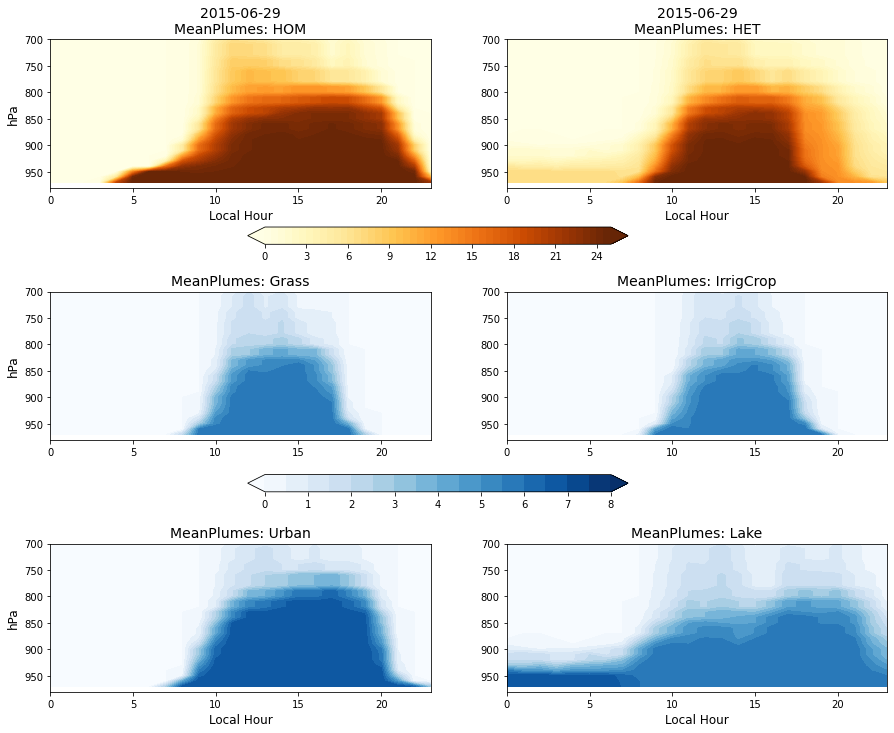

In [237]:

selCase_HOM = 'clubbMF_L0eq250'
selCase_HET = 'claspMF_L0eq250'

monSel = [6]
daySel = [29]


for iDay in range(len(monSel)):
    # dateStrings = str(monSel[iDate])+'/'+str(daySel[iDate])+'/2015'

    iSelTimes = np.where( (scamDS['time.month']==monSel[iDate]) & 
                          (scamDS['time.day']==daySel[iDate]) )[0]
    
    scamDS_day = scamDS.isel(time=iSelTimes)
    
    ## Look at diurnal cycle of plume initiations?
    nplumes_grassMean  = scamDS_day.sel(case=selCase_HET).nPlumesActive_grass.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
    nplumes_cropMean   = scamDS_day.sel(case=selCase_HET).nPlumesActive_crop.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
    nplumes_urbanMean  = scamDS_day.sel(case=selCase_HET).nPlumesActive_urban.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
    nplumes_lakeMean   = scamDS_day.sel(case=selCase_HET).nPlumesActive_lake.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

    nplumes_HOMmean    = scamDS_day.sel(case=selCase_HOM).nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
    nplumes_HETmean    = scamDS_day.sel(case=selCase_HET).nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

        ## ----- Plot that ----- 
    fig,axs = plt.subplots(3,2, figsize=(15,12))
    axs = axs.ravel()

    ## Plot overall means 
    axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                    nplumes_HOMmean.values.transpose(), np.arange(0,25.5,0.5), 
                    cmap = 'YlOrBr', extend='both')
    axs[0].set_title(str(scamDS_day.time.values[0])[0:10]+'\n'+'MeanPlumes: HOM', fontsize=14)

    cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                    nplumes_HETmean.values.transpose(), np.arange(0,25.5,0.5), 
                    cmap = 'YlOrBr', extend='both')
    axs[1].set_title(str(scamDS_day.time.values[0])[0:10]+'\n'+'MeanPlumes: HET', fontsize=14)

    # add colorbar for overall mean cases 
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


    ## Plot patch data 
    axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                    nplumes_grassMean.values.transpose(), np.arange(0,8.5,0.5), 
                    cmap = 'Blues', extend='both')
    axs[2].set_title('MeanPlumes: Grass', fontsize=14)

    cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                    nplumes_cropMean.values.transpose(), np.arange(0,8.5,0.5), 
                    cmap = 'Blues', extend='both')
    axs[3].set_title('MeanPlumes: IrrigCrop', fontsize=14)
    # add colorbar for individual patches 
    ax_position = axs[3].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
    cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

    axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                    nplumes_urbanMean.values.transpose(), np.arange(0,8.5,0.5), 
                    cmap = 'Blues', extend='both')
    axs[4].set_title('MeanPlumes: Urban', fontsize=14)

    cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                    nplumes_lakeMean.values.transpose(), np.arange(0,8.5,0.5), 
                    cmap = 'Blues', extend='both')
    axs[5].set_title('MeanPlumes: Lake', fontsize=14)
    
#     axs[5].axvline(9, color='k')
#     axs[0].axvline(12, color='k')
#     axs[0].axvline(16, color='k')
#     axs[1].axvline(12, color='k')
#     axs[1].axvline(16, color='k')
    # axs[0].axvline(9,color='k')
    # axs[0].axvline(11,color='k')    
    # axs[1].axvline(9,color='k')
    # axs[1].axvline(11,color='k')
        
    ## Other plot options 
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()

    axs[0].set_ylim([980,700])
    axs[1].set_ylim([980,700])
    axs[2].set_ylim([980,700])
    axs[3].set_ylim([980,700])
    axs[4].set_ylim([980,700])
    axs[5].set_ylim([980,700])

    axs[0].set_xlabel('Local Hour', fontsize=12)
    axs[1].set_xlabel('Local Hour', fontsize=12)
    axs[4].set_xlabel('Local Hour', fontsize=12)
    axs[5].set_xlabel('Local Hour', fontsize=12)

    axs[0].set_ylabel('hPa', fontsize=12)
    axs[2].set_ylabel('hPa', fontsize=12)
    axs[4].set_ylabel('hPa', fontsize=12)


    fig.subplots_adjust(hspace = 0.7)



#### Sanity checking

In [81]:
iHr = 12
varPlot = 'T_interp'
t,p250 = stats.ttest_rel(scamDS[varPlot].sel(case='clubbMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                         scamDS[varPlot].sel(case='claspMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                         nan_policy = 'omit')
# if p250<0.05:
#     pVal_250[iHr,iLev]=1
iVal250 = np.where(p250<0.05)[0]
pVal_250[iHr,iVal250]=1


In [82]:
pVal_250[iHr,:]


array([nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan])

In [74]:
for iHr in range(24): 
    t,p = stats.ttest_rel(scamDS['T_interp'].sel(case='clubbMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                          scamDS['T_interp'].sel(case='claspMF_L0eq250').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                          nan_policy = 'omit')
    
    levSel = np.where(scamDS.levInterp.values==800.0)[0]
    
    print(iHr,'   ', p[0],p[-1], p[levSel])


0     0.4985251306809787 1.0423108741695363e-14 [2.63207781e-12]
1     0.5713176868025391 5.927297146576252e-14 [2.29387422e-08]
2     0.9442964230210529 1.1143573211886203e-13 [1.59737726e-07]
3     0.601397562147812 7.475029779838112e-13 [1.68326447e-05]
4     0.3270736973373308 3.0941634438316453e-12 [5.36662021e-05]
5     0.3397652726855903 5.549700188409427e-12 [4.53348245e-05]
6     0.989087613541053 2.0010692954538493e-11 [1.03060761e-05]
7     0.5392824846599797 2.9717872232483235e-11 [2.53493607e-06]
8     0.3941222894449221 7.176049841085603e-11 [2.68981234e-06]
9     0.7866148945177612 4.399338217815624e-06 [8.78577388e-06]
10     0.843590284346964 0.03726810881716932 [3.02612312e-07]
11     0.7675435812039465 0.7684413670892468 [3.53492258e-07]
12     0.7116639914499325 0.06060973625914129 [5.29019266e-08]
13     0.5946183637551811 0.002377189359334092 [1.30886429e-09]
14     0.49530803552971936 0.00017353937316666235 [2.60128845e-11]
15     0.4409630131476151 2.32456811876

*Looking into using the t-test (paired) for significance*

In [28]:
for iHr in range(24): 
    t,p = stats.ttest_rel(scamDS['TREFHT'].sel(case='clubbMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                          scamDS['TREFHT'].sel(case='claspMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                          nan_policy = 'omit')
    print(iHr,'   ', p)


0     2.496420985822547e-11
1     3.360980532334515e-11
2     4.601359495061191e-11
3     5.452589058639927e-11
4     4.9157373849312816e-11
5     1.6596826317683964e-11
6     5.674193327515573e-11
7     1.4405465751509917e-10
8     8.84202432522572e-08
9     0.0022407043901075366
10     0.13069287292450585
11     0.9915805826680808
12     0.17230992170103065
13     0.10347683981797987
14     0.01792706422935449
15     0.018523924121539206
16     0.04629674151901725
17     0.271880625726536
18     0.7967822142089407
19     0.2726553878966701
20     0.028375420439787413
21     0.0004243524660194522
22     0.00013894598437356198
23     0.00018450843565955834


In [70]:
iHr=1
stats.ttest_rel(scamDS['SHFLX'].sel(case='clubbMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'),
               scamDS['SHFLX'].sel(case='claspMF_L0eq50').where(scamDS['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'))



Ttest_relResult(statistic=-7.562673824249669, pvalue=3.050766166217317e-11)

In [29]:
iHr =15

ctrl = scamDS['TREFHT'].sel(case='clubbMF_L0eq50').resample(time='1H').mean()
ctrl = ctrl.where(ctrl['time.hour']==iHr).dropna(dim='time')
test = scamDS['TREFHT'].sel(case='claspMF_L0eq50').resample(time='1H').mean()
test = test.where(test['time.hour']==iHr).dropna(dim='time')

diff = test-ctrl

np.nanmean(diff)/(np.nanstd(diff)/np.sqrt(len(diff)-1))


2.3980627657719427

In [30]:
stats.ttest_rel(test,ctrl)

Ttest_relResult(statistic=2.398062681915317, pvalue=0.018523924121539206)

In [32]:
np.nanmean(diff)

0.086122595

In [33]:
np.nanstd(diff)

0.34259203

## Look into certain categories of days; maybe some things are more sensitive on different kinds of days?

In [11]:
## Use Meng's definition of clear/cloudy/rain days 

q_var = 'CLDLIQ_interp'
q_ctl  = scamDS.sel(case='clubbMF_L0eq250')[q_var]
q_test = scamDS.sel(case='claspMF_L0eq250')[q_var]

p_var = 'PRECT'
p_ctl  = scamDS.sel(case='clubbMF_L0eq250')[p_var]
p_test = scamDS.sel(case='claspMF_L0eq250')[p_var]

# plim = 0.5   #mm/day -- Value used in Huang et al. 
qlim = 1e-6  #kg/kg  -- Value used in Huang et al. 

plim = 1   #mm/day
# qlim = 4e-10  #kg/kg

minHr = 6
maxHr = 18

selHours = np.where( (scamDS['time.hour'].values>=minHr) & (scamDS['time.hour'].values<=maxHr) )[0]

levSel     = np.where((scamDS.levInterp.values>600))[0]

# Daily mean rain rate in right units:
p_dailyMean = p_ctl.isel(time=selHours).resample(time='1D').mean(dim='time')*1e3*86400
p_dailyMean_test = p_test.isel(time=selHours).resample(time='1D').mean(dim='time')*1e3*86400

# Select lower levels
q_dailyMax = q_ctl.isel(levInterp=levSel, time=selHours).resample(time='1D').mean(dim='time').max(dim='levInterp')
q_dailyMax_test = q_test.isel(levInterp=levSel, time=selHours).resample(time='1D').mean(dim='time').max(dim='levInterp')


# Define days using their indices...
iRainDay  = np.where(  (p_dailyMean >= plim) & (p_dailyMean_test >= plim) )[0]

iCloudDay = np.where( (p_dailyMean < plim) & (q_dailyMax>=qlim) & 
                      (p_dailyMean_test < plim) & (q_dailyMax_test>=qlim))[0]

iClearDay = np.where( (p_dailyMean < plim) & (q_dailyMax<qlim) & 
                      (p_dailyMean_test < plim) & (q_dailyMax_test<qlim))[0]

print('Number of rainy  days: ', len(iRainDay))
print('Number of cloudy days: ', len(iCloudDay))
print('Number of clear  days: ', len(iClearDay))


Number of rainy  days:  39
Number of cloudy days:  10
Number of clear  days:  34


In [99]:
np.nanpercentile(p_dailyMean, 50)

0.8184187041479163

In [23]:
# Also get those days in the full DS 

iclear_times  = []
icloudy_times = []
irainy_times  = []
for iT in range(len(p_dailyMean.time.values)):
    thisDay = p_dailyMean.isel(time=iT)
    iTimes = np.where((scamDS['time.year'].values==thisDay['time.year'].values) & 
                      (scamDS['time.month'].values==thisDay['time.month'].values) &
                      (scamDS['time.day'].values==thisDay['time.day'].values))[0]
    
    if iT in iClearDay:
        iclear_times = np.append(iclear_times, iTimes) 
    elif iT in iCloudDay:
        icloudy_times = np.append(icloudy_times, iTimes) 
    elif iT in iRainDay: 
        irainy_times = np.append(irainy_times, iTimes) 
    else:
        print('Day not defined!! iT = ',iT)
        
clearDays_DS  = scamDS.isel(time=iclear_times.astype(int))
cloudyDays_DS = scamDS.isel(time=icloudy_times.astype(int))
rainyDays_DS  = scamDS.isel(time=irainy_times.astype(int))


Day not defined!! iT =  0
Day not defined!! iT =  4
Day not defined!! iT =  6
Day not defined!! iT =  20
Day not defined!! iT =  22
Day not defined!! iT =  40
Day not defined!! iT =  48
Day not defined!! iT =  70
Day not defined!! iT =  83


In [24]:
clearDays_DS_h2  = scamDS_h2.isel(time=iclear_times.astype(int))
cloudyDays_DS_h2 = scamDS_h2.isel(time=icloudy_times.astype(int))
rainyDays_DS_h2  = scamDS_h2.isel(time=irainy_times.astype(int))

clearDays_clmDS  = clmDS_h2.isel(time=iclear_times.astype(int))
cloudyDays_clmDS = clmDS_h2.isel(time=icloudy_times.astype(int))
rainyDays_clmDS  = clmDS_h2.isel(time=irainy_times.astype(int))


(0.15, 1.42)

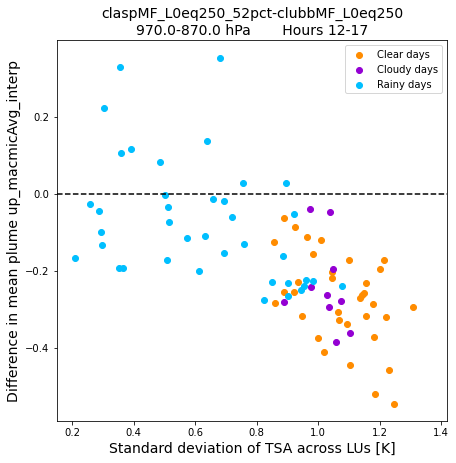

In [26]:
## Choose an hour range
hrStart = 12
hrEnd   = 17

## THE UNIQUE PART: 
## Choose a level range too
levInterpMax = 870.0
levInterpMin = 970.0
ilevSel = np.where( (scamDS_h2.levInterp.values>=levInterpMax) & (scamDS_h2.levInterp.values<=levInterpMin))[0]
maxLev = np.nanmax( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)
minLev = np.nanmin( scamDS_h2.levInterp.isel(levInterp=ilevSel).values)

# var_h2 = 'edmf_upbuoy_interp'
# var_h2 = 'edmf_thlflxup_interp'
var_h2 = 'up_macmicAvg_interp'
clmVar = 'TSA'
# clmVar = 'QFLX'

hrMeanClear_h2 = clearDays_DS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHrClear_h2 = hrMeanClear_h2.isel(time=np.where( (hrMeanClear_h2['time.hour'].values>=hrStart) & (hrMeanClear_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMeanCloudy_h2 = cloudyDays_DS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHrCloudy_h2 = hrMeanCloudy_h2.isel(time=np.where( (hrMeanCloudy_h2['time.hour'].values>=hrStart) & (hrMeanCloudy_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMeanRainy_h2 = rainyDays_DS_h2[var_h2].isel(levInterp=ilevSel).mean(dim='levInterp').resample(time='1H').mean(dim='time')
thisHrRainy_h2 = hrMeanRainy_h2.isel(time=np.where( (hrMeanRainy_h2['time.hour'].values>=hrStart) & (hrMeanRainy_h2['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')


hrMeanClear_clm = clearDays_clmDS[clmVar].resample(time='1H').mean(dim='time')
thisHrClear_clm = hrMeanClear_clm.isel(time=np.where( (hrMeanClear_clm['time.hour'].values>=hrStart) & (hrMeanClear_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMeanCloudy_clm = cloudyDays_clmDS[clmVar].resample(time='1H').mean(dim='time')
thisHrCloudy_clm = hrMeanCloudy_clm.isel(time=np.where( (hrMeanCloudy_clm['time.hour'].values>=hrStart) & (hrMeanCloudy_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')

hrMeanRainy_clm = rainyDays_clmDS[clmVar].resample(time='1H').mean(dim='time')
thisHrRainy_clm = hrMeanRainy_clm.isel(time=np.where( (hrMeanRainy_clm['time.hour'].values>=hrStart) & (hrMeanRainy_clm['time.hour'].values<=hrEnd) )[0]).resample(time='1D').mean(dim='time')


## Set up the plot
fig,axs = plt.subplots(1,1,figsize=(7,7))
ctrlSel = 'clubbMF_L0eq250'
# caseSel = 'claspMF_L0eq250'
caseSel = 'claspMF_L0eq250_52pct'

## Clear days 
HOMwgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((clearDays_DS_h2['time.hour'].values>=hrStart) & (clearDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((clearDays_DS_h2['time.hour'].values>=hrStart) & (clearDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

axs.scatter(thisHrClear_clm.sel(case=ctrlSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         thisHrClear_h2.sel(case=caseSel).weighted(HETwgts_clear).mean(dim='nens') - thisHrClear_h2.sel(case=ctrlSel).weighted(HOMwgts_clear).mean(dim='nens'), 
         c='darkorange', label='Clear days')

## Cloudy days
HOMwgts_cloudy = cloudyDays_DS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((cloudyDays_DS_h2['time.hour'].values>=hrStart) & (cloudyDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts_cloudy = cloudyDays_DS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((cloudyDays_DS_h2['time.hour'].values>=hrStart) & (cloudyDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

axs.scatter(thisHrCloudy_clm.sel(case=ctrlSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         thisHrCloudy_h2.sel(case=caseSel).weighted(HETwgts_cloudy).mean(dim='nens') - thisHrCloudy_h2.sel(case=ctrlSel).weighted(HOMwgts_cloudy).mean(dim='nens'), 
         c='darkviolet', label='Cloudy days')

## Rainy days
HOMwgts_rainy = rainyDays_DS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((rainyDays_DS_h2['time.hour'].values>=hrStart) & (rainyDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts_rainy = rainyDays_DS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((rainyDays_DS_h2['time.hour'].values>=hrStart) & (rainyDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

axs.scatter(thisHrRainy_clm.sel(case=ctrlSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         thisHrRainy_h2.sel(case=caseSel).weighted(HETwgts_rainy).mean(dim='nens') - thisHrRainy_h2.sel(case=ctrlSel).weighted(HOMwgts_rainy).mean(dim='nens'), 
         c='deepskyblue', label='Rainy days')

# Other plot options
axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [K]',fontsize=14)
# axs.set_xlabel('Standard deviation of '+clmVar+' across LUs [mm/s]',fontsize=14)
axs.set_ylabel('Difference in mean plume '+var_h2,fontsize=14)
axs.set_title(caseSel+'-'+ctrlSel+'\n'+str(maxLev)+'-'+str(minLev)+' hPa       Hours '+str(hrStart)+'-'+str(hrEnd), fontsize=14)
axs.legend()
axs.axhline(0,color='k',linestyle='--')

# axs.set_ylim([-0.65, 0.9])
# axs.set_xlim([0, 9e-5])
axs.set_xlim([0.15, 1.42])


In [29]:
## Plot all the days together...?

## Prep data...
ctrlSel = 'clubbMF_L0eq250'
caseSel = 'claspMF_L0eq250'

hourlyDS_clear  = clearDays_DS.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_cloudy = cloudyDays_DS.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_rainy  = rainyDays_DS.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')

hourlyDS_h2_clear  = clearDays_DS_h2.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_h2_cloudy = cloudyDays_DS_h2.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDS_h2_rainy  = rainyDays_DS_h2.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')

hourlyDSclm_h2_clear  = clearDays_clmDS.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDSclm_h2_cloudy = cloudyDays_clmDS.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')
hourlyDSclm_h2_rainy  = rainyDays_clmDS.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').groupby('time.hour').mean(dim='time')


In [64]:
# HOMwgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
# HETwgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.sel(case=caseSel).resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

wgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').fillna(0)
hourlyDS_h2_clear_wgted = clearDays_DS_h2.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').weighted(wgts_clear).mean(dim='nens').groupby('time.hour').mean(dim='time')

wgts_cloudy = cloudyDays_DS_h2.upa_macmicAvg_interp.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').fillna(0)
hourlyDS_h2_cloudy_wgted = cloudyDays_DS_h2.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').weighted(wgts_cloudy).mean(dim='nens').groupby('time.hour').mean(dim='time')

wgts_rainy = rainyDays_DS_h2.upa_macmicAvg_interp.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').fillna(0)
hourlyDS_h2_rainy_wgted = rainyDays_DS_h2.sel(case=[ctrlSel, caseSel]).resample(time='1H').mean(dim='time').weighted(wgts_rainy).mean(dim='nens').groupby('time.hour').mean(dim='time')



In [48]:
test1 = clearDays_DS_h2.edmf_upthl_interp.sel(case=caseSel).resample(time='1H').mean(dim='time').fillna(0)


In [62]:
wgtTest = clearDays_DS_h2.edmf_upthl_interp.sel(case=[caseSel]).resample(time='1H').mean(dim='time').weighted(wgts_clear).mean(dim='nens')

In [63]:
wgtTest.isel(time=160, levInterp=-1).values

array([309.78436532])

In [65]:
test1.isel(time=160, levInterp=-1).mean(dim='nens')

<xarray.DataArray 'edmf_upthl_interp' ()>
array(310.02108897)
Coordinates:
    time       datetime64[ns] 2015-06-09T16:00:00
    lat        float64 36.6
    lon        float64 262.5
    levInterp  float64 970.0
    ncyc       int64 0
    case       <U15 'claspMF_L0eq250'

In [58]:
wgts_clear.sel(case=caseSel).isel(time=160, levInterp=-1).values

array([0.00668701, 0.00432726, 0.00263141, 0.0015037 , 0.00080748,
       0.00040747, 0.00668701, 0.00432726, 0.00263141, 0.0015037 ,
       0.00080748, 0.00040747, 0.00668701, 0.00432726, 0.00263141,
       0.0015037 , 0.00080748, 0.00040747, 0.00589227, 0.00408652,
       0.00270744, 0.00171355, 0.00103602, 0.00059837, 0.00033015])

Text(0.5, 0, 'Local Hour')

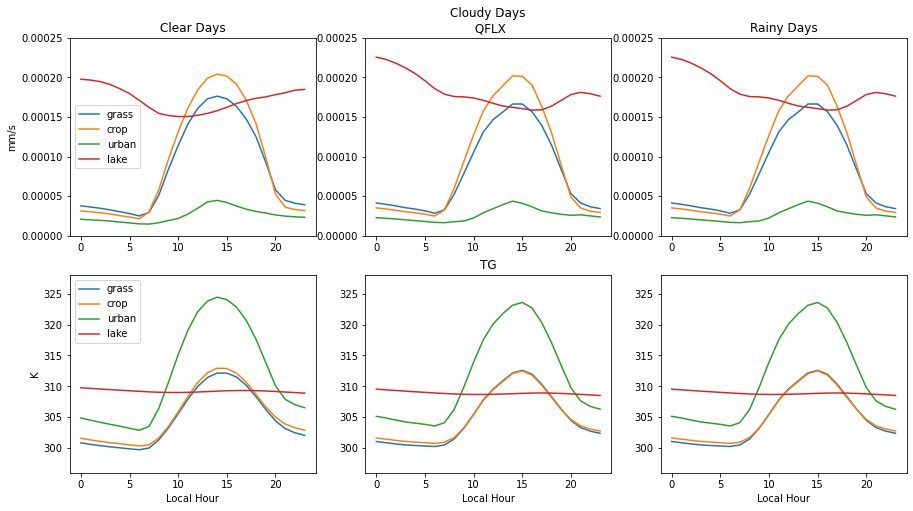

In [123]:
## What about making the plots? 

# ----- CLM plots ----- #
fig,axs = plt.subplots(2,3,figsize=(15,8))
axs     = axs.ravel()

for iLU in range(4):
    axs[0].plot(hourlyDSclm_h2_clear['hour'].values, hourlyDSclm_h2_clear.sel(case='clubbMF_L0eq250').isel(landunit=iLU).QFLX.values)
    axs[3].plot(hourlyDSclm_h2_clear['hour'].values, hourlyDSclm_h2_clear.sel(case='clubbMF_L0eq250').isel(landunit=iLU).TG.values)

    axs[1].plot(hourlyDSclm_h2_cloudy['hour'].values, hourlyDSclm_h2_cloudy.sel(case='clubbMF_L0eq250').isel(landunit=iLU).QFLX.values)
    axs[4].plot(hourlyDSclm_h2_cloudy['hour'].values, hourlyDSclm_h2_cloudy.sel(case='clubbMF_L0eq250').isel(landunit=iLU).TG.values)

    axs[2].plot(hourlyDSclm_h2_rainy['hour'].values, hourlyDSclm_h2_cloudy.sel(case='clubbMF_L0eq250').isel(landunit=iLU).QFLX.values)
    axs[5].plot(hourlyDSclm_h2_rainy['hour'].values, hourlyDSclm_h2_cloudy.sel(case='clubbMF_L0eq250').isel(landunit=iLU).TG.values)

axs[0].legend(['grass','crop','urban','lake'])   
axs[3].legend(['grass','crop','urban','lake'])   

axs[0].set_title('Clear Days') 
axs[1].set_title('Cloudy Days\n QFLX')
axs[2].set_title('Rainy Days')
axs[4].set_title('TG')

axs[0].set_ylim([0.0, 0.00025])
axs[1].set_ylim([0.0, 0.00025])
axs[2].set_ylim([0.0, 0.00025])
axs[3].set_ylim([296, 328])
axs[4].set_ylim([296, 328])
axs[5].set_ylim([296, 328])

axs[0].set_ylabel('mm/s')
axs[3].set_ylabel('K')

axs[3].set_xlabel('Local Hour')
axs[4].set_xlabel('Local Hour')    
axs[5].set_xlabel('Local Hour')    
    

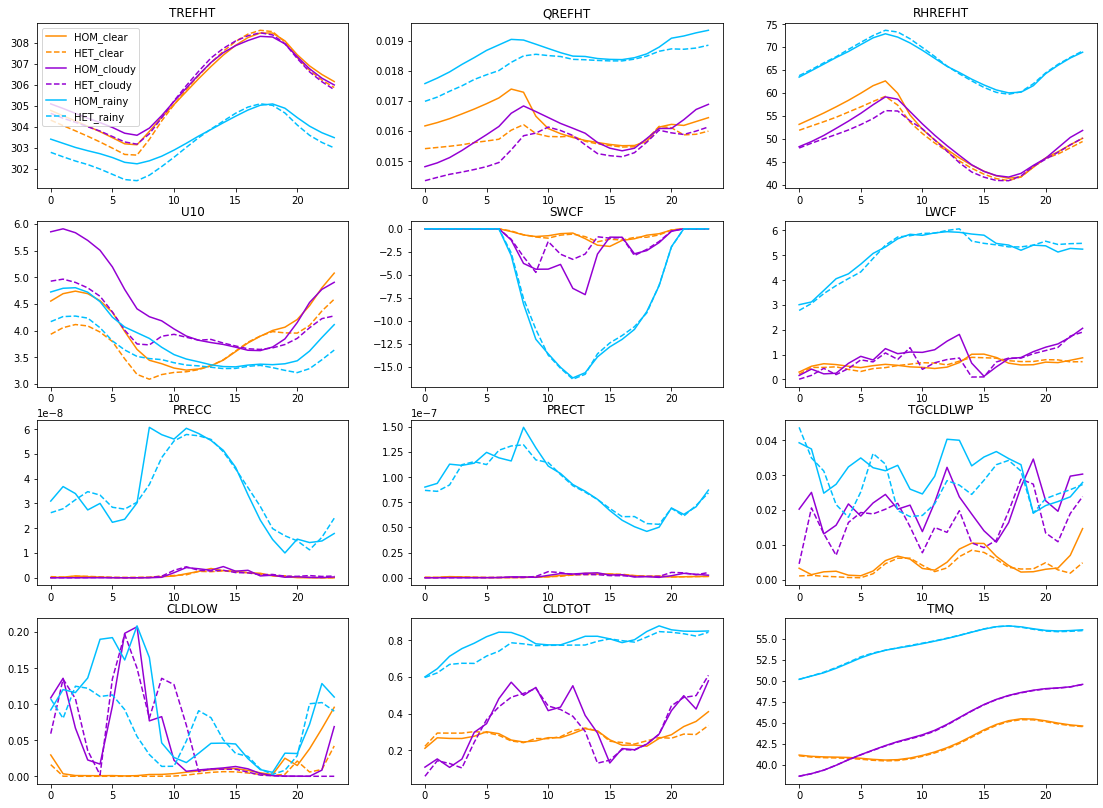

In [84]:
# ----- 2D CAM plots ----- #
pltVars = ['TREFHT','QREFHT','RHREFHT',
           'U10','SWCF','LWCF','PRECC',
           'PRECT','TGCLDLWP',
          'CLDLOW','CLDTOT','TMQ']  

fig,axs = plt.subplots(4,3, figsize=(19,14))
axs     = axs.ravel()

for iVar in range(len(pltVars)): 
    axs[iVar].plot(hourlyDS_clear['hour'].values, hourlyDS_clear[pltVars[iVar]].sel(case=ctrlSel), 
                   color='darkorange', label='HOM_clear' )
    axs[iVar].plot(hourlyDS_clear['hour'].values, hourlyDS_clear[pltVars[iVar]].sel(case=caseSel), 
                   '--', color='darkorange', label='HET_clear' )
    
    axs[iVar].plot(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy[pltVars[iVar]].sel(case=ctrlSel), 
                   color='darkviolet', label='HOM_cloudy' )
    axs[iVar].plot(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy[pltVars[iVar]].sel(case=caseSel), 
                   '--', color='darkviolet', label='HET_cloudy' )
        
    axs[iVar].plot(hourlyDS_rainy['hour'].values, hourlyDS_rainy[pltVars[iVar]].sel(case=ctrlSel), 
                   color='deepskyblue', label='HOM_rainy' )
    axs[iVar].plot(hourlyDS_rainy['hour'].values, hourlyDS_rainy[pltVars[iVar]].sel(case=caseSel), 
                   '--', color='deepskyblue', label='HET_rainy' )
    
    if pltVars[iVar]=='TREFHT':    
        axs[iVar].legend()
    axs[iVar].set_title(pltVars[iVar])


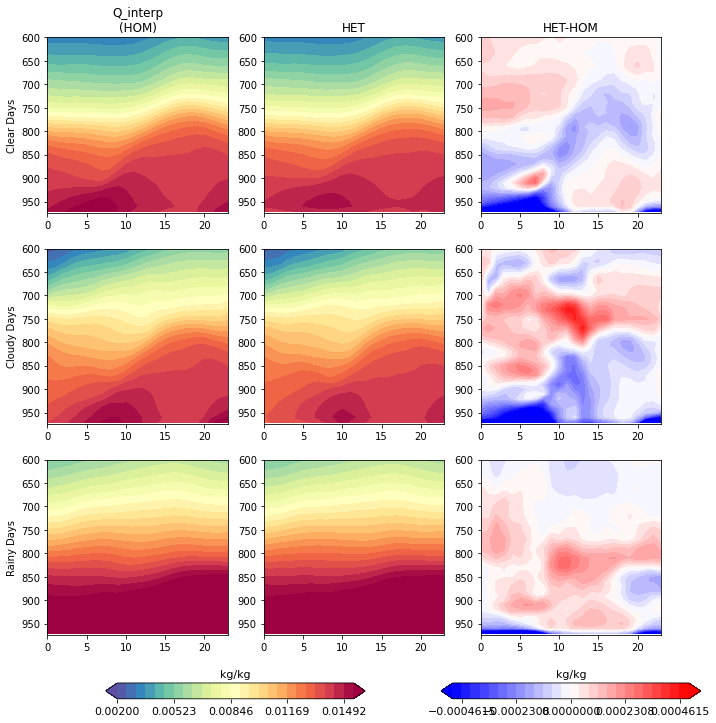

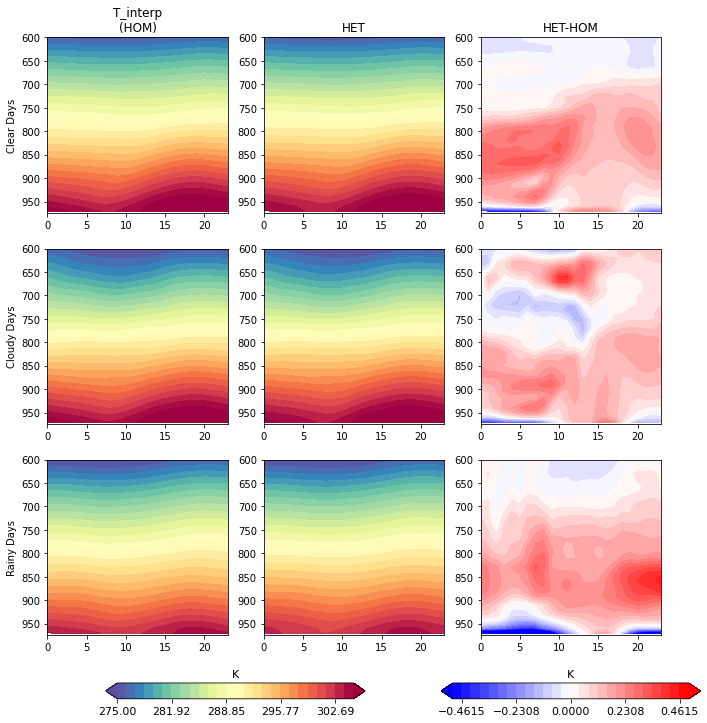

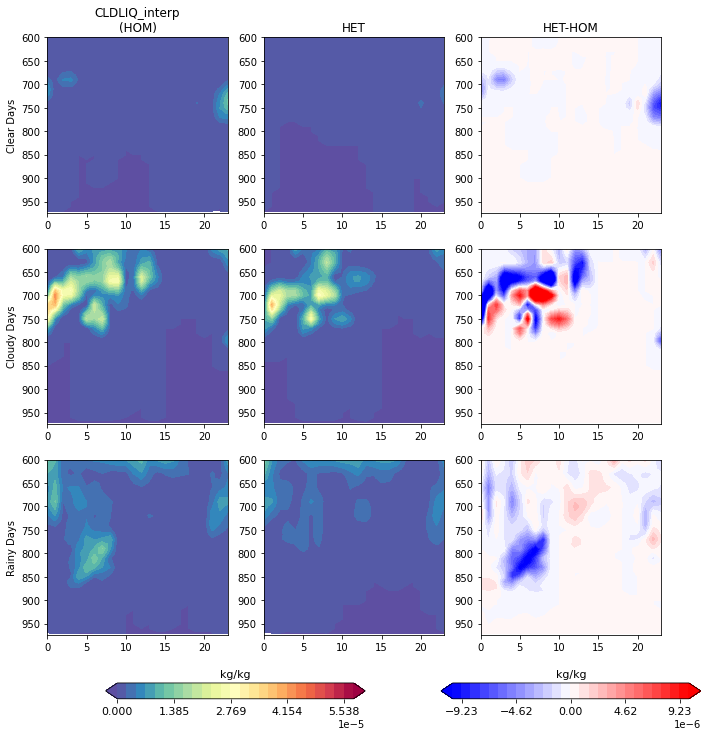

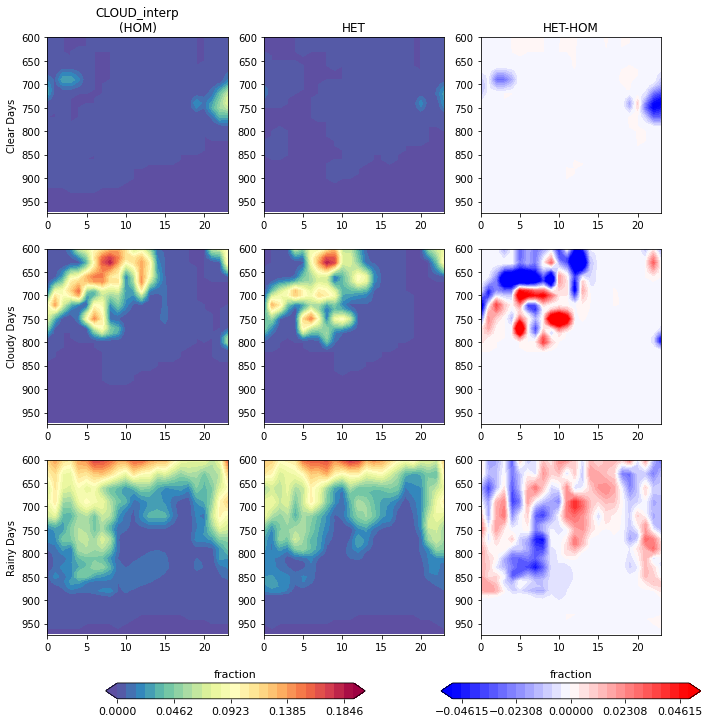

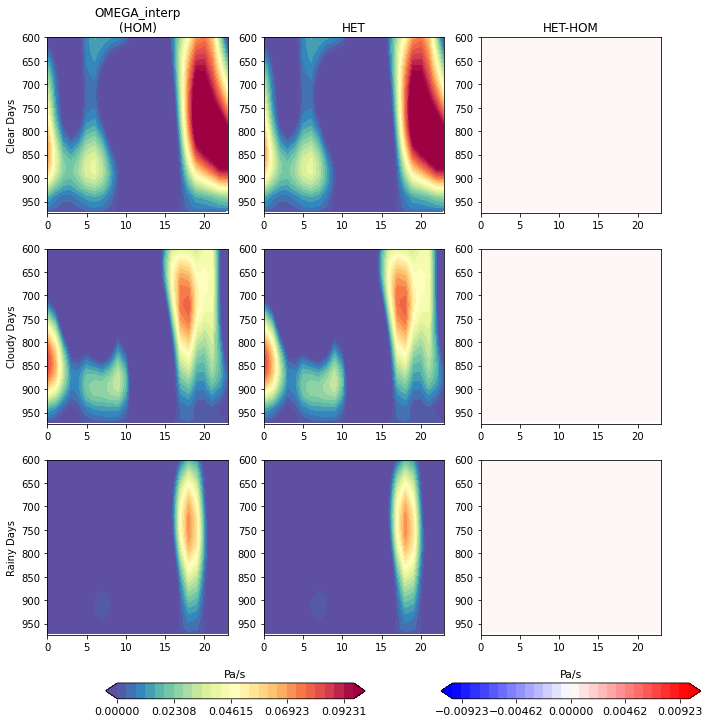

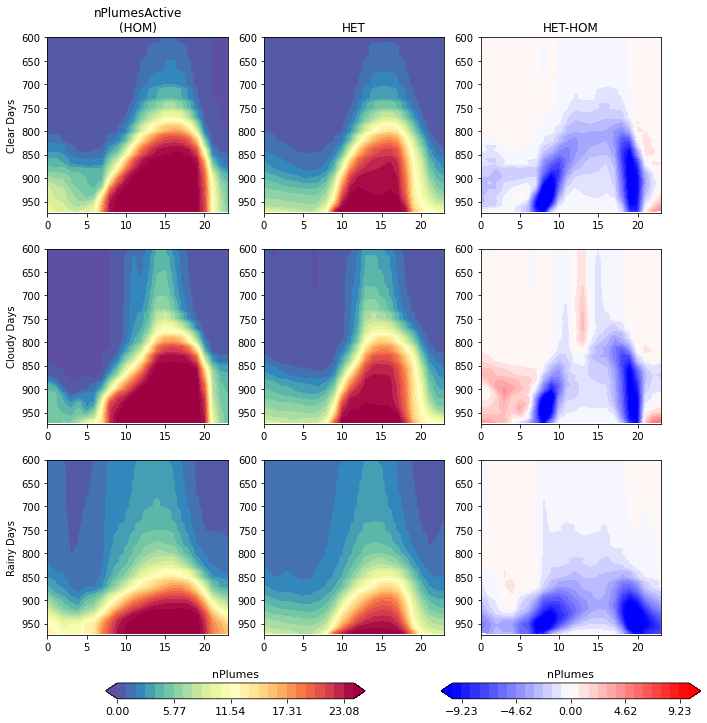

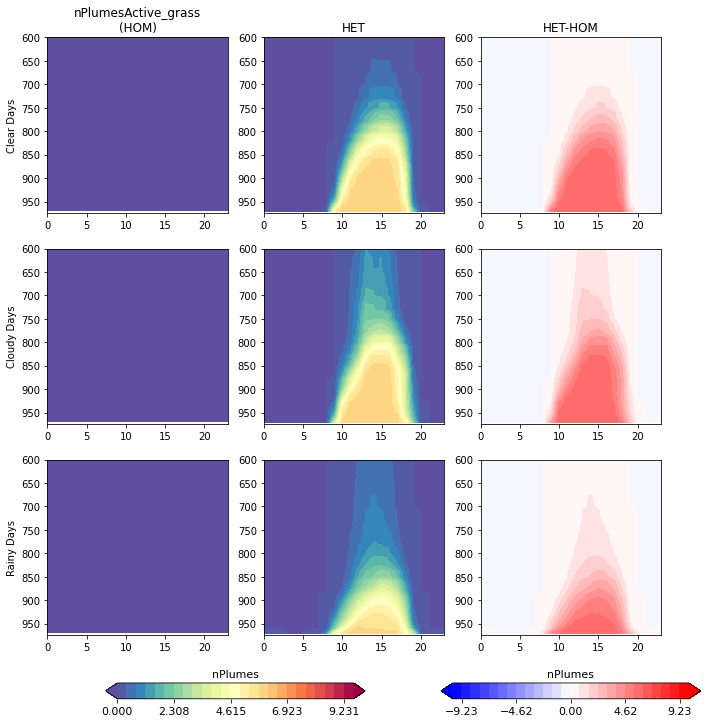

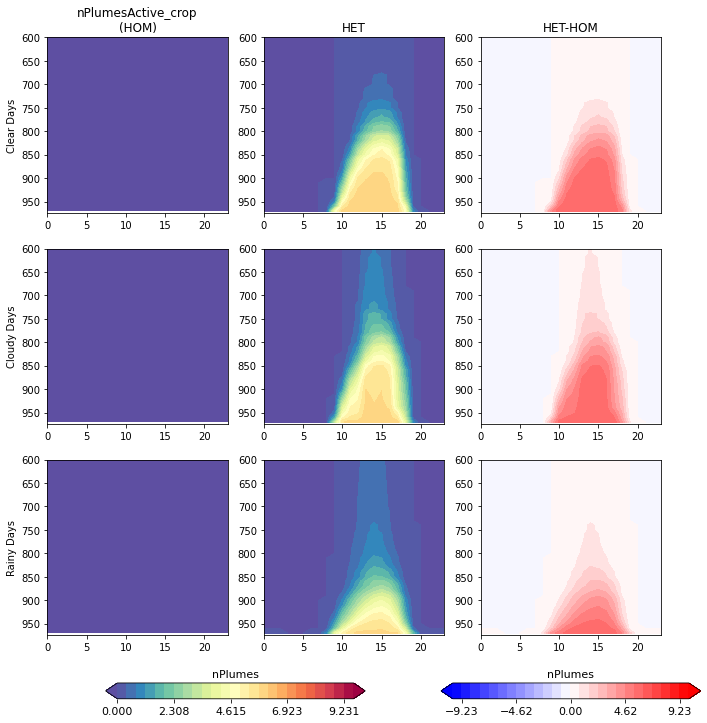

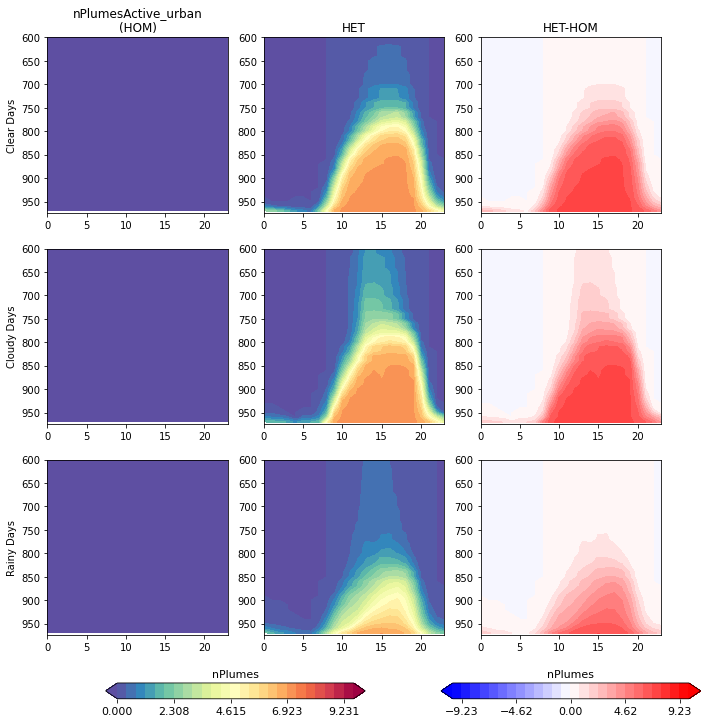

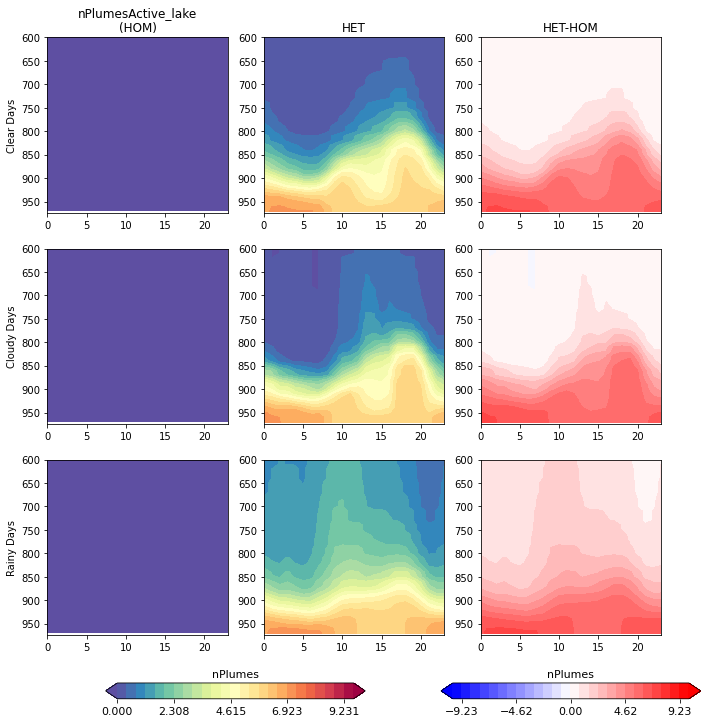

In [82]:
# ----- 3D CAM plots ----- #
pltVars = ['Q_interp','T_interp','CLDLIQ_interp','CLOUD_interp','OMEGA_interp','nPlumesActive',
          'nPlumesActive_grass','nPlumesActive_crop','nPlumesActive_urban','nPlumesActive_lake']

cMin    = [0.002, 275,    0.0,  0.0,    0,    0, 
          0, 0, 0, 0,]
cMax    = [0.016, 305,   6e-5,  0.2,   0.1, 25, 
          10, 10, 10, 10]
diffMax = [0.0005, 0.5,  1e-5, 0.05, 0.01,   10, 
          10, 10, 10, 10]
unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['CLDLIQ'].units, 
           scamDS['CLOUD'].units, scamDS['OMEGA'].units, 'nPlumes',
             'nPlumes',  'nPlumes',  'nPlumes',  'nPlumes']
maxLev  = 600.0

for iVar in range(len(pltVars)): 
    fig,axs = plt.subplots(3,3,figsize=(11,11))
    axs     = axs.ravel()

    ## Clear Days 
    axs[0].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                       np.squeeze(hourlyDS_clear[pltVars[iVar]].sel(case=ctrlSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[1].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                       np.squeeze(hourlyDS_clear[pltVars[iVar]].sel(case=caseSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_clear[pltVars[iVar]].sel(case=caseSel)) - np.squeeze(hourlyDS_clear[pltVars[iVar]].sel(case=ctrlSel))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[2].contourf(hourlyDS_clear['hour'].values, hourlyDS_clear['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')

    ## Cloudy Days 
    axs[3].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       np.squeeze(hourlyDS_cloudy[pltVars[iVar]].sel(case=ctrlSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[4].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       np.squeeze(hourlyDS_cloudy[pltVars[iVar]].sel(case=caseSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_cloudy[pltVars[iVar]].sel(case=caseSel)) - np.squeeze(hourlyDS_cloudy[pltVars[iVar]].sel(case=ctrlSel))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[5].contourf(hourlyDS_cloudy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    
    ## Rainy Days 
    axs[6].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                       np.squeeze(hourlyDS_rainy[pltVars[iVar]].sel(case=ctrlSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    cplt = axs[7].contourf(hourlyDS_rainy['hour'].values, hourlyDS_rainy['levInterp'].values, 
                       np.squeeze(hourlyDS_rainy[pltVars[iVar]].sel(case=caseSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    ax_position = axs[7].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    
    diffVar = np.squeeze(hourlyDS_rainy[pltVars[iVar]].sel(case=caseSel)) - np.squeeze(hourlyDS_rainy[pltVars[iVar]].sel(case=ctrlSel))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[8].contourf(hourlyDS_rainy['hour'].values, hourlyDS_cloudy['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    # Add colorbar
    ax_position = axs[8].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    axs[0].set_title(pltVars[iVar]+'\n(HOM)')
    axs[1].set_title('HET')
    axs[2].set_title('HET-HOM')

    axs[0].set_ylabel('Clear Days')
    axs[3].set_ylabel('Cloudy Days')
    axs[6].set_ylabel('Rainy Days') 
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([975,maxLev])
    axs[1].set_ylim([975,maxLev])
    axs[2].set_ylim([975,maxLev])
    axs[3].set_ylim([975,maxLev])
    axs[4].set_ylim([975,maxLev])
    axs[5].set_ylim([975,maxLev])
    axs[6].set_ylim([975,maxLev])
    axs[7].set_ylim([975,maxLev])
    axs[8].set_ylim([975,maxLev])


In [44]:
HOMwgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.sel(case=ctrlSel).isel(levInterp=ilevSel, time=np.where((clearDays_DS_h2['time.hour'].values>=hrStart) & (clearDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)
HETwgts_clear = clearDays_DS_h2.upa_macmicAvg_interp.sel(case=caseSel).isel(levInterp=ilevSel, time=np.where((clearDays_DS_h2['time.hour'].values>=hrStart) & (clearDays_DS_h2['time.hour'].values<=hrEnd))[0] ).mean(dim='levInterp').resample(time='1H').mean(dim='time').resample(time='1D').mean(dim='time').fillna(0)

axs.scatter(thisHrClear_clm.sel(case=ctrlSel).std(dim='landunit'), 
         # np.nanstd(thisHr_h2.sel(case=ctrlSel).isel(levInterp=0), axis=1), 
         thisHrClear_h2.sel(case=caseSel).weighted(HETwgts_clear).mean(dim='nens') - thisHrClear_h2.sel(case=ctrlSel).weighted(HOMwgts_clear).mean(dim='nens'), 
         c='darkorange', label='Clear days')


<xarray.DataArray 'total_wpthlp' ()>
array(-0.00400632)
Coordinates:
    lat      float64 36.6
    lon      float64 262.5
    ncyc     int64 0

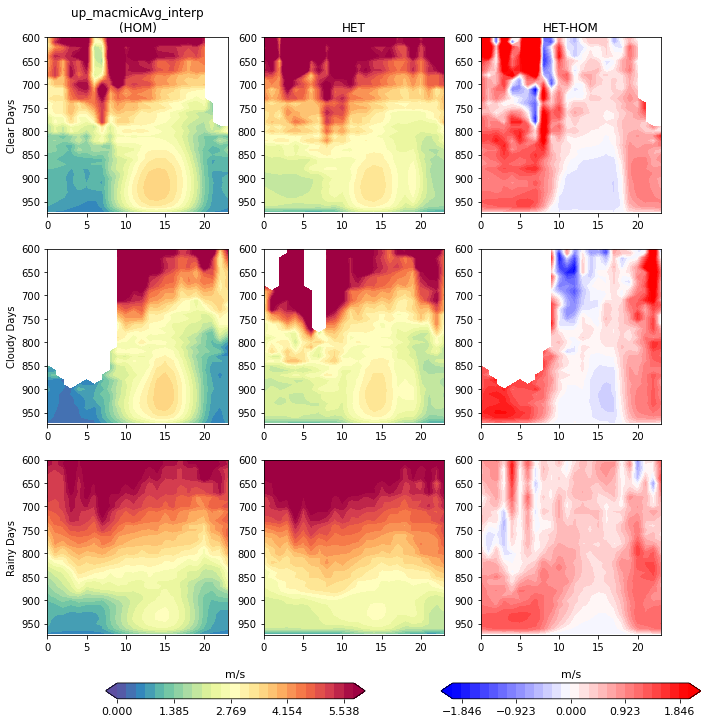

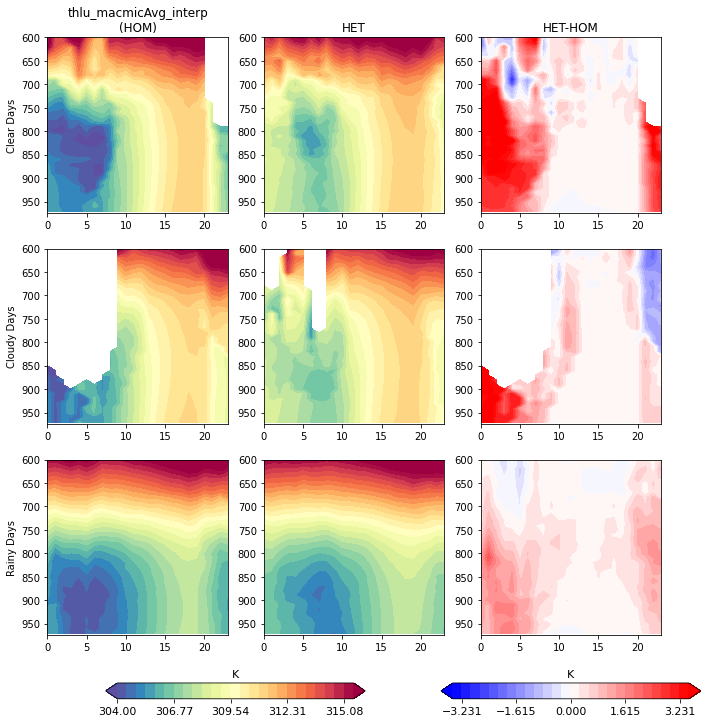

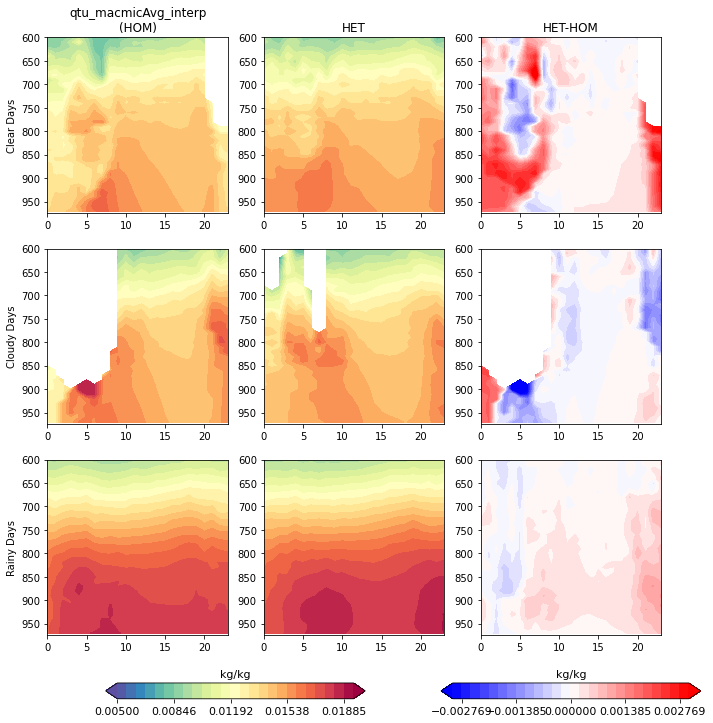

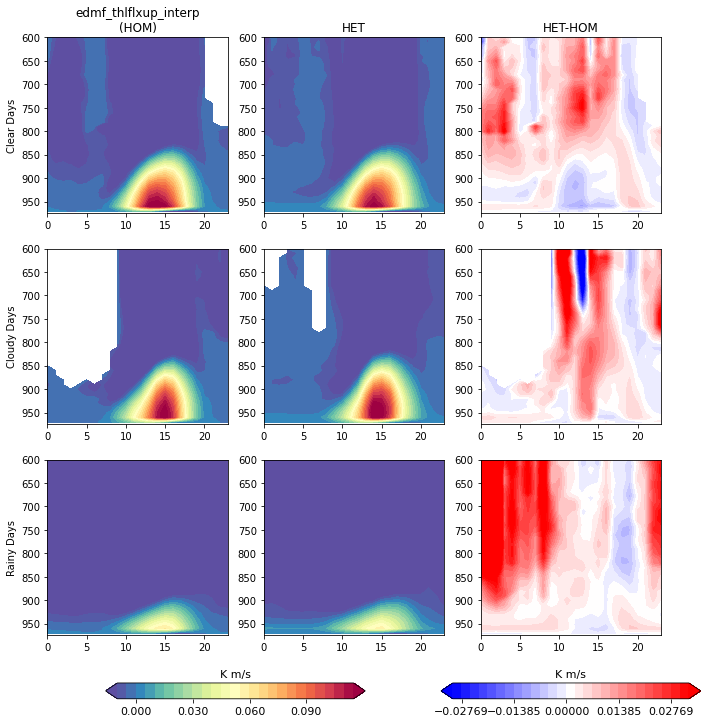

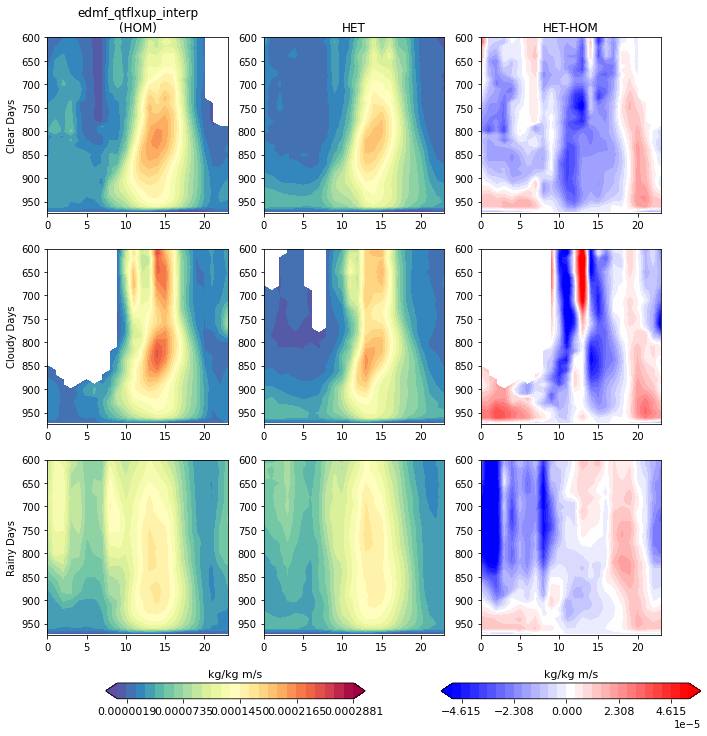

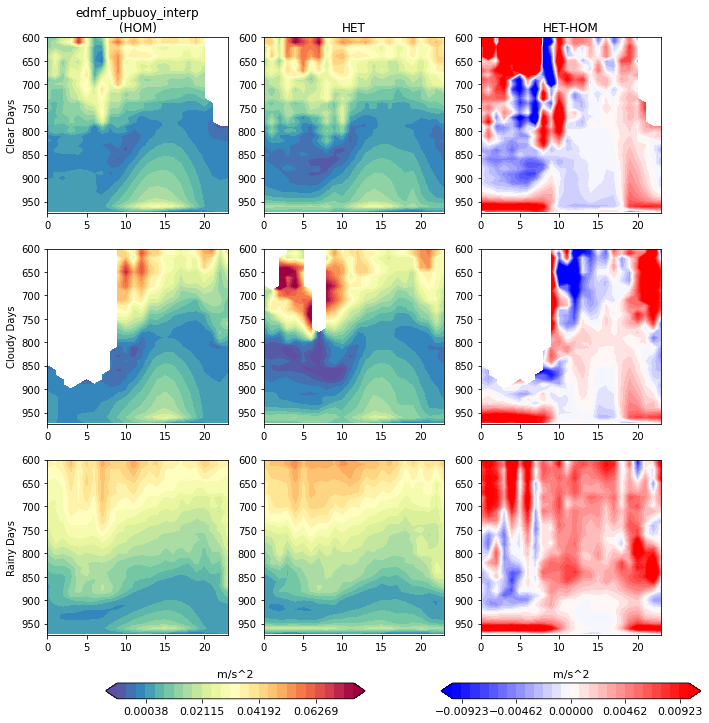

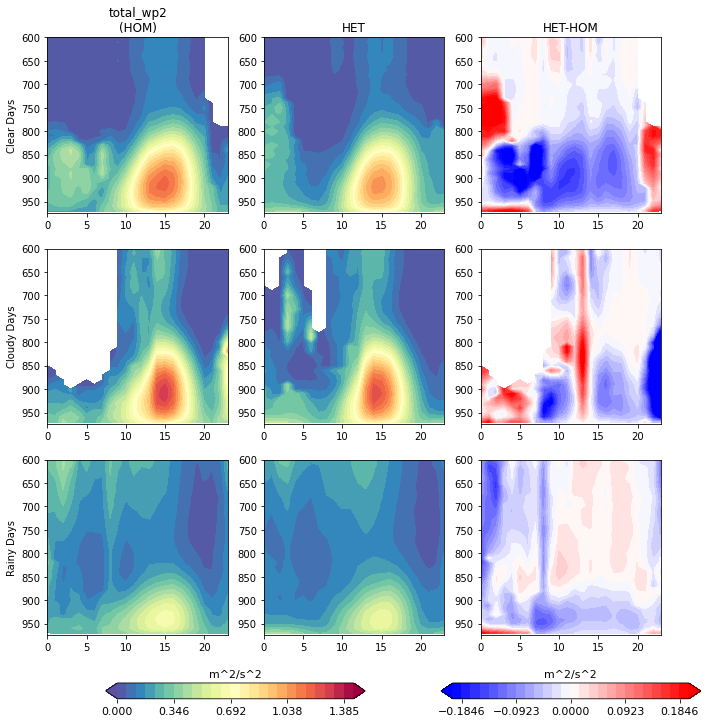

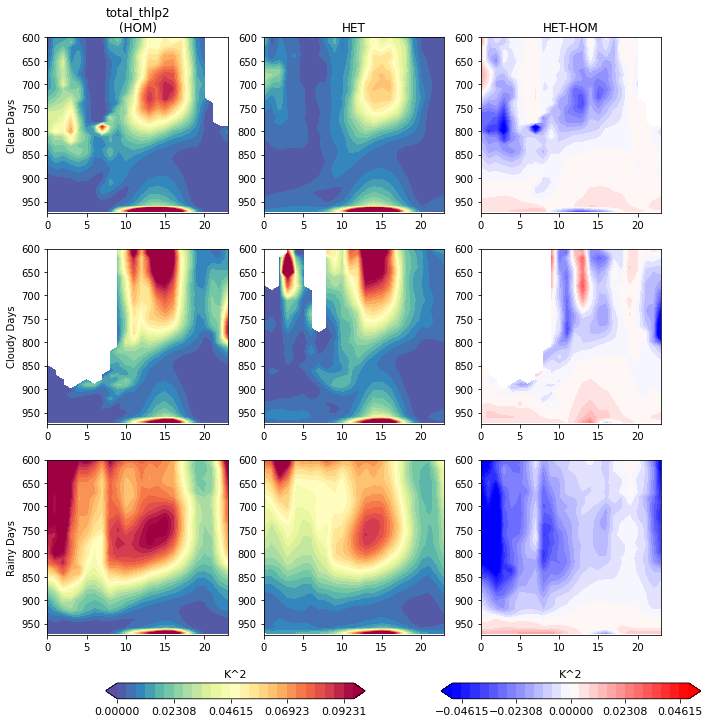

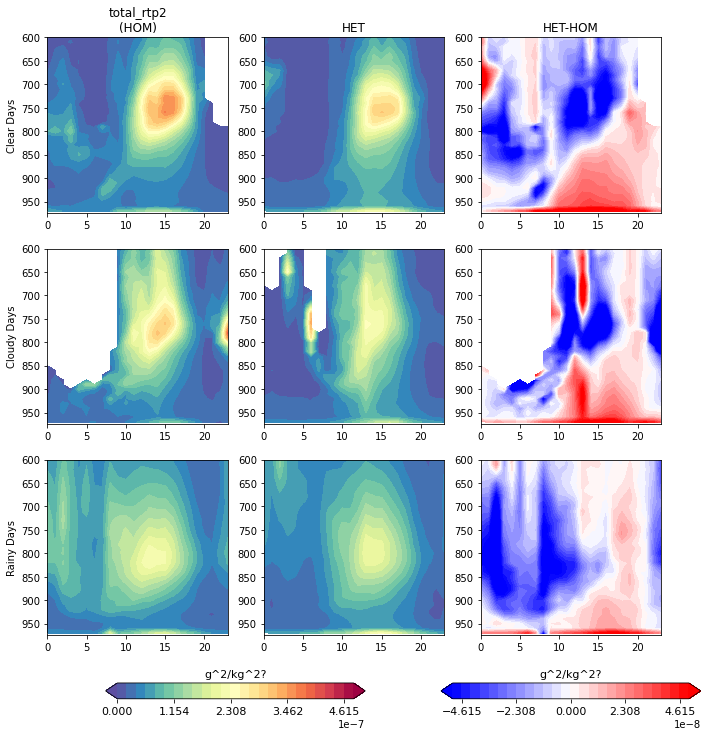

In [79]:
# ----- 3D CAM plots ----- #
pltVars = ['up_macmicAvg_interp','thlu_macmicAvg_interp','qtu_macmicAvg_interp',
           'edmf_thlflxup_interp','edmf_qtflxup_interp','edmf_upbuoy_interp',
           'total_wp2','total_thlp2','total_rtp2',
           # 'total_wpthlp','total_wprtp',
          ]

cMin    = [0,    304,     5e-3,   -0.01,     -1e-5,     -0.01,    0.0,     0.0,     0.0,      -0.02]
cMax    = [6,    316,     0.02,    0.12,      3e-4,      0.08,    1.5,     0.1,   5e-7,      0.02]
diffMax = [2,    3.5,    0.003,    0.03,      5e-5,      0.01,    0.2,    0.05,   5e-8,     0.005]
unitsStr = ['m/s', 'K', 'kg/kg', 'K m/s', 'kg/kg m/s', 'm/s^2', 'm^2/s^2', 'K^2', 'g^2/kg^2?', '']
maxLev  = 600.0

for iVar in range(len(pltVars)): 
    fig,axs = plt.subplots(3,3,figsize=(11,11))
    axs     = axs.ravel()

    ## Clear Days 
    axs[0].contourf(hourlyDS_h2_clear_wgted['hour'].values, hourlyDS_h2_clear_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].sel(case=ctrlSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[1].contourf(hourlyDS_h2_clear_wgted['hour'].values, hourlyDS_h2_clear_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].sel(case=caseSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].sel(case=caseSel)) - np.squeeze(hourlyDS_h2_clear_wgted[pltVars[iVar]].sel(case=ctrlSel))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[2].contourf(hourlyDS_h2_clear_wgted['hour'].values, hourlyDS_h2_clear_wgted['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')

    ## Cloudy Days 
    axs[3].contourf(hourlyDS_h2_cloudy_wgted['hour'].values, hourlyDS_h2_cloudy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].sel(case=ctrlSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    axs[4].contourf(hourlyDS_h2_cloudy_wgted['hour'].values, hourlyDS_h2_cloudy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].sel(case=caseSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    
    diffVar = np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].sel(case=caseSel)) - np.squeeze(hourlyDS_h2_cloudy_wgted[pltVars[iVar]].sel(case=ctrlSel))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[5].contourf(hourlyDS_h2_cloudy_wgted['hour'].values, hourlyDS_h2_cloudy['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    
    ## Rainy Days 
    axs[6].contourf(hourlyDS_h2_rainy_wgted['hour'].values, hourlyDS_h2_rainy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].sel(case=ctrlSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    cplt = axs[7].contourf(hourlyDS_h2_rainy_wgted['hour'].values, hourlyDS_h2_rainy_wgted['levInterp'].values, 
                       np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].sel(case=caseSel)).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    ax_position = axs[7].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    
    diffVar = np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].sel(case=caseSel)) - np.squeeze(hourlyDS_h2_rainy_wgted[pltVars[iVar]].sel(case=ctrlSel))
    nstep = (2*diffMax[iVar])/26
    cplt = axs[8].contourf(hourlyDS_h2_rainy_wgted['hour'].values, hourlyDS_h2_rainy_wgted['levInterp'].values, 
                       diffVar.transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
                       cmap='bwr', extend='both')    
    # Add colorbar
    ax_position = axs[8].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.08, ax_position.width+0.1, 0.02])
    cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(unitsStr[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 

    axs[0].set_title(pltVars[iVar]+'\n(HOM)')
    axs[1].set_title('HET')
    axs[2].set_title('HET-HOM')

    axs[0].set_ylabel('Clear Days')
    axs[3].set_ylabel('Cloudy Days')
    axs[6].set_ylabel('Rainy Days') 
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()

    axs[0].set_ylim([975,maxLev])
    axs[1].set_ylim([975,maxLev])
    axs[2].set_ylim([975,maxLev])
    axs[3].set_ylim([975,maxLev])
    axs[4].set_ylim([975,maxLev])
    axs[5].set_ylim([975,maxLev])
    axs[6].set_ylim([975,maxLev])
    axs[7].set_ylim([975,maxLev])
    axs[8].set_ylim([975,maxLev])


In [ ]:
# # LEFT OFF HERE    

#     # ----- 3D EMDF plots ----- #
#     pltVars = ['total_wpthlp', 'total_wprtp', 'total_wp2', 'total_thlp2', 'total_rtp2']
#     cMin    = [0.002, 265,    0.0]
#     cMax    = [0.016, 305, 3.5e-8]
#     diffMax = [0.0005, 0.5, 1.5e-9]
#     unitsStr = [scamDS_h2['WPTHLP_CLUBB'].units, scamDS['WPRTP_CLUBB'].units, scamDS['WP2_CLUBB'].units,
#                 scamDS['THLP2_CLUBB'].units, scamDS['RTP2_CLUBB'].units]
#     maxLev  = 600.0
    
#     for iVar in range(len(pltVars)): 
#         fig,axs = plt.subplots(1,3,figsize=(14,4))
#         axs     = axs.ravel()
    
#         axs[0].contourf(thisDay['time.hour'].values, thisDay['levInterp'].values, 
#                            np.squeeze(thisDay[pltVars[iVar]].sel(case='clubbMF_L0eq250')).transpose(),
#                            np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
#                            cmap='Spectral_r', extend='both')
#         cplt = axs[1].contourf(thisDay['time.hour'].values, thisDay['levInterp'].values, 
#                            np.squeeze(thisDay[pltVars[iVar]].sel(case='claspMF_L0eq250')).transpose(),
#                            np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
#                            cmap='Spectral_r', extend='both')
#         # Add colorbar
#         ax_position = axs[1].get_position()
#         cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
#         cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
#         cbar.ax.locator_params(nbins=6)
#         cbar.ax.set_title(unitsStr[iVar], fontsize=11)
#         cbar.ax.tick_params(labelsize=11) 
        
#         diffVar = np.squeeze(thisDay[pltVars[iVar]].sel(case='claspMF_L0eq250')) - np.squeeze(thisDay[pltVars[iVar]].sel(case='clubbMF_L0eq250'))
#         nstep = (2*diffMax[iVar])/26
#         cplt = axs[2].contourf(thisDay['time.hour'].values, thisDay['levInterp'].values, 
#                    diffVar.transpose(),
#                    np.arange(-diffMax[iVar], diffMax[iVar]+nstep, nstep), 
#                    cmap='bwr', extend='both')
#         # Add colorbar
#         ax_position = axs[2].get_position()
#         cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
#         cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
#         cbar.ax.locator_params(nbins=6)
#         cbar.ax.set_title(unitsStr[iVar], fontsize=11)
#         cbar.ax.tick_params(labelsize=11) 
        
#         axs[0].set_title(dateString+': '+pltVars[iVar]+' (HOM)')
#         axs[1].set_title('HET')
#         axs[2].set_title('HET-HOM')
                               
#         axs[0].invert_yaxis()
#         axs[1].invert_yaxis()
#         axs[2].invert_yaxis()
        
#         axs[0].set_ylim([975,maxLev])
#         axs[1].set_ylim([975,maxLev])
#         axs[2].set_ylim([975,maxLev])

        
#     # ----- 2D CAM plots: profiles? ----- #
#     hrStarts = [5,11,15,19]
#     hrEnds   = [7,13,17,21]
    
#     pltVars = ['Q_interp','T_interp','CLDLIQ_interp','CLOUD_interp',
#                'STEND_CLUBB_interp','RVMTEND_CLUBB_interp','nPlumesActive']
#     # cMin    = [0.002, 265,    0.0, 0.0, 0.0]
#     # cMax    = [0.016, 305, 3.5e-8, 0.7, 25]
#     # unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['CLDLIQ'].units, scamDS['CLOUD'].units]
#     maxLev  = 500.0
    
#     for iVar in range(len(pltVars)):
#         fig,axs = plt.subplots(1,len(hrStarts), figsize = (3.5*len(hrStarts), 3))
#         axs = axs.ravel()
        
#         for ihrs in range(len(hrStarts)): 
#             iHours = np.where((thisDay['time.hour'].values>=hrStarts[ihrs]) & 
#                               (thisDay['time.hour'].values<=hrEnds[ihrs]) )[0]

#             theseHours = thisDay[pltVars[iVar]].isel(time=iHours).mean(dim='time').where(thisDay.levInterp.values>=maxLev)
        
#             axs[ihrs].plot(theseHours.sel(case='clubbMF_L0eq250').values, 
#                            theseHours.levInterp.values, color='dimgrey', label='HOM_L0eq250')

#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250').values, 
#                            theseHours.levInterp.values, color='dodgerblue', label='HET_L0eq250')
            
#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_52pct').values, 
#                            theseHours.levInterp.values, '--', color='orangered', label='HET_L0eq250_52pct')
            
#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_rand').values, 
#                            theseHours.levInterp.values, '-.', color='limegreen', label='HET_L0eq250_rand')
#             if ihrs==0:
#                 axs[ihrs].legend()
#             axs[ihrs].set_title(dateString+': \nHours '+str(hrStarts[ihrs])+'-'+str(hrEnds[ihrs])+'\n'+pltVars[iVar])
            
#             axs[ihrs].invert_yaxis()
#             axs[ihrs].set_ylim([975,maxLev])
            
        
#     # ----- 2D CAM plots (EDMF vars): profiles? ----- #
#     hrStarts = [5,11,15,19]
#     hrEnds   = [7,13,17,21]
    
#     pltVars = ['total_wpthlp', 'total_wprtp', 'total_wp2', 'total_thlp2', 'total_rtp2']
#     cMin    = [ -0.025,  0.0, 0.0,  0.0, 0.0]
#     cMax    = [    0.0, 7e-5, 1.0, 0.03, 9e-8]
#     # unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['CLDLIQ'].units, scamDS['CLOUD'].units]
#     maxLev  = 500.0
    
#     for iVar in range(len(pltVars)):
#         fig,axs = plt.subplots(1,len(hrStarts), figsize = (3.5*len(hrStarts), 3))
#         axs = axs.ravel()
        
#         for ihrs in range(len(hrStarts)): 
#             iHours = np.where((thisDay_h2['time.hour'].values>=hrStarts[ihrs]) & 
#                               (thisDay_h2['time.hour'].values<=hrEnds[ihrs]) )[0]

#             theseHours = thisDay_h2[pltVars[iVar]].isel(time=iHours).mean(dim='time').where(thisDay_h2.levInterp.values>=maxLev)
        
#             axs[ihrs].plot(theseHours.sel(case='clubbMF_L0eq250').values, 
#                            theseHours.levInterp.values, color='dimgrey', label='HOM_L0eq250')

#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250').values, 
#                            theseHours.levInterp.values, color='dodgerblue', label='HET_L0eq250')
            
#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_52pct').values, 
#                            theseHours.levInterp.values, '--', color='orangered', label='HET_L0eq250_52pct')
            
#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_rand').values, 
#                            theseHours.levInterp.values, '-.', color='limegreen', label='HET_L0eq250_rand')
#             if ihrs==0:
#                 axs[ihrs].legend()
#             axs[ihrs].set_title(dateString+': \nHours '+str(hrStarts[ihrs])+'-'+str(hrEnds[ihrs])+'\n'+pltVars[iVar])
            
#             axs[ihrs].invert_yaxis()
#             axs[ihrs].set_ylim([975,maxLev])
            
            
            
            
            
#     # ----- 2D CAM plots (EDMF plume means): profiles? ----- #
#     hrStarts = [5,11,15,19]
#     hrEnds   = [7,13,17,21]
        
#     pltVars = ['edmf_qtflxup_interp', 'edmf_thlflxup_interp','edmf_upbuoy_interp','edmf_upent_interp',
#                'up_macmicAvg_interp', 'thlu_macmicAvg_interp','qtu_macmicAvg_interp']
#     # cMin    = [ -0.025,  0.0, 0.0,  0.0, 0.0]
#     # cMax    = [    0.0, 7e-5, 1.0, 0.03, 9e-8]
#     # unitsStr = [scamDS['Q'].units, scamDS['T'].units, scamDS['CLDLIQ'].units, scamDS['CLOUD'].units]
#     maxLev  = 500.0
        
#     for iVar in range(len(pltVars)):
#         fig,axs = plt.subplots(1,len(hrStarts), figsize = (3.5*len(hrStarts), 3))
#         axs = axs.ravel()
        
#         for ihrs in range(len(hrStarts)): 
#             iHours = np.where((thisDay_h2['time.hour'].values>=hrStarts[ihrs]) & 
#                               (thisDay_h2['time.hour'].values<=hrEnds[ihrs]) )[0]

#             theseHours = thisDay_h2[pltVars[iVar]].isel(time=iHours).mean(dim='time').where(thisDay_h2.levInterp.values>=maxLev)
        
#             theseHoursWgts = thisDay_h2['upa_macmicAvg_interp'].isel(time=iHours).mean(dim='time').where(thisDay_h2.levInterp.values>=maxLev).fillna(0)

#             HOMwgts = theseHoursWgts.sel(case='clubbMF_L0eq250')
#             HETwgts = theseHoursWgts.sel(case='claspMF_L0eq250')
#             HETwgts_52pct = theseHoursWgts.sel(case='claspMF_L0eq250_52pct')
#             HETwgts_rand  = theseHoursWgts.sel(case='claspMF_L0eq250_rand')

        
#             axs[ihrs].plot(theseHours.sel(case='clubbMF_L0eq250').weighted(HOMwgts).mean(dim='nens'), 
#                            theseHours.levInterp.values, color='dimgrey', label='HOM_L0eq250')

#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250').weighted(HETwgts).mean(dim='nens'), 
#                            theseHours.levInterp.values, color='dodgerblue', label='HET_L0eq250')
            
#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_52pct').weighted(HETwgts_52pct).mean(dim='nens'), 
#                            theseHours.levInterp.values, '--', color='orangered', label='HET_L0eq250_52pct')
            
#             axs[ihrs].plot(theseHours.sel(case='claspMF_L0eq250_rand').weighted(HETwgts_rand).mean(dim='nens'), 
#                            theseHours.levInterp.values, '-.', color='limegreen', label='HET_L0eq250_rand')
#             if ihrs==0:
#                 axs[ihrs].legend()
#             axs[ihrs].set_title(dateString+': \nHours '+str(hrStarts[ihrs])+'-'+str(hrEnds[ihrs])+' \n'+pltVars[iVar])
            
#             axs[ihrs].invert_yaxis()
#             axs[ihrs].set_ylim([975,maxLev])
                               

In [91]:
def plotTimeseries_dayClasses(DStoUse, dayClassStr,varPlot, 
                              yMax, yMin, unitsString,setYlims, 
                              valueMultiplier, plotTests250):
    
    # - - - - - - - - - - - - - - - - - 
    fig,axs = plt.subplots(1,3, figsize=(18,5))
    axs     = axs.ravel()

    DS_mean  = (valueMultiplier*DStoUse[varPlot]).groupby('time.hour').mean(dim='time')
    DS_std   = (valueMultiplier*DStoUse[varPlot]).groupby('time.hour').std(dim='time')
    DS_count = (valueMultiplier*DStoUse[varPlot]).groupby('time.hour').count(dim='time')
    DS_SE    = DS_std/np.sqrt(DS_count)
    
    plt.gcf().text(0.45, 1, dayClassStr, fontsize=16)


    ## Paired T-test for significance
    pVal_50   = np.full([24], np.nan)
    pVal_250  = np.full([24], np.nan)
    pVal_Lopt = np.full([24], np.nan)
    for iHr in range(24): 
        t,p50 = stats.ttest_rel(DStoUse[varPlot].sel(case='clubbMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                DStoUse[varPlot].sel(case='claspMF_L0eq50').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                nan_policy = 'omit')
        if p50<0.05: 
            pVal_50[iHr]=1

        t,p250 = stats.ttest_rel(DStoUse[varPlot].sel(case='clubbMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 DStoUse[varPlot].sel(case='claspMF_L0eq250').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                 nan_policy = 'omit')
        if p250<0.05: 
            pVal_250[iHr]=1

        t,pLopt = stats.ttest_rel(DStoUse[varPlot].sel(case='clubbMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                  DStoUse[varPlot].sel(case='claspMF_Lopt6_perPlume').where(DStoUse['time.hour']==iHr).resample(time='1H').mean().dropna(dim='time'), 
                                  nan_policy = 'omit')
        if pLopt<0.05: 
            pVal_Lopt[iHr]=1

    # - - - - - - - - - - - - - - - - - 
    # Plot L0=50 in first panel 
    axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq50').values, color='dodgerblue', label='HOM_L0eq50') 
    axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq50').values, color='orangered', label='HET_L0eq50') 
    axs[0].legend()

    axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq50').values*pVal_50, 'o', color='dodgerblue')
    axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq50').values*pVal_50, 'o', color='orangered')

    axs[0].set_title(varPlot,fontsize=14)
    axs[0].set_ylabel(unitsString, fontsize=12)
    axs[0].set_xlabel('Local Time (hour)', fontsize=12)
    if setYlims==True: 
        axs[0].set_ylim([yMin, yMax])

    # - - - - - - - - - - - - - - - - - 
    # Plot L0=250 in second panel 
    axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq250').values, color='dodgerblue', label='HOM_L0eq250') 
    axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250').values, color='orangered', label='HET_L0eq250') 
    if plotTests250==True:
        axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250_52pct').values, color='darkviolet', label='HET_L0eq250_52pct') 
        axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250_rand').values, color='green', label='claspMF_L0eq250_rand') 
        axs[1].legend(ncol=2)
    else: 
        axs[1].legend()

    axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq250').values*pVal_250, 'o', color='dodgerblue')
    axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250').values*pVal_250, 'o', color='orangered')

    axs[1].set_title(varPlot,fontsize=14)
    axs[1].set_xlabel('Local Time (hour)', fontsize=12) 
    if setYlims==True: 
        axs[1].set_ylim([yMin, yMax])


    # - - - - - - - - - - - - - - - - - 
    # Plot Lopt=6 in third panel 
    axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_Lopt6_perPlume').values, color='dodgerblue', label='HOM_Lopt6') 
    axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_Lopt6_perPlume').values, color='orangered', label='HET_Lopt6') 
    axs[2].legend()

    axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_Lopt6_perPlume').values*pVal_Lopt, 'o', color='dodgerblue')
    axs[2].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_Lopt6_perPlume').values*pVal_Lopt, 'o', color='orangered')

    axs[2].set_title(varPlot,fontsize=14)
    axs[2].set_ylabel(unitsString, fontsize=12)
    axs[2].set_xlabel('Local Time (hour)', fontsize=12)
    if setYlims==True: 
        axs[2].set_ylim([yMin, yMax])
    
    return fig,axs
    

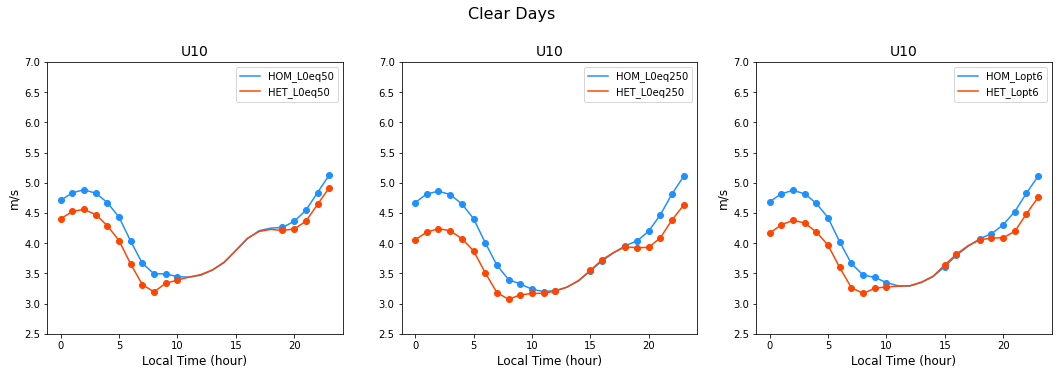

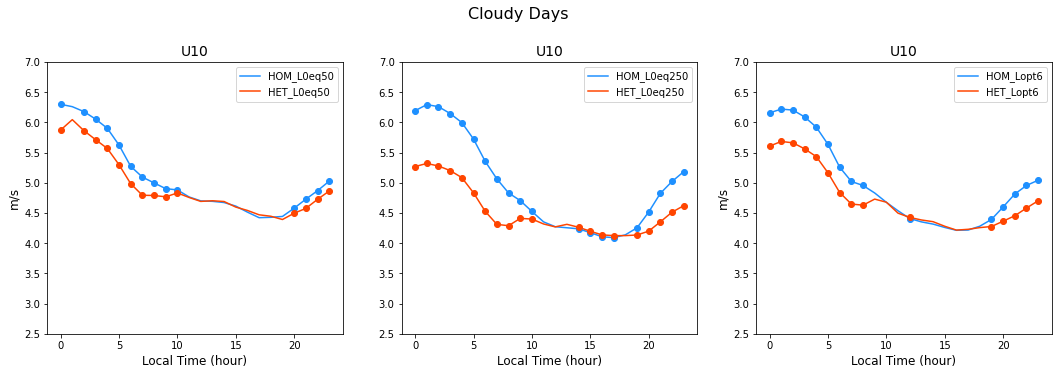

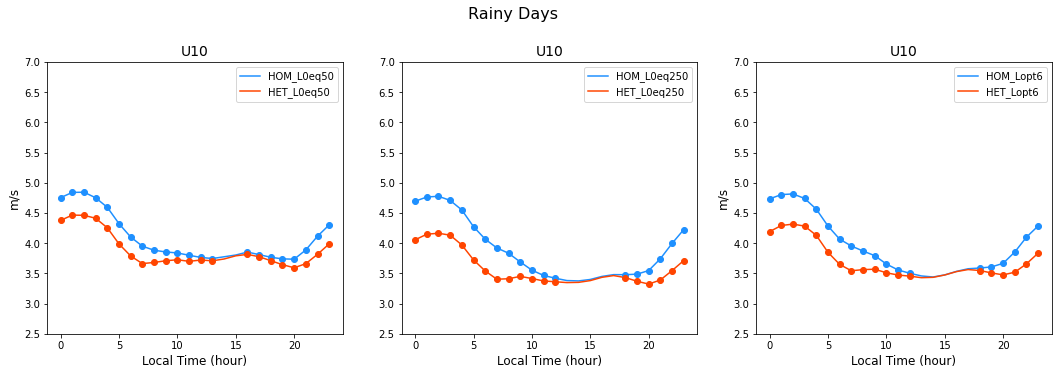

In [60]:

varPlot = 'U10'
yMax    = 7
yMin    = 2.5
unitsString = scamDS[varPlot].units
# unitsString = 'mm/hr'
setYlims = True
plotTests250 = False

# valueMultiplier = (3600*1e3)
valueMultiplier =  1


fig,axs = plotTimeseries_dayClasses(clearDays_DS, 'Clear Days', varPlot,  # DStoUse,dayClassStr,varPlot
                              yMax, yMin, unitsString,setYlims,           # yMax, yMin, unitsString,setYlims, 
                              valueMultiplier, plotTests250)              # valueMultiplier, CIlevel

fig,axs = plotTimeseries_dayClasses(cloudyDays_DS, 'Cloudy Days', varPlot, # DStoUse,dayClassStr,varPlot
                              yMax, yMin, unitsString,setYlims,            # yMax, yMin, unitsString,setYlims, 
                              valueMultiplier, plotTests250)               # valueMultiplier, CIlevel

fig,axs = plotTimeseries_dayClasses(rainyDays_DS, 'Rainy Days', varPlot, # DStoUse,dayClassStr,varPlot
                              yMax, yMin, unitsString,setYlims,          # yMax, yMin, unitsString,setYlims, 
                              valueMultiplier, plotTests250)             # valueMultiplier, CIlevel



**Define based on LTS**

In [29]:
# Simplistic definition of LTS: theta_700 - theta_sfc 
#
theta = mpc.potential_temperature(scamDS.levInterp.values * units.mbar, scamDS.T_interp.values * units.kelvin)
scamDS['THETA_interp'] = (('case','time','levInterp'), theta)

theta700 = scamDS['THETA_interp'].isel(levInterp=np.where(scamDS.levInterp.values==700.)[0])

# Ideally, use 2m theta... 
theta2m = mpc.potential_temperature(scamDS.PS.values * units.Pa, scamDS.TREFHT.values * units.kelvin)
scamDS['THETA_sfc'] = (('case','time'), theta2m)

LTS = theta700-scamDS['THETA_sfc']
scamDS['LTS'] = (('case','time'), np.squeeze(LTS))



In [42]:
# What period do we want to base things on? Let's start with daytime to make life easy... 6a to 6p
selHours = np.where( (scamDS['time.hour'].values>=6) & (scamDS['time.hour'].values<=18) )[0]
scamDS_daytime = scamDS.isel(time=selHours).resample(time='1D').mean(dim='time')

scamDS_daytimeSum = scamDS.isel(time=selHours).resample(time='1D').sum(dim='time')
# Variable to define days based on 
# varDef = 'TGCLDLWP'
varDef = 'LTS'

pct25 = np.nanpercentile(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values, 25)
pct75 = np.nanpercentile(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values, 75)

# print('Shape of daily mean array: ', np.shape(scamDS_daytime['cldForc'].values)) 
print('25th percentile of daily mean ', varDef, ': ', pct25)
print('75th percentile of daily mean ', varDef, ': ', pct75)



25th percentile of daily mean  LTS :  5.319085227019915
75th percentile of daily mean  LTS :  7.896604799024131


Text(0.5, 1.0, 'Daytime mean LTS')

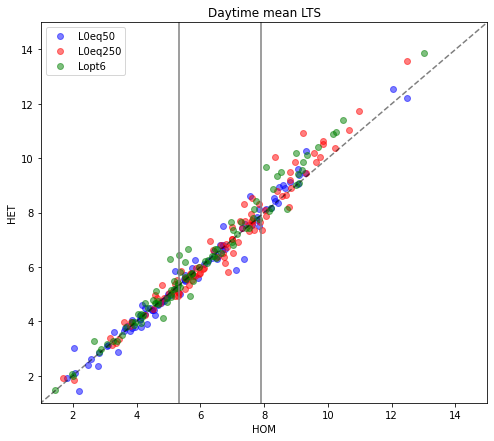

In [47]:
fig,axs=plt.subplots(1,1,figsize=(8,7))

plt.plot(scamDS_daytime[varDef].sel(case='clubbMF_L0eq50').values, 
            scamDS_daytime[varDef].sel(case='claspMF_L0eq50').values, 'bo', alpha=0.5, label='L0eq50')

plt.plot(scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').values, 
         scamDS_daytime[varDef].sel(case='claspMF_L0eq250').values, 'ro', alpha=0.5, label='L0eq250')

plt.plot(scamDS_daytime[varDef].sel(case='clubbMF_Lopt6_perPlume').values, 
         scamDS_daytime[varDef].sel(case='claspMF_Lopt6_perPlume').values, 'go', alpha=0.5, label='Lopt6')

plt.legend()

plt.axvline(pct75,color='grey')
plt.axvline(pct25,color='grey')

plt.plot(np.arange(0,16,1), np.arange(0,16,1),'k--',alpha=0.5)
plt.xlim([1,15])
plt.ylim([1,15])

plt.xlabel('HOM')
plt.ylabel('HET')
plt.title('Daytime mean LTS')



In [44]:
# Also get those days in the full DS 

iPct25_times  = []
iPct75_times = []
iother_times  = []

for iT in range(len(scamDS_daytime.time.values)):
    thisDay_var = scamDS_daytime[varDef].sel(case='clubbMF_L0eq250').isel(time=iT)
    
    iTimes = np.where((scamDS['time.year'].values==thisDay_var['time.year'].values) & 
                      (scamDS['time.month'].values==thisDay_var['time.month'].values) &
                      (scamDS['time.day'].values==thisDay_var['time.day'].values))[0]
    
    if thisDay_var.values <= pct25:
        iPct25_times = np.append(iPct25_times, iTimes) 
    elif thisDay_var.values >= pct75:
        iPct75_times = np.append(iPct75_times, iTimes) 
    else: 
        iother_times = np.append(iother_times, iTimes) 
        
pct25days_DS  = scamDS.isel(time=iPct25_times.astype(int))
pct75days_DS  = scamDS.isel(time=iPct75_times.astype(int))
otherDays_DS  = scamDS.isel(time=iother_times.astype(int))


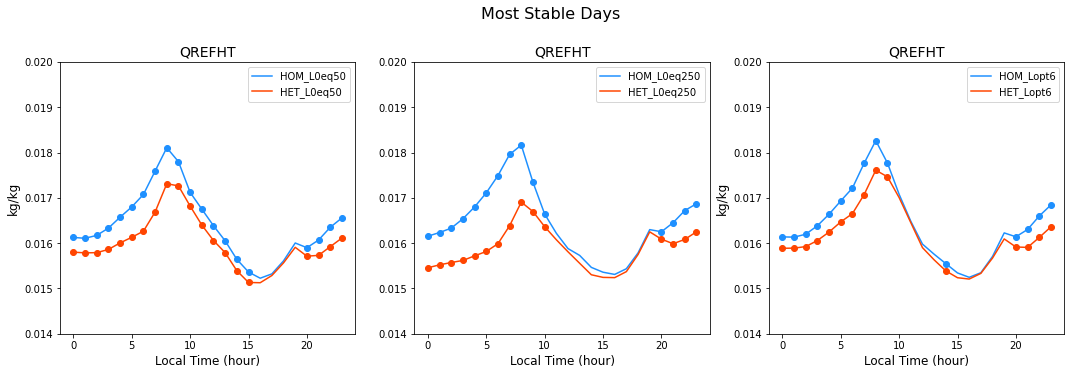

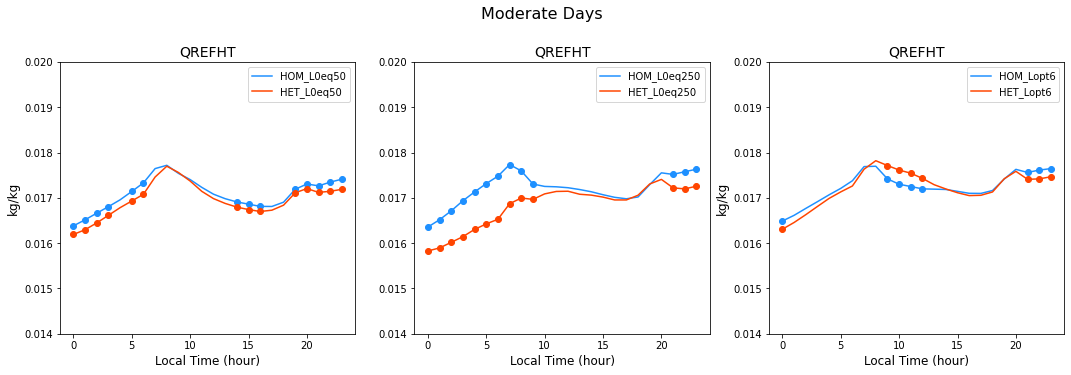

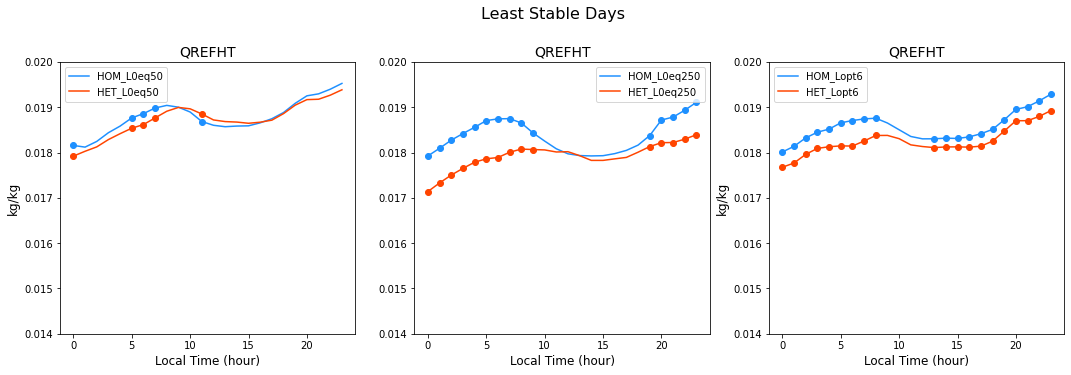

In [75]:

varPlot = 'QREFHT'
yMax    = 0.02
yMin    = 0.014
unitsString = scamDS[varPlot].units
# unitsString = 'mm/hr'
setYlims = True
plotTests250 = False

# valueMultiplier = (3600*1e3)
valueMultiplier =  1


fig,axs = plotTimeseries_dayClasses(pct25days_DS, 'Most Stable Days', varPlot,  # DStoUse,dayClassStr,varPlot
                              yMax, yMin, unitsString,setYlims,           # yMax, yMin, unitsString,setYlims, 
                              valueMultiplier, plotTests250)              # valueMultiplier, CIlevel

fig,axs = plotTimeseries_dayClasses(otherDays_DS, 'Moderate Days', varPlot, # DStoUse,dayClassStr,varPlot
                              yMax, yMin, unitsString,setYlims,            # yMax, yMin, unitsString,setYlims, 
                              valueMultiplier, plotTests250)               # valueMultiplier, CIlevel

fig,axs = plotTimeseries_dayClasses(pct75days_DS, 'Least Stable Days', varPlot, # DStoUse,dayClassStr,varPlot
                              yMax, yMin, unitsString,setYlims,          # yMax, yMin, unitsString,setYlims, 
                              valueMultiplier, plotTests250)             # valueMultiplier, CIlevel



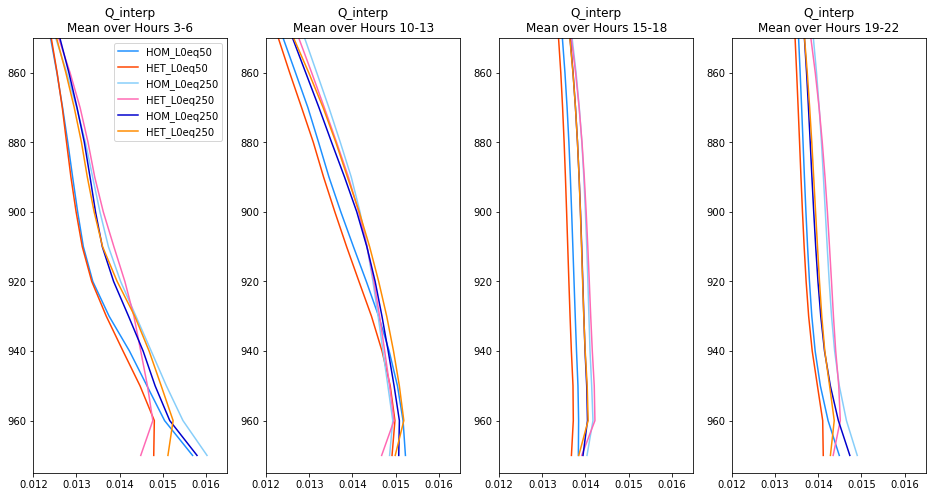

In [67]:

varPlot = 'Q_interp'
levName = 'levInterp'
levMax  = 850.
xMin = 0.012
xMax = 0.0165


DS1 = pct25days_DS
DS2 = otherDays_DS
DS3 = pct25days_DS

hrStarts = [3,10,15,19]
hrEnds   = [6,13,18,22]

fig,axs = plt.subplots(1,4, figsize=(16,8))
axs     = axs.ravel()

for iHours in range(len(hrStarts)):
    iTimes_cat1 = np.where((DS1['time.hour'].values>=hrStarts[iHours]) & (DS1['time.hour'].values<=hrEnds[iHours]))[0]
    iTimes_cat2 = np.where((DS2['time.hour'].values>=hrStarts[iHours]) & (DS2['time.hour'].values<=hrEnds[iHours]))[0]
    iTimes_cat3 = np.where((DS3['time.hour'].values>=hrStarts[iHours]) & (DS3['time.hour'].values<=hrEnds[iHours]))[0]
    
    DS1_timeSel = DS1[varPlot].isel(time=iTimes_cat1).resample(time='1H').mean().mean(dim='time')
    DS2_timeSel = DS2[varPlot].isel(time=iTimes_cat2).resample(time='1H').mean().mean(dim='time')
    DS3_timeSel = DS3[varPlot].isel(time=iTimes_cat3).resample(time='1H').mean().mean(dim='time')
    
    
    axs[iHours].plot(DS1_timeSel.sel(case='clubbMF_L0eq50').values, DS1_timeSel[levName].values, color='dodgerblue', label='HOM_L0eq50')
    axs[iHours].plot(DS1_timeSel.sel(case='claspMF_L0eq50').values, DS1_timeSel[levName].values, color='orangered', label='HET_L0eq50')

    axs[iHours].plot(DS1_timeSel.sel(case='clubbMF_L0eq250').values, DS1_timeSel[levName].values, color='lightskyblue', label='HOM_L0eq250')
    axs[iHours].plot(DS1_timeSel.sel(case='claspMF_L0eq250').values, DS1_timeSel[levName].values, color='hotpink', label='HET_L0eq250')

    axs[iHours].plot(DS1_timeSel.sel(case='clubbMF_Lopt6_perPlume').values, DS1_timeSel[levName].values, color='mediumblue', label='HOM_L0eq250')
    axs[iHours].plot(DS1_timeSel.sel(case='claspMF_Lopt6_perPlume').values, DS1_timeSel[levName].values, color='darkorange', label='HET_L0eq250')

    if iHours==0:
        axs[iHours].legend()
        
    axs[iHours].set_title(varPlot+'\nMean over Hours '+str(hrStarts[iHours])+'-'+str(hrEnds[iHours]))

    axs[iHours].invert_yaxis()
    axs[iHours].set_ylim([975,levMax])
    axs[iHours].set_xlim([xMin, xMax])


In [43]:
# def plotTimeseries_dayClasses(DStoUse, dayClassStr,varPlot, 
#                               yMax, yMin, unitsString,setYlims, 
#                               valueMultiplier, CIlevel):

#     # - - - - - - - - - - - - - - - - - 
#     fig,axs = plt.subplots(1,2, figsize=(13,4))
#     axs     = axs.ravel()

#     DS_mean  = (valueMultiplier*DStoUse[varPlot]).groupby('time.hour').mean(dim='time')
#     DS_std   = (valueMultiplier*DStoUse[varPlot]).groupby('time.hour').std(dim='time')
#     DS_count = (valueMultiplier*DStoUse[varPlot]).groupby('time.hour').count(dim='time')
#     DS_SE    = DS_std/np.sqrt(DS_count)

#     plt.gcf().text(0.45, 1, dayClassStr, fontsize=16)

#     # - - - - - - - - - - - - - - - - - 
#     # Plot L0=50 in first panel 
#     axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq50').values, color='dodgerblue', label='HOM_L0eq50') 
#     axs[0].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq50').values, color='orangered', label='HET_L0eq50') 
#     axs[0].legend()

#     axs[0].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='clubbMF_L0eq50').values-(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq50').values))),
#        np.squeeze(DS_mean.sel(case='clubbMF_L0eq50').values+(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq50').values))),
#        alpha = 0.2, facecolor='dodgerblue',edgecolor='blue')

#     axs[0].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq50').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq50').values))),
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq50').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq50').values))),
#        alpha = 0.2, facecolor='orangered',edgecolor='red')

#     axs[0].set_title(varPlot,fontsize=14)
#     axs[0].set_ylabel(unitsString, fontsize=12)
#     axs[0].set_xlabel('Local Time (hour)', fontsize=12)
#     if setYlims==True: 
#         axs[0].set_ylim([yMin, yMax])

#     # - - - - - - - - - - - - - - - - - 
#     # Plot L0=250 in second panel 
#     axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='clubbMF_L0eq250').values, color='dodgerblue', label='HOM_L0eq250') 
#     axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250').values, color='orangered', label='HET_L0eq250') 
#     axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250_52pct').values, color='darkviolet', label='HET_L0eq250_52pct') 
#     axs[1].plot(DS_mean.hour.values, DS_mean.sel(case='claspMF_L0eq250_rand').values, color='green', label='claspMF_L0eq250_rand') 
#     axs[1].legend(ncol=2)

#     axs[1].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='clubbMF_L0eq250').values-(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq250').values))),
#        np.squeeze(DS_mean.sel(case='clubbMF_L0eq250').values+(CIlevel*np.squeeze(DS_SE.sel(case='clubbMF_L0eq250').values))),
#        alpha = 0.2, facecolor='dodgerblue',edgecolor='blue')

#     axs[1].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
#        alpha = 0.2, facecolor='orangered',edgecolor='red')

#     axs[1].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_52pct').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_52pct').values))),
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_52pct').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250').values))),
#        alpha = 0.2, facecolor='darkviolet',edgecolor='purple')

#     axs[1].fill_between(DS_mean.hour.values, 
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_rand').values-(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_rand').values))),
#        np.squeeze(DS_mean.sel(case='claspMF_L0eq250_rand').values+(CIlevel*np.squeeze(DS_SE.sel(case='claspMF_L0eq250_rand').values))),
#        alpha = 0.2, facecolor='green',edgecolor='darkgreen')

#     axs[1].set_title(varPlot,fontsize=14)
#     # axs[1].set_ylabel(scamDS[varPlot].units, fontsize=12)
#     axs[1].set_xlabel('Local Time (hour)', fontsize=12) 
#     if setYlims==True: 
#         axs[1].set_ylim([yMin, yMax])

    
#     return fig,axs

In [26]:
# # - - - - - - - - - - - - - - - - - - - - - -
# #  Plot mean diurnal cycle with error bars
# # - - - - - - - - - - - - - - - - - - - - - - 

# # DStoUse = clearDays_DS
# # dayClassStr = 'Clear Days'

# varPlot = 'RHREFHT'
# yMax    = 0.35
# yMin    = 0
# unitsString = scamDS[varPlot].units
# # unitsString = 'mm/hr'
# setYlims = False

# # valueMultiplier = (3600*1e3)
# valueMultiplier =  1
# CIlevel = 1.960   ## 95% CI 


# fig,axs = plotTimeseries_dayClasses(clearDays_DS, 'Clear Days', varPlot, # DStoUse,dayClassStr,varPlot
#                               yMax, yMin, unitsString,setYlims,           # yMax, yMin, unitsString,setYlims, 
#                               valueMultiplier, CIlevel)                   # valueMultiplier, CIlevel

# fig,axs = plotTimeseries_dayClasses(cloudyDays_DS, 'Cloudy Days', varPlot, # DStoUse,dayClassStr,varPlot
#                               yMax, yMin, unitsString,setYlims,           # yMax, yMin, unitsString,setYlims, 
#                               valueMultiplier, CIlevel)                   # valueMultiplier, CIlevel

# fig,axs = plotTimeseries_dayClasses(rainyDays_DS, 'Rainy Days', varPlot, # DStoUse,dayClassStr,varPlot
#                               yMax, yMin, unitsString,setYlims,           # yMax, yMin, unitsString,setYlims, 
#                               valueMultiplier, CIlevel)                   # valueMultiplier, CIlevel
